# 📊 The Term Deposit Marketing Quest: A Data Story


## Chapter 1: Setting the Stage 🎬Before any great expedition, we must gather our tools. Let's assemble our data science toolkit...



Our journey begins in the world of banking, where understanding customer behavior can mean the difference between a successful campaign and wasted resources. We're about to embark on an analytical adventure to decode the mystery of **who subscribes to term deposits and why**.


In [1]:
## adding libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nbformat
from sklearn.compose import ColumnTransformer
import seaborn as sns
# import standard scaler and train test split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from catboost import CatBoostClassifier
from tdm_utils import *


## Chapter 2: The First Glimpse 👀


Every story needs its characters, and ours are hidden within the data. Let's meet our dataset - thousands of customer interactions, each telling a small part of a larger tale.### Reading provided dataset


In [2]:
### reading provided dataset
customer_df = pd.read_csv('../../data/raw/term-deposit-marketing-2020.csv')


Like opening the first pages of a novel, let's peek at what our data looks like...

In [3]:
customer_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


### describing the dataframe 

In [4]:
customer_df.describe()  

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [5]:

customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


## Chapter 3: Understanding the Landscape 🗺️

As we explore deeper, we notice something peculiar - days are being treated as numbers when they should be categories. Time to fix that!

### Day needs to be categorical

In [6]:
## day needs to be categorical
#customer_df['day'] = customer_df['day'].astype('object')
convert_day_to_week(customer_df, day_column='day', week_column='week')

week
3    12887
2     8880
1     8423
4     6162
5     3648
Name: count, dtype: int64

### Separating the heroes from the outcome


In every story, we must distinguish between our characters (features) and the outcome we seek (target). Let's separate our inputs from our goal: subscription success.

**dropping out the target variable from dataframe**


In [7]:
input_features = customer_df.drop('y', axis=1)
target_variable = customer_df['y']  # assuming 'y' is the target variable

### The great divide: Numbers vs. Categories


Our data speaks different languages - some features whisper in numbers, others speak in categories. Let's sort them out.


In [8]:
# Identify numerical and categorical features
#numerical_features = input_features.select_dtypes(include=[np.number]).columns.tolist()
#categorical_features = input_features.select_dtypes(include=['object']).columns.tolist()

#identify_feature_types(input_features)
categorical_features, numerical_features = identify_feature_types(input_features)
print("Categorical Features:", categorical_features)
print("\nNumerical Features:", numerical_features)


Categorical Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

Numerical Features: ['age', 'balance', 'day', 'duration', 'campaign', 'week']


### The mystery of the unknown 🔍


Some customers hide behind the veil of 'unknown' values. Let's uncover where these mysteries lurk...


In [9]:
# features having unknown values
categorical_features_with_unknown = find_unknown_values(input_features, categorical_features)

Column 'job' has 235 'unknown' values.
Column 'education' has 1531 'unknown' values.
Column 'contact' has 12765 'unknown' values.


### Translating success into numbers


Machines speak binary. Let's translate 'yes' and 'no' into the language of 1s and 0s.


In [10]:
## setting y to binary
target_variable = target_variable.map({'yes': 1, 'no': 0})


In [11]:
target_variable.unique()

array([0, 1])

## Chapter 4: Painting the Picture 🎨


Numbers alone don't tell stories - visualizations do! Let's bring our data to life with interactive charts that reveal hidden patterns.### Checking distribution of y and other features against y - plotting using plotly


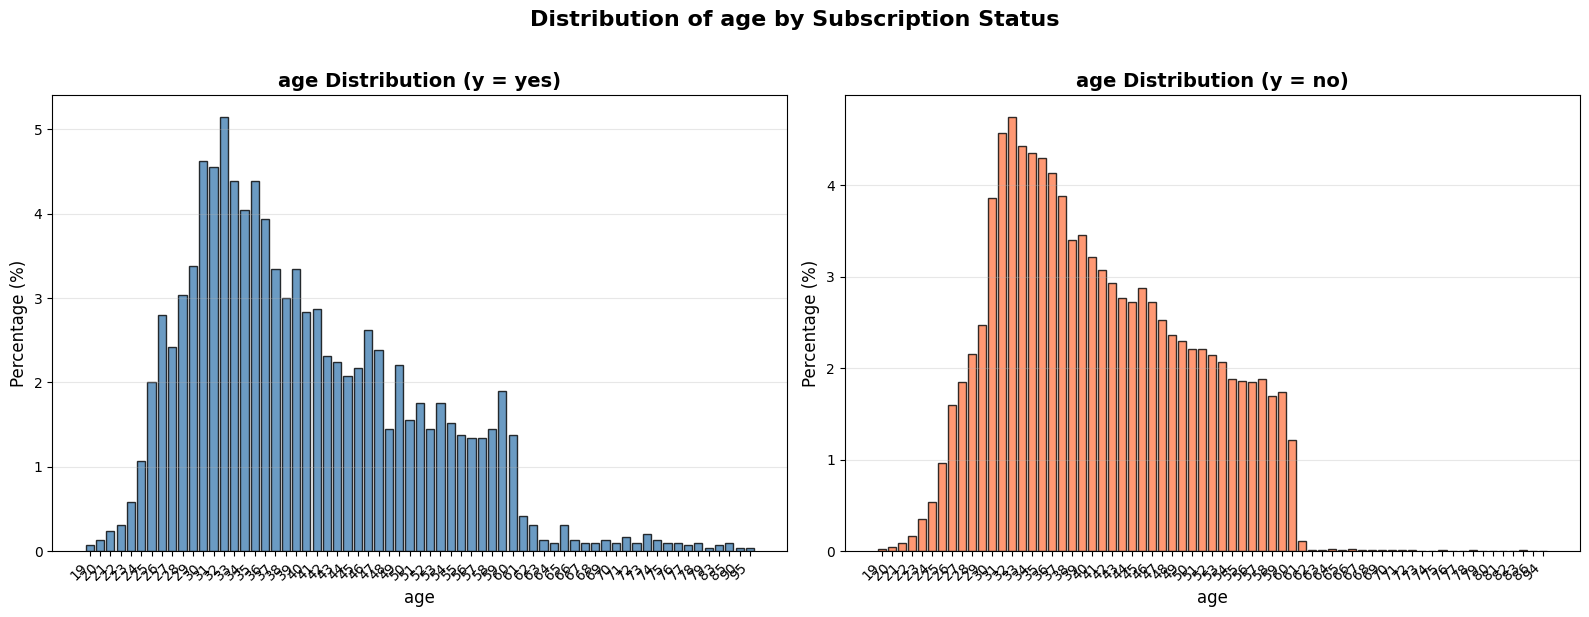

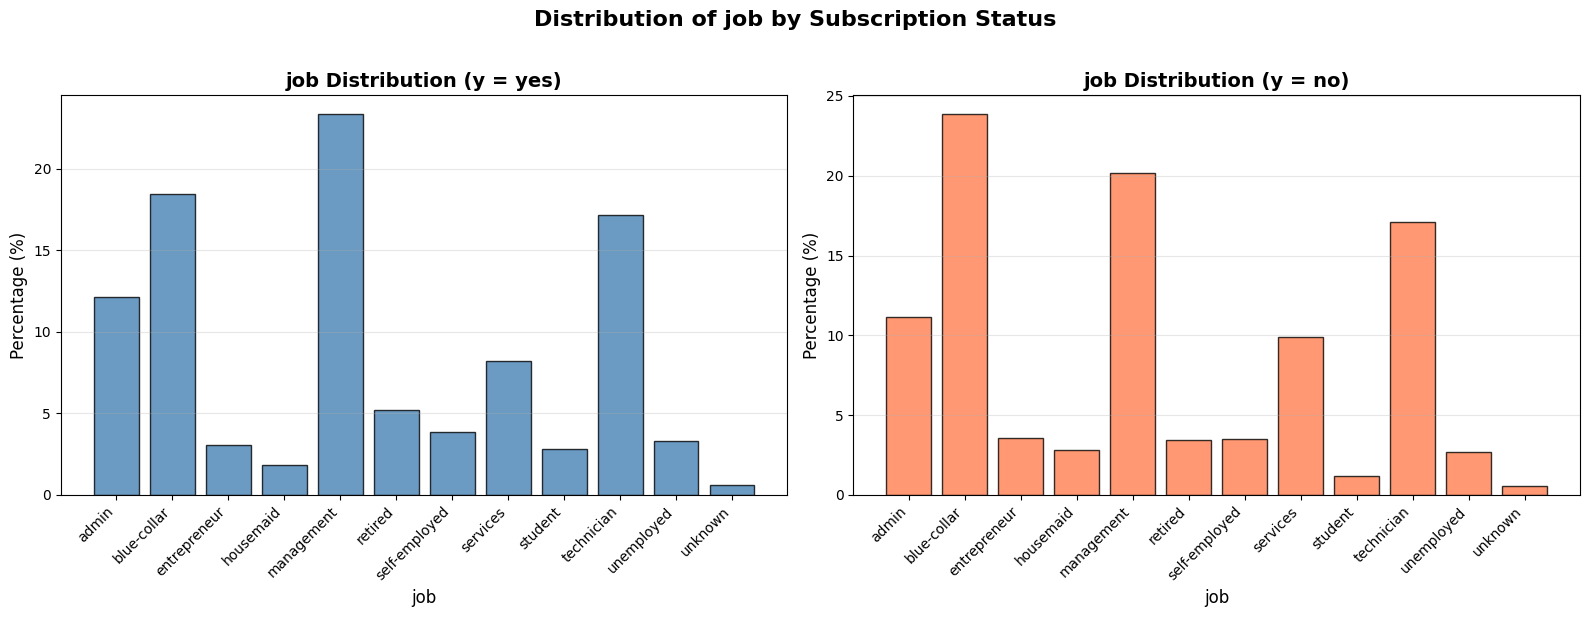

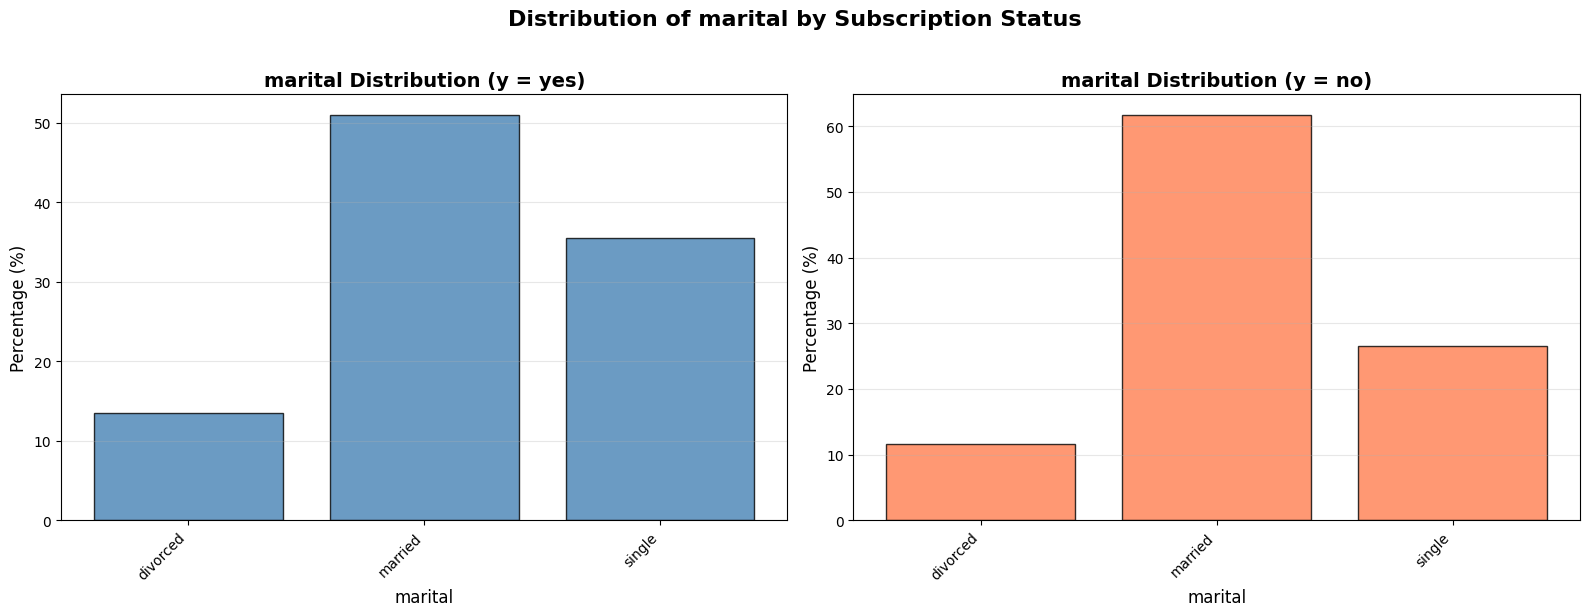

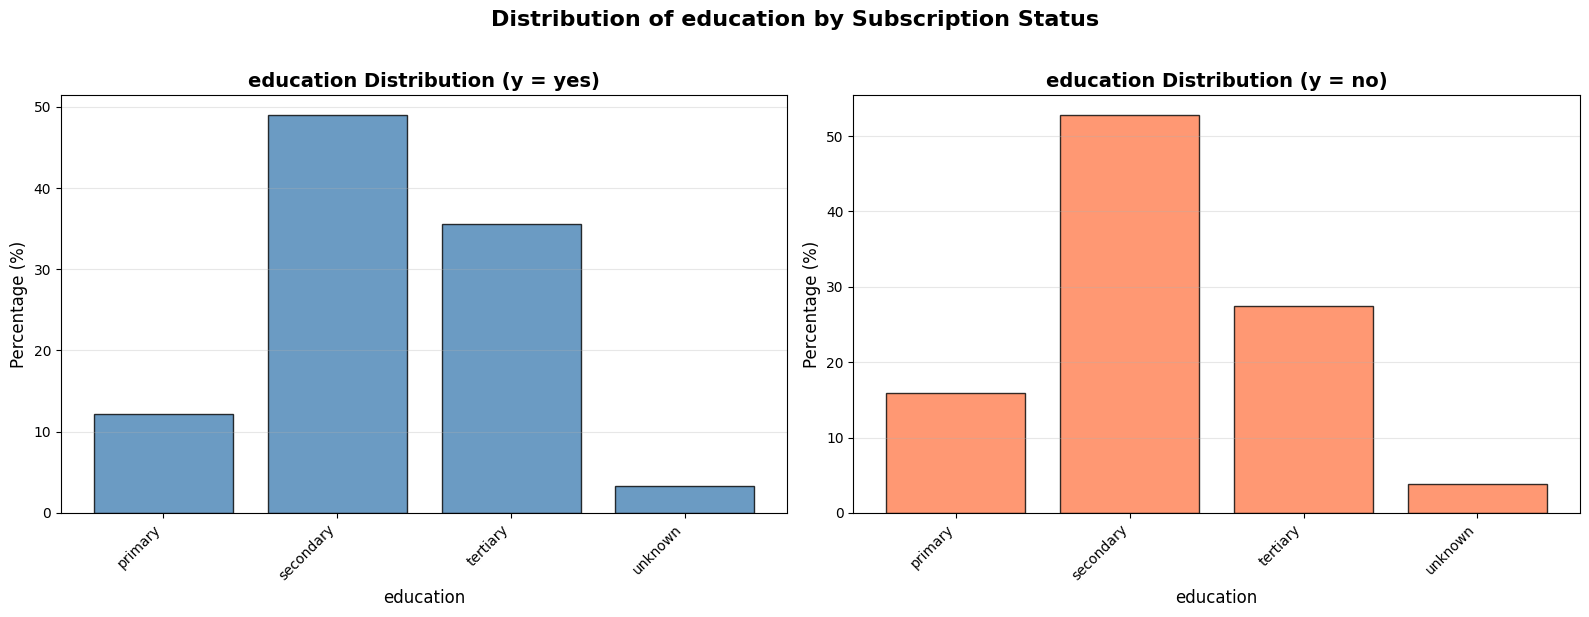

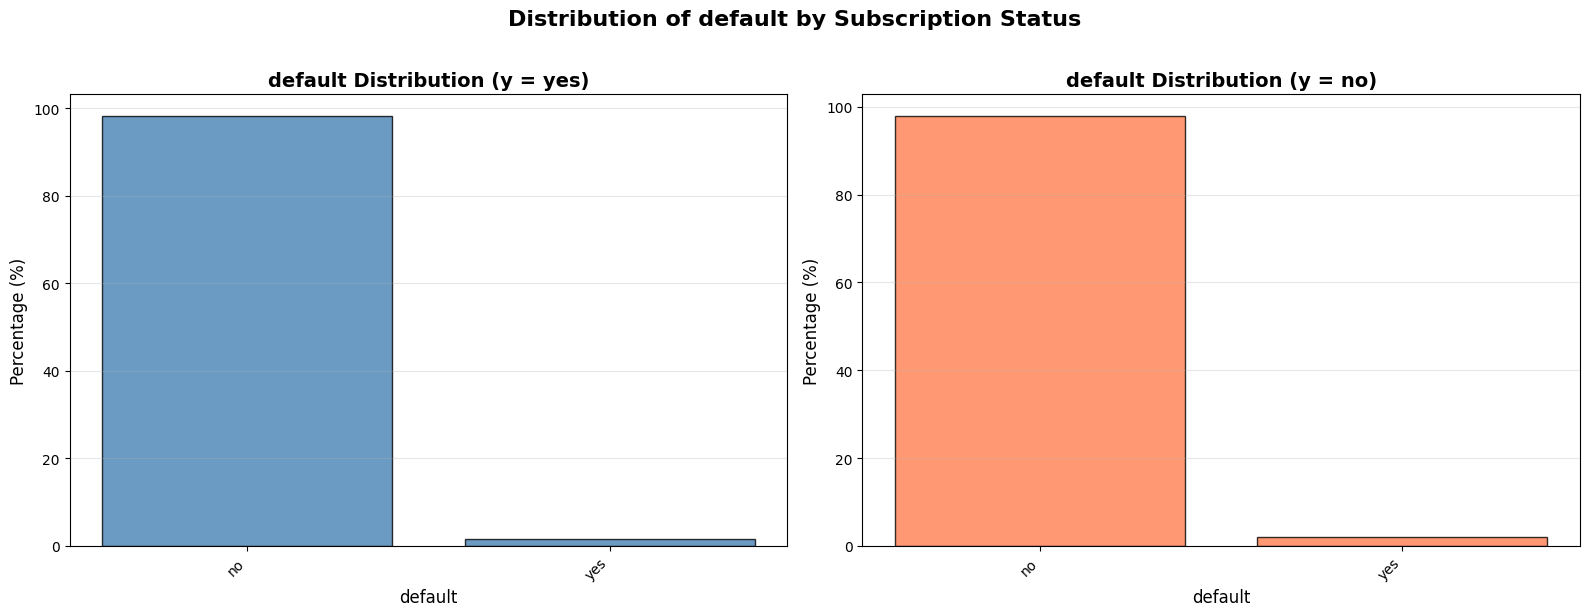

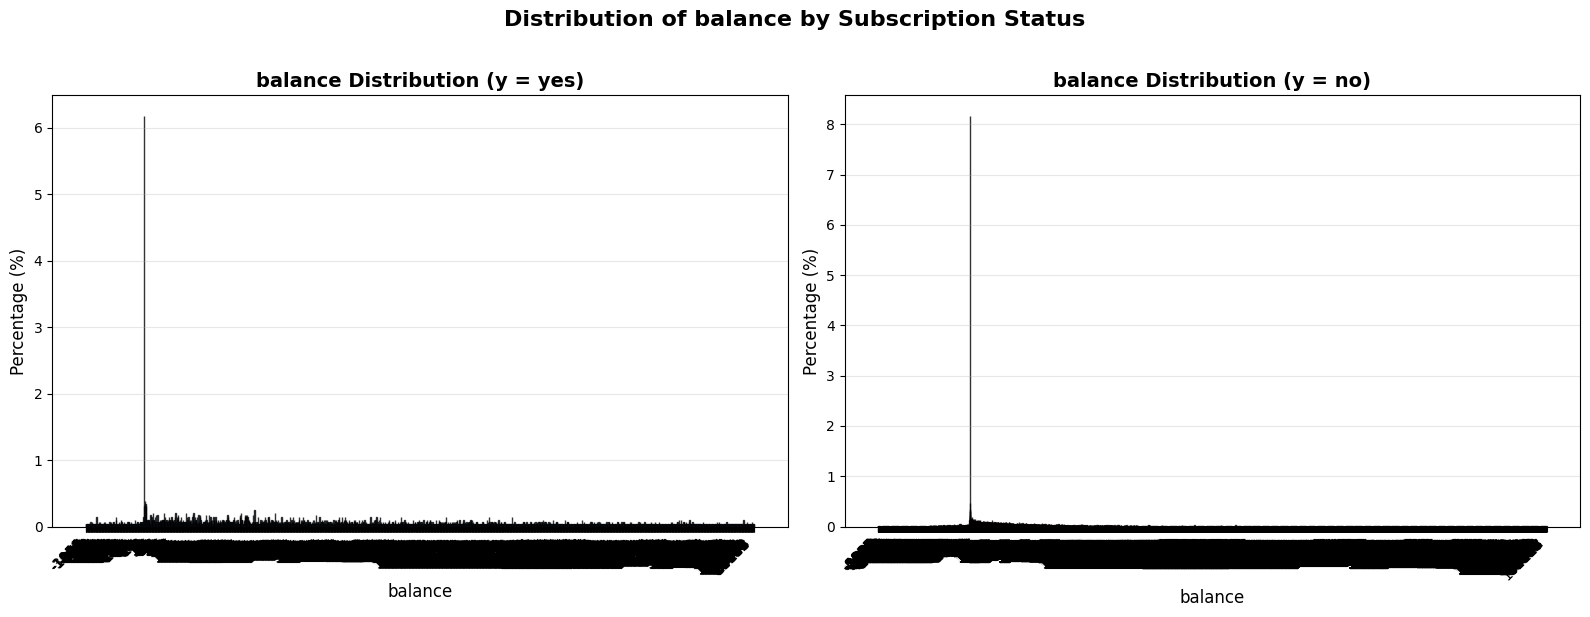

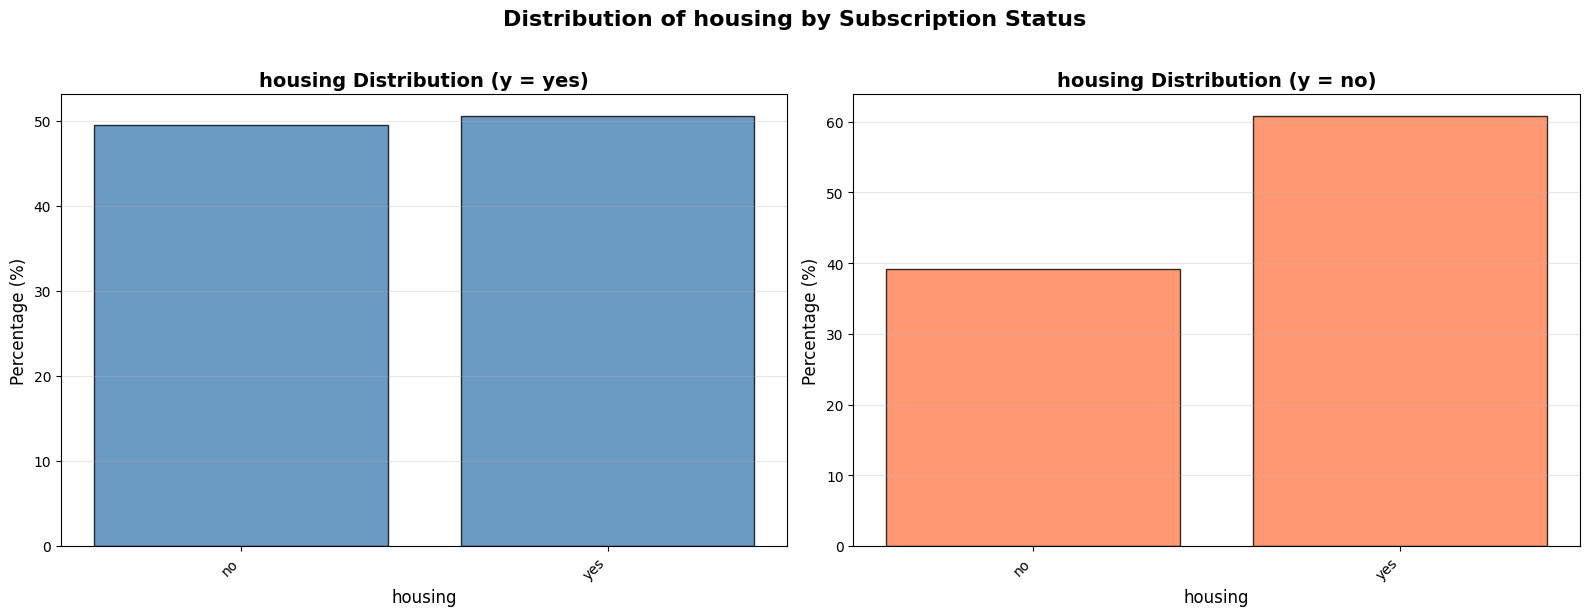

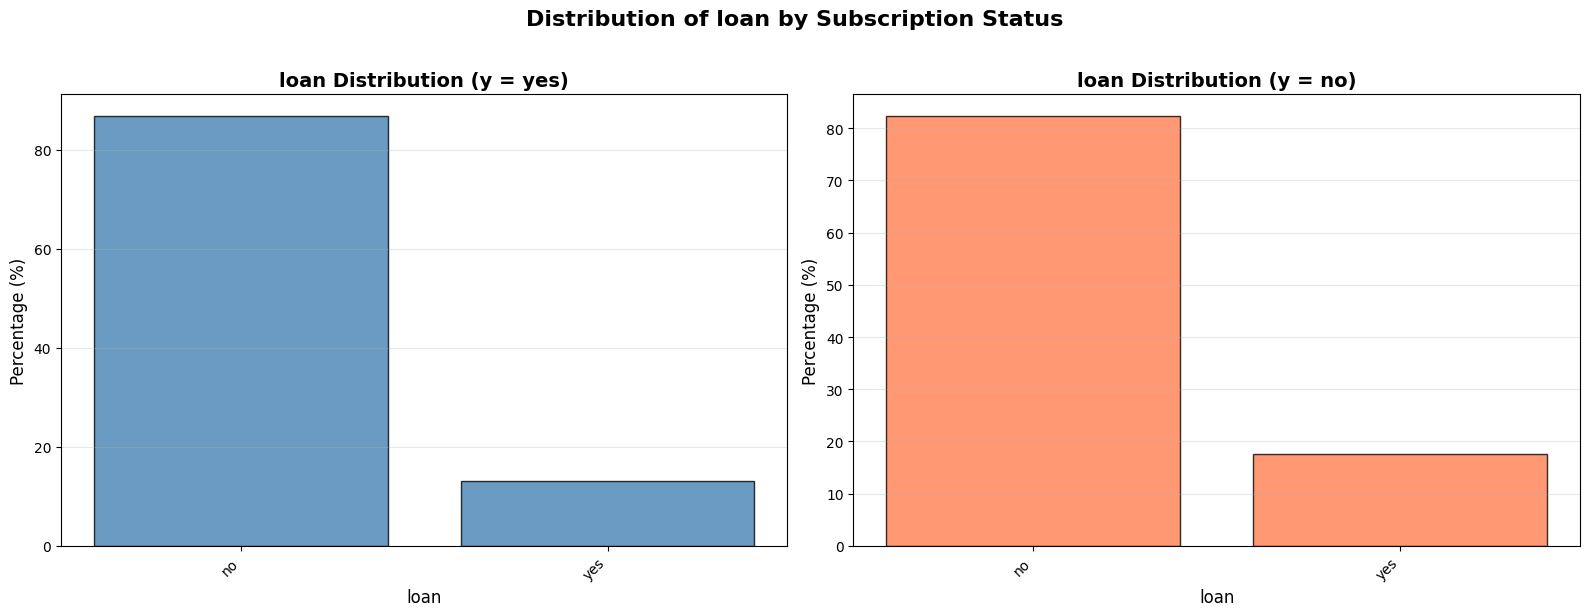

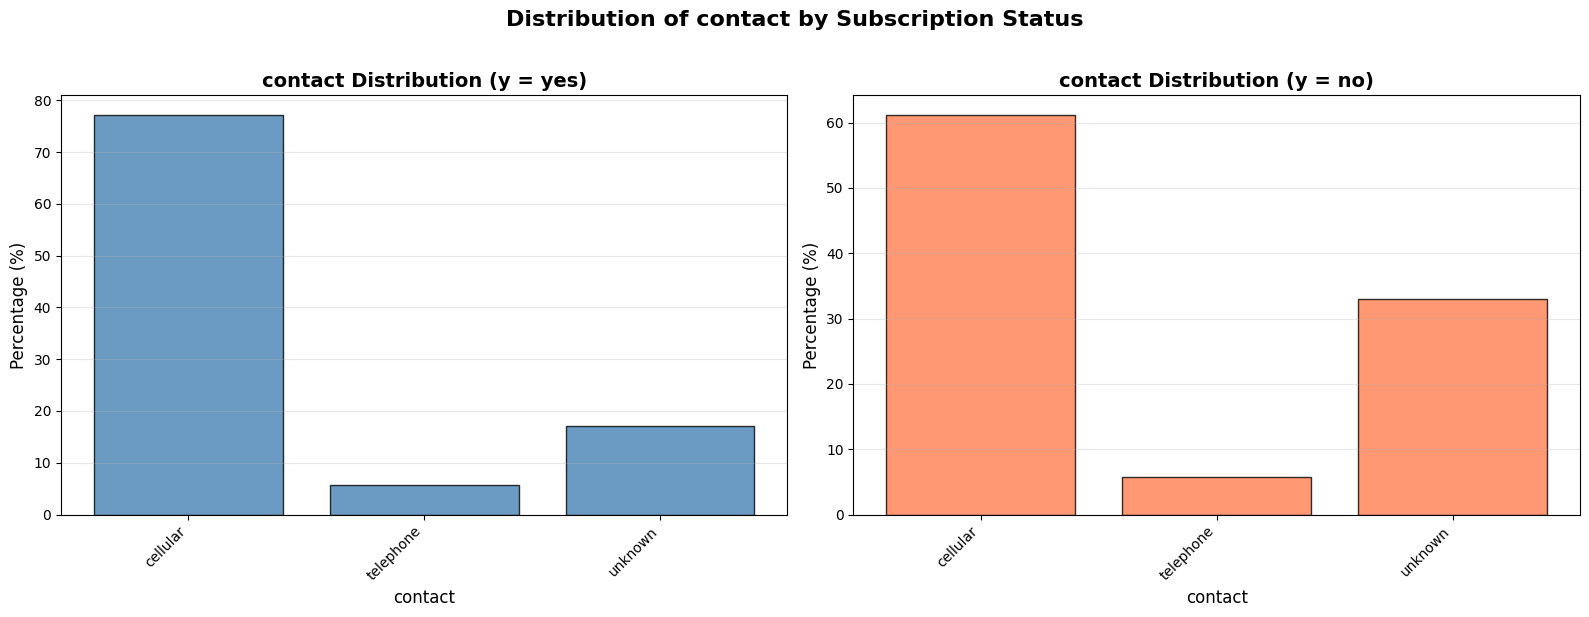

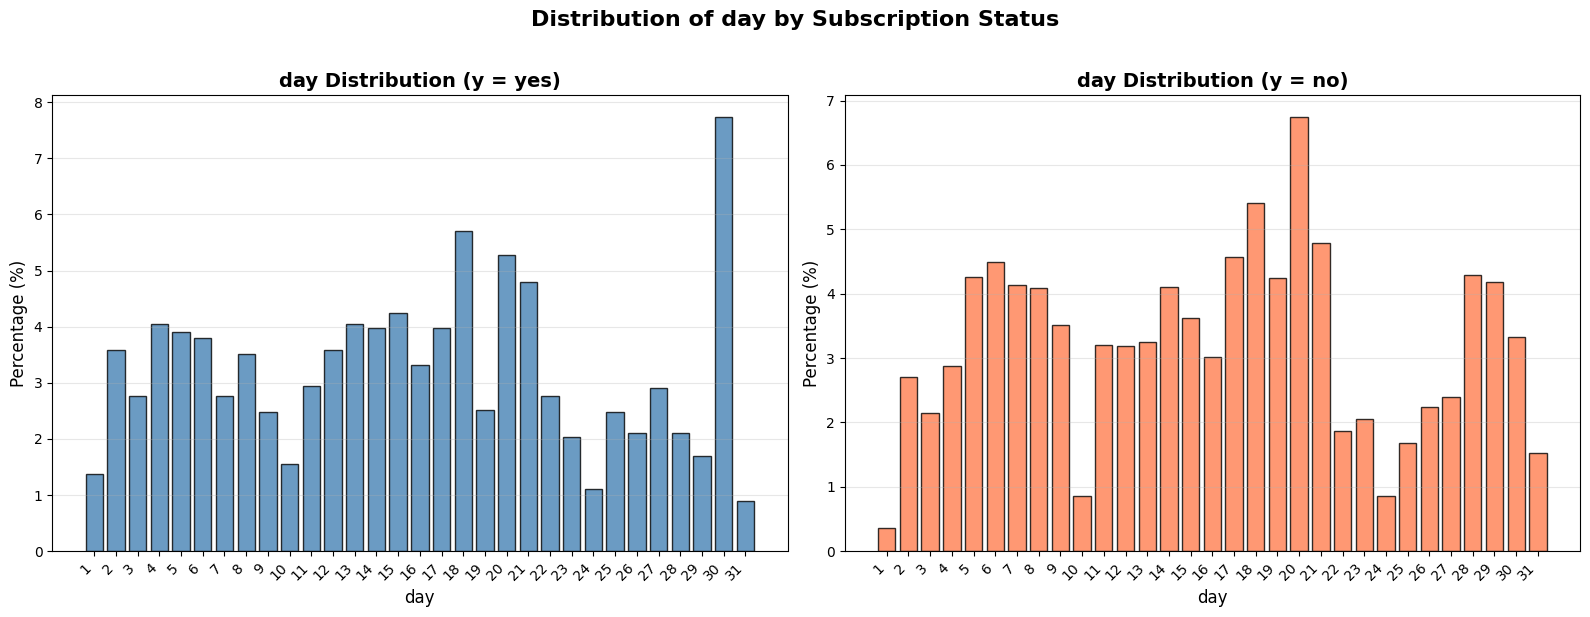

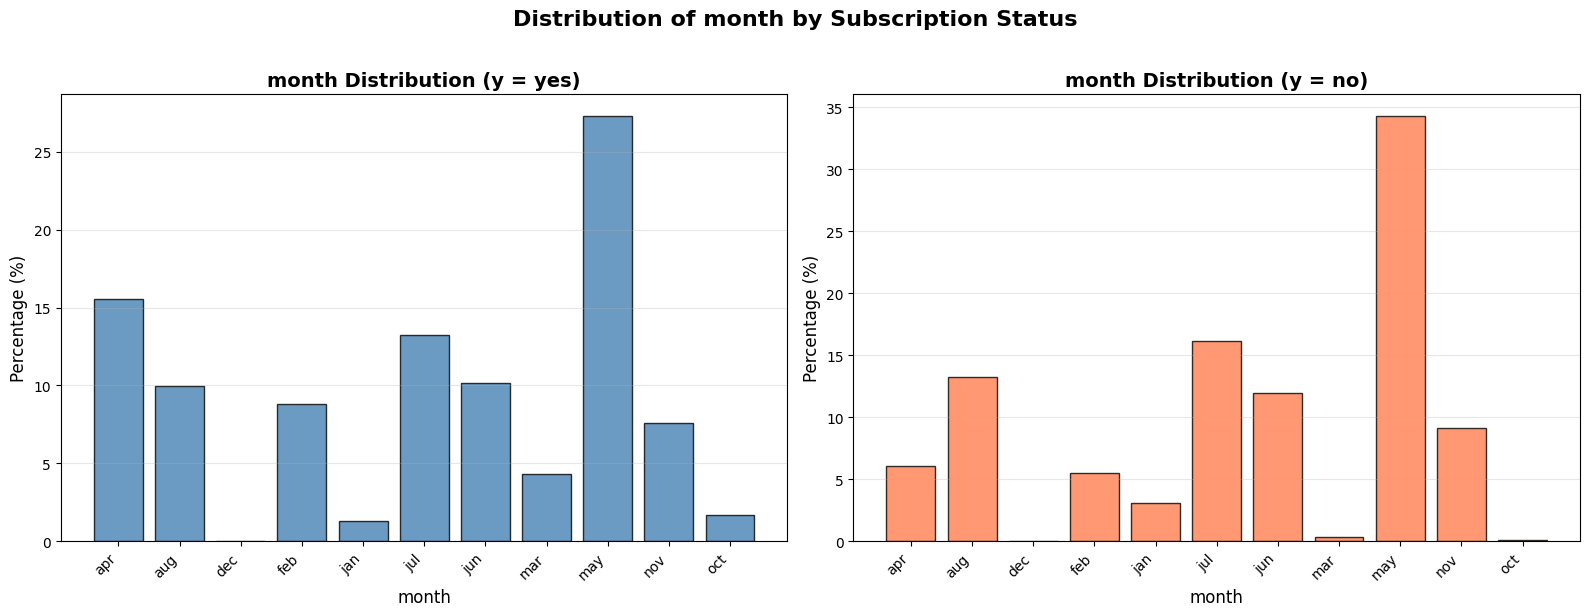

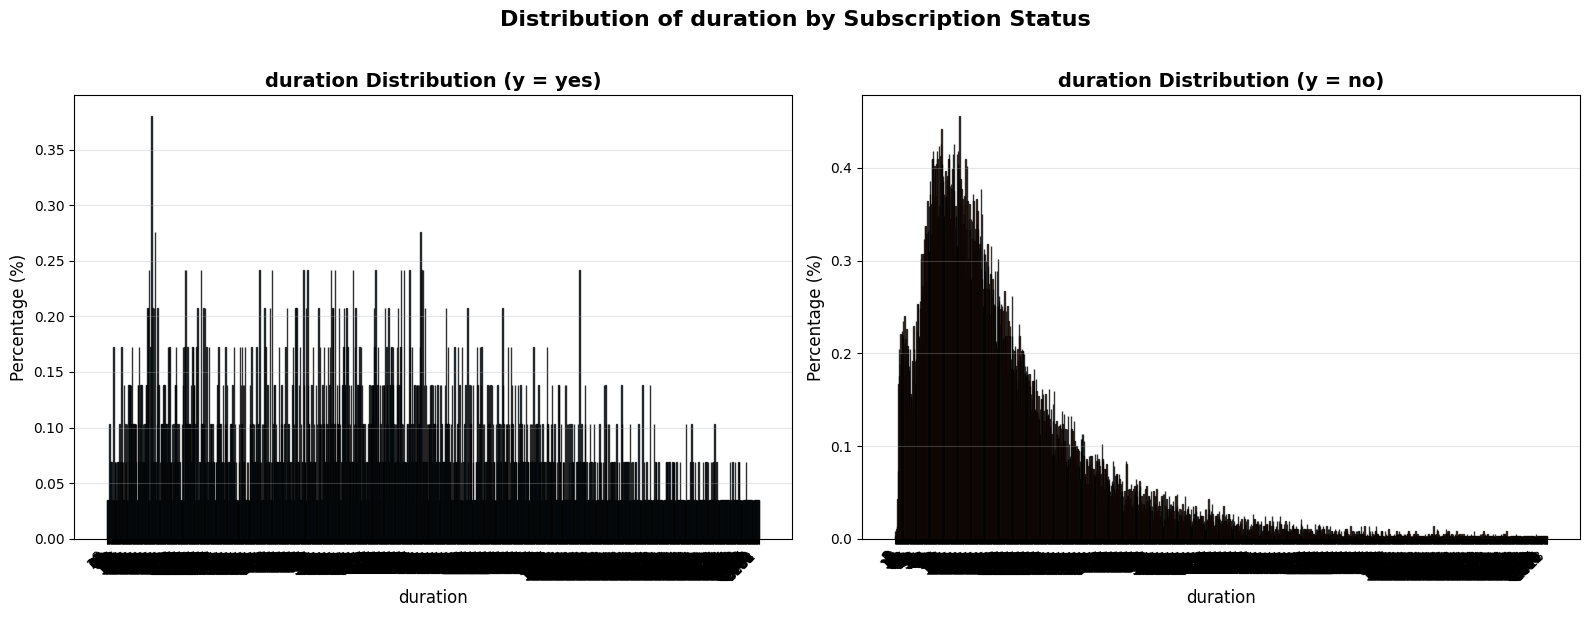

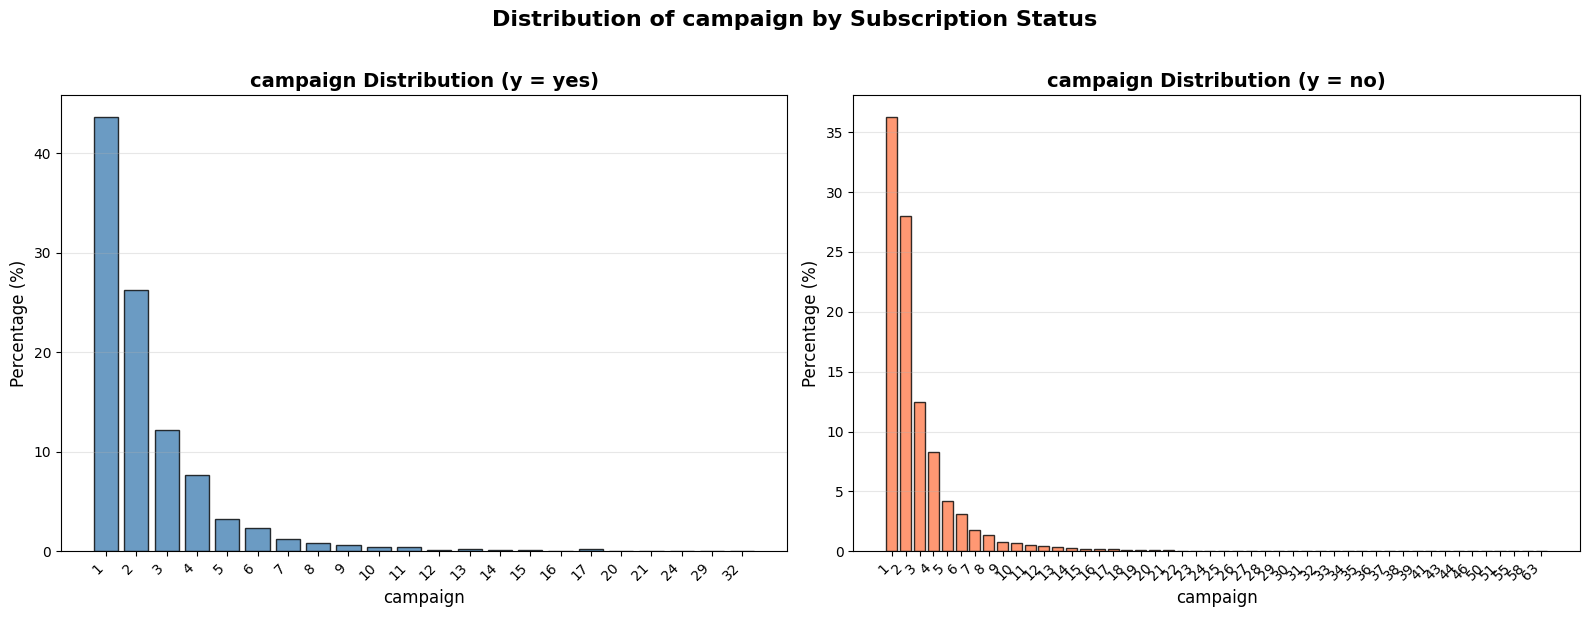

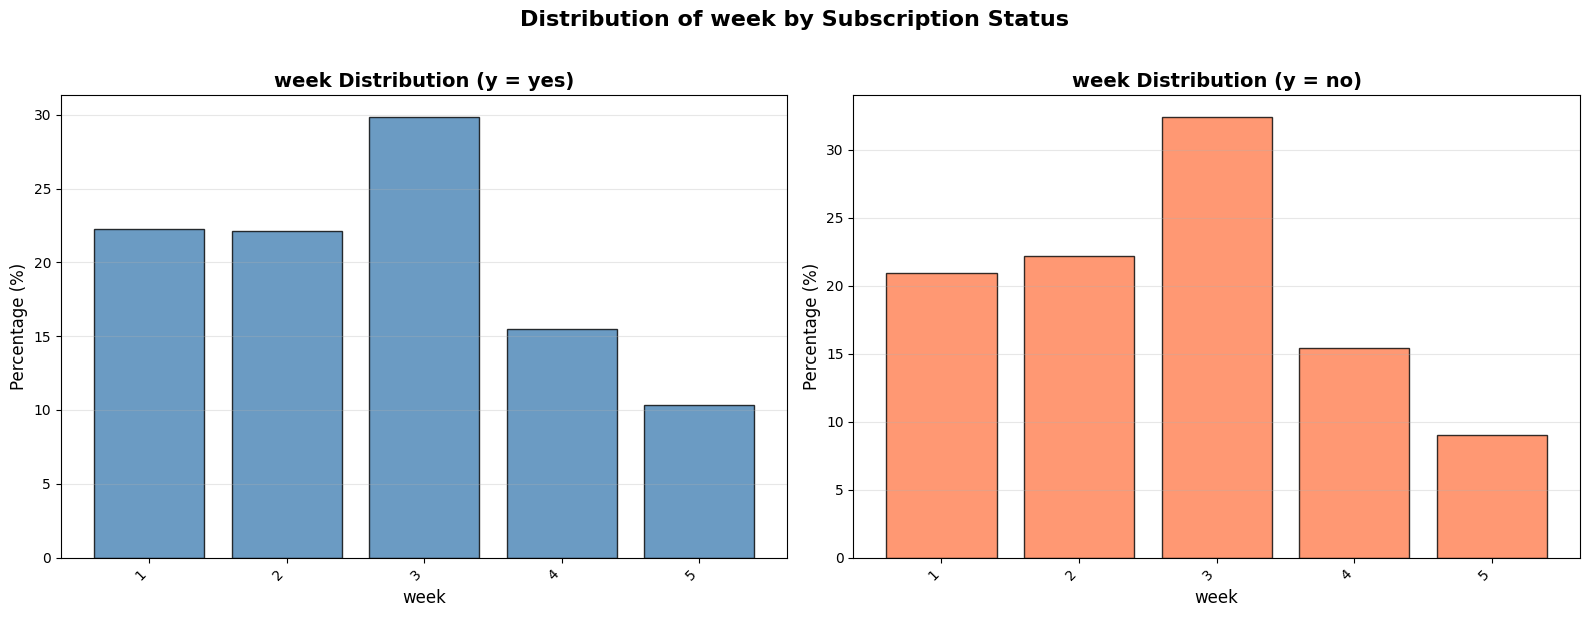

In [12]:
### checking distribution of features against y - using utility function
plot_feature_distribution_by_target(customer_df, input_features.columns.tolist(), 
                                   target_column='y', save_figures=True)

## 💡 Plot Twist: The Profile of Success Emerges!

The visualizations whisper secrets about our successful subscribers...

### Customers likely to have subscription:
- **Age sweet spot:** People in the age group between 30-40 hold the golden key
- **Timing is everything:** May emerges as the month of champions
- **Life stage matters:** Married individuals show stronger commitment
- **Education counts:** Secondary education holders lead the pack
- **Campaign efficiency:** Campaign type 1 works like magic
- **The power of conversation:** Call duration plays a starring role in conversions
- **Communication channel:** Cellular contact creates stronger connections

### feature exploration: Every feature tells a story

Let's dive deeper into each feature's individual narrative with  visualizations...

### Use matplotlib to create interactive visualizations

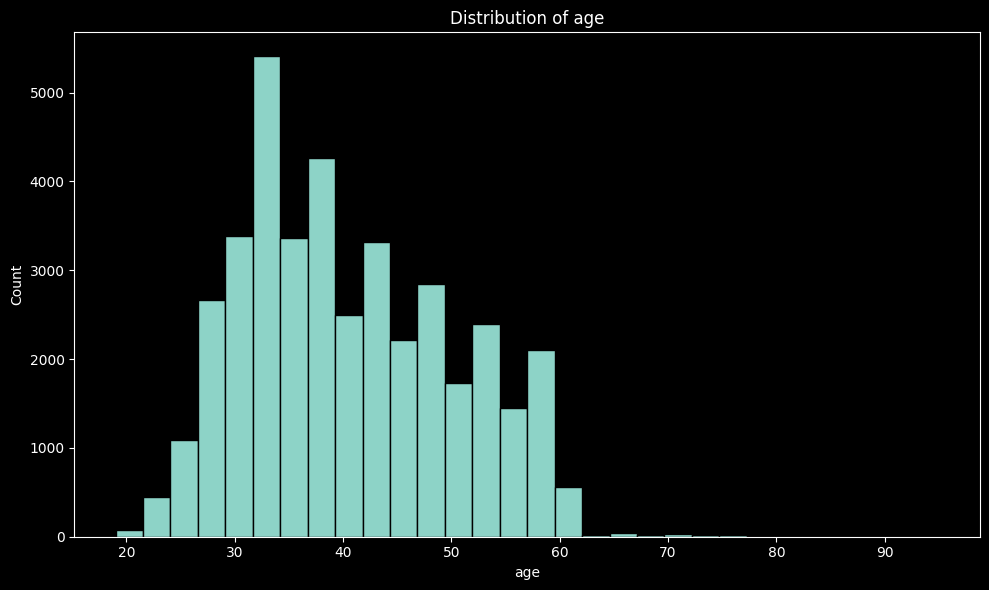

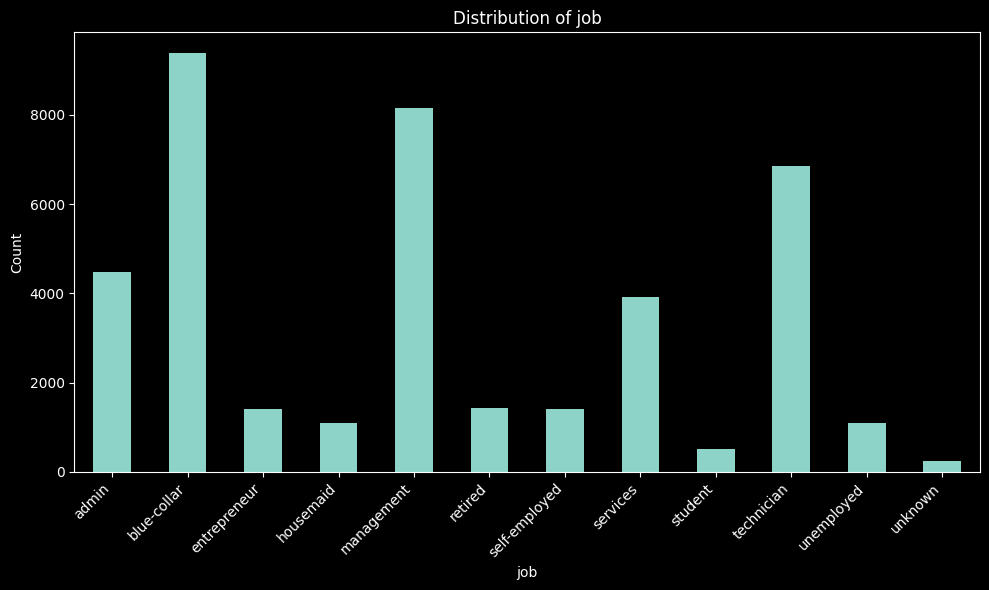

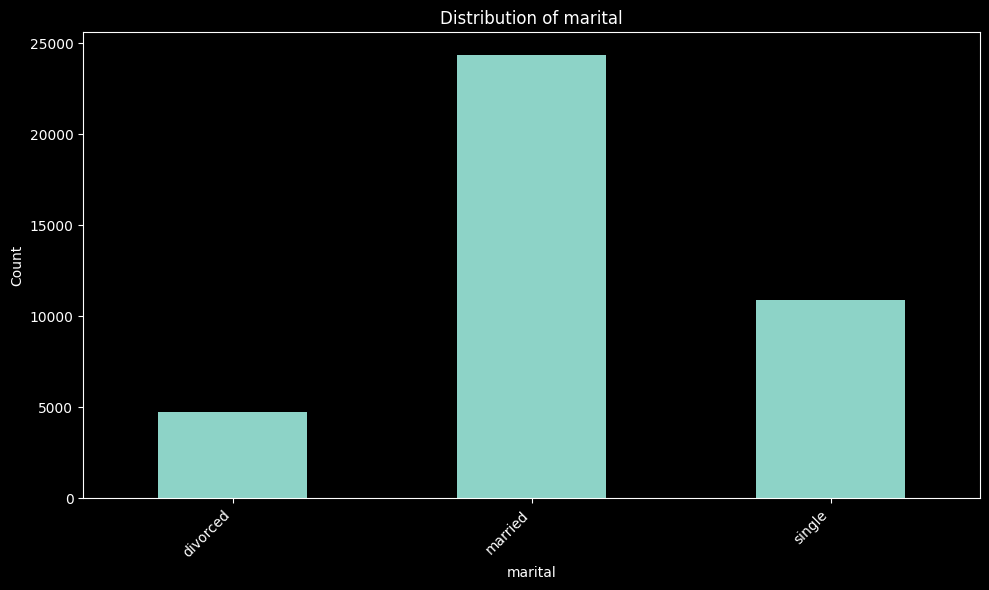

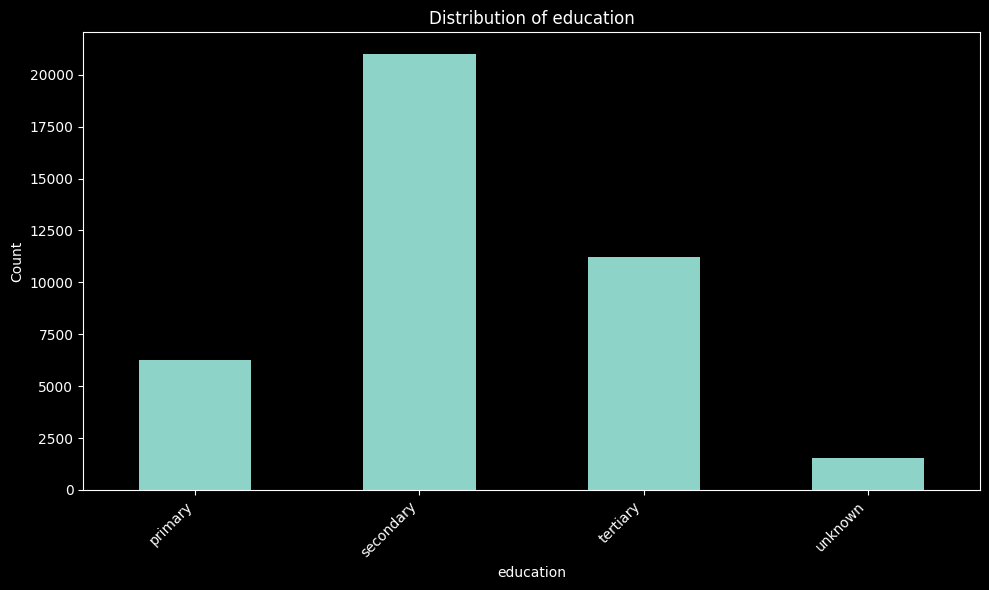

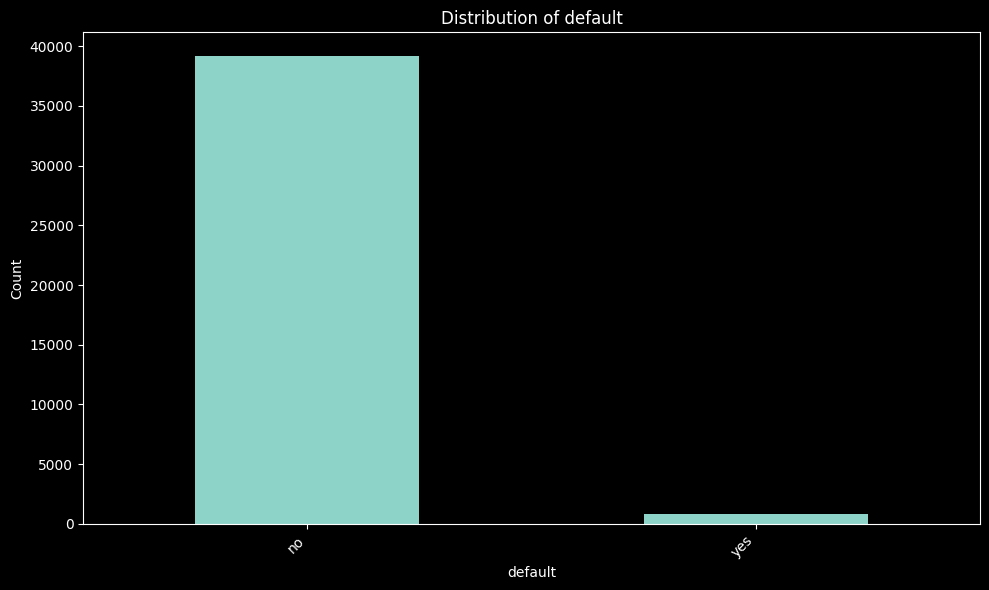

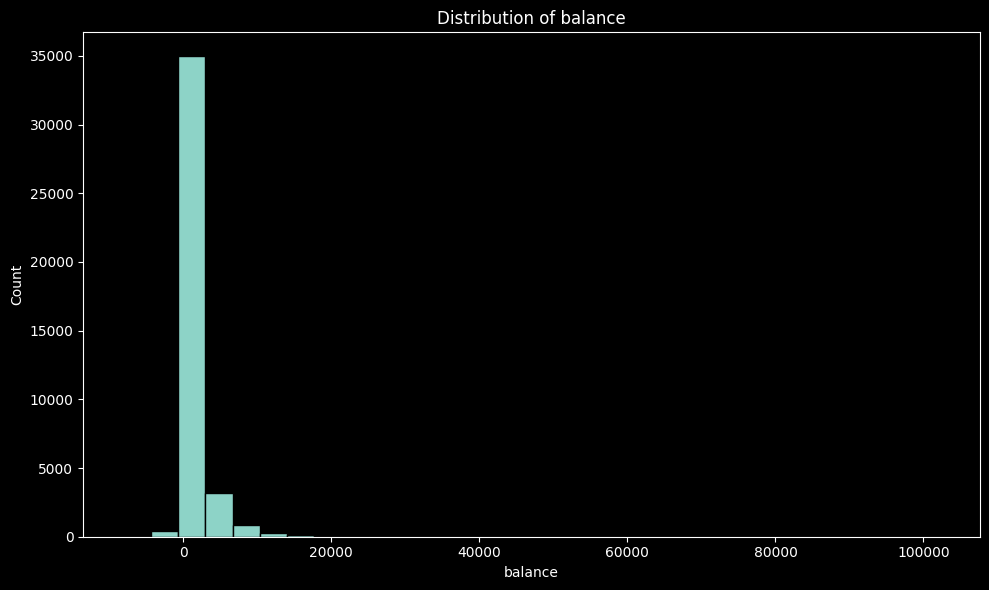

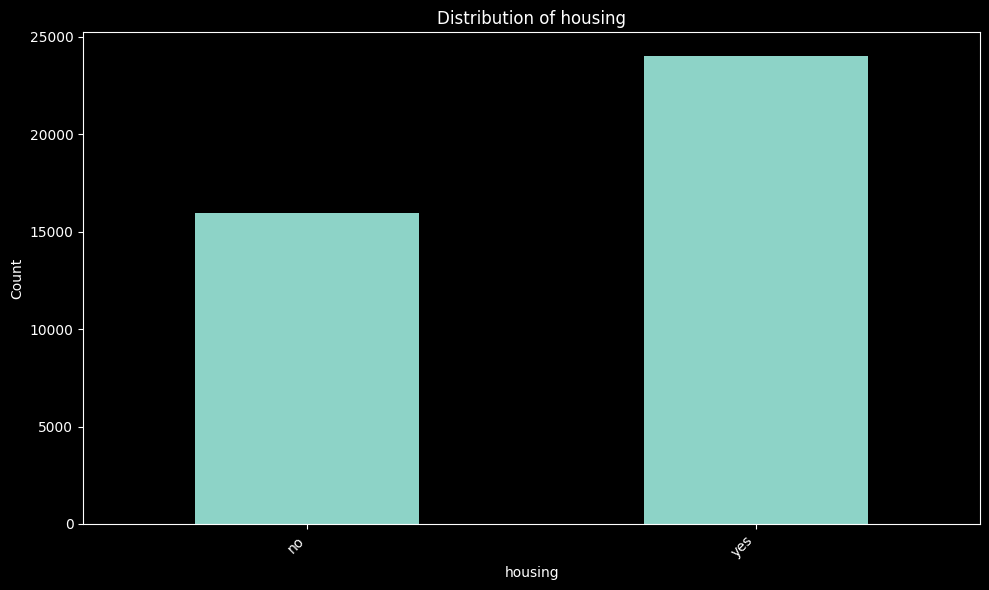

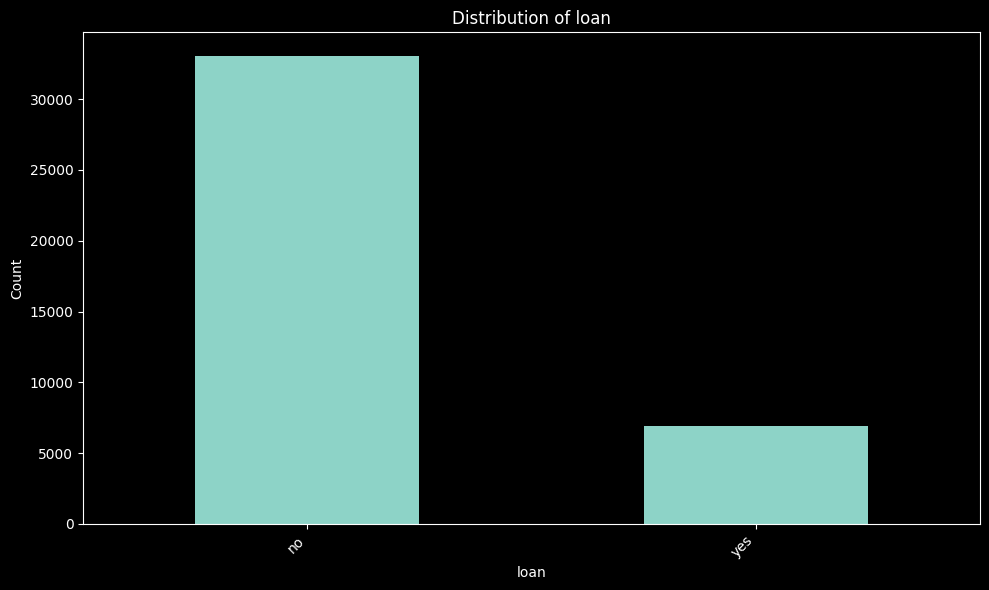

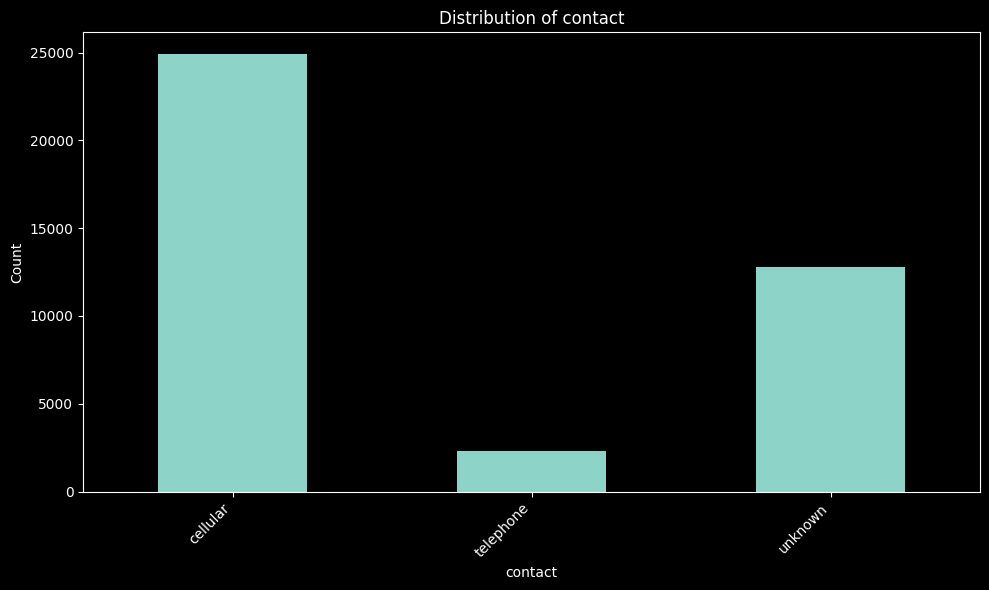

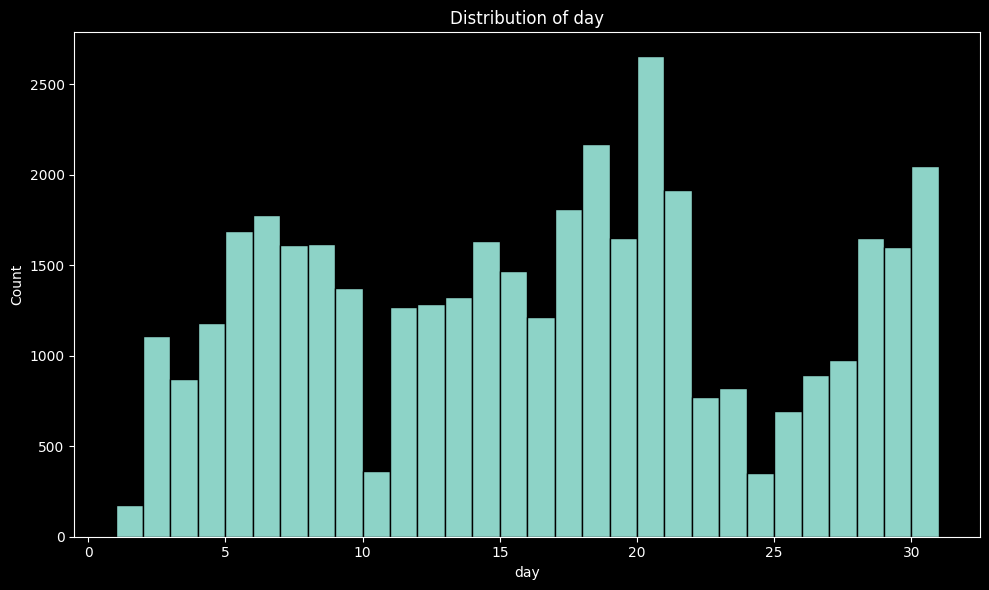

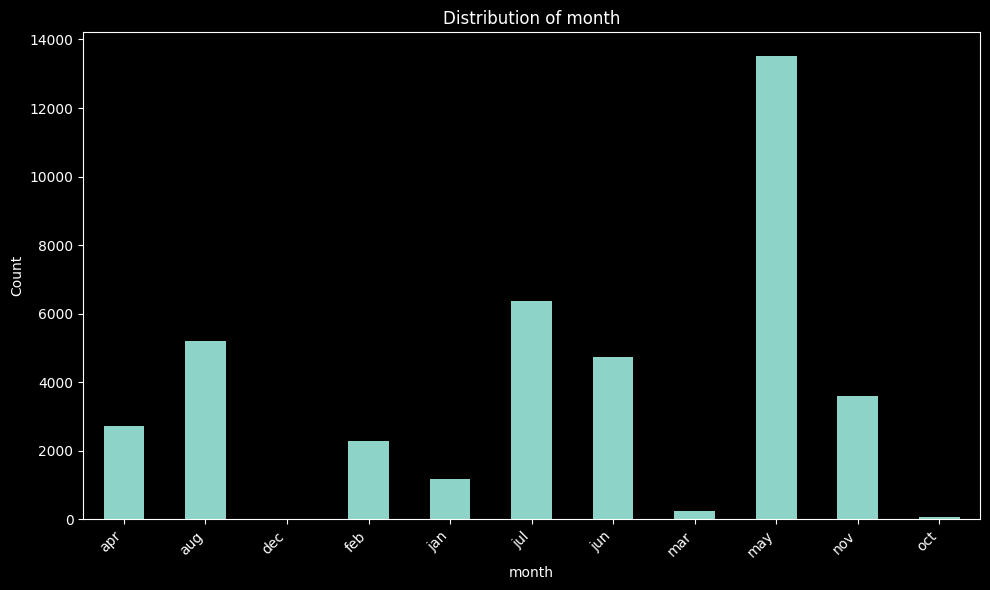

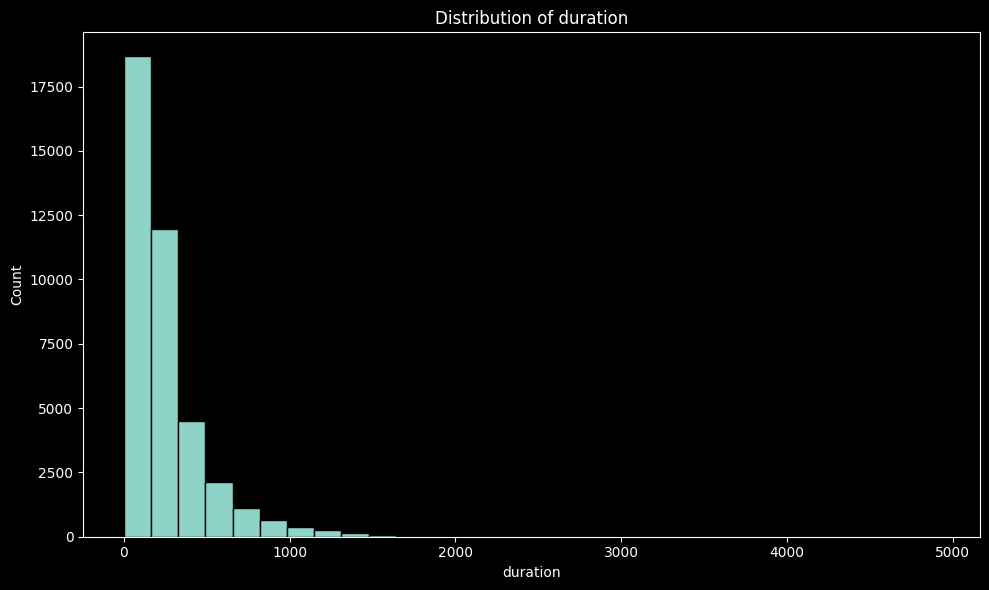

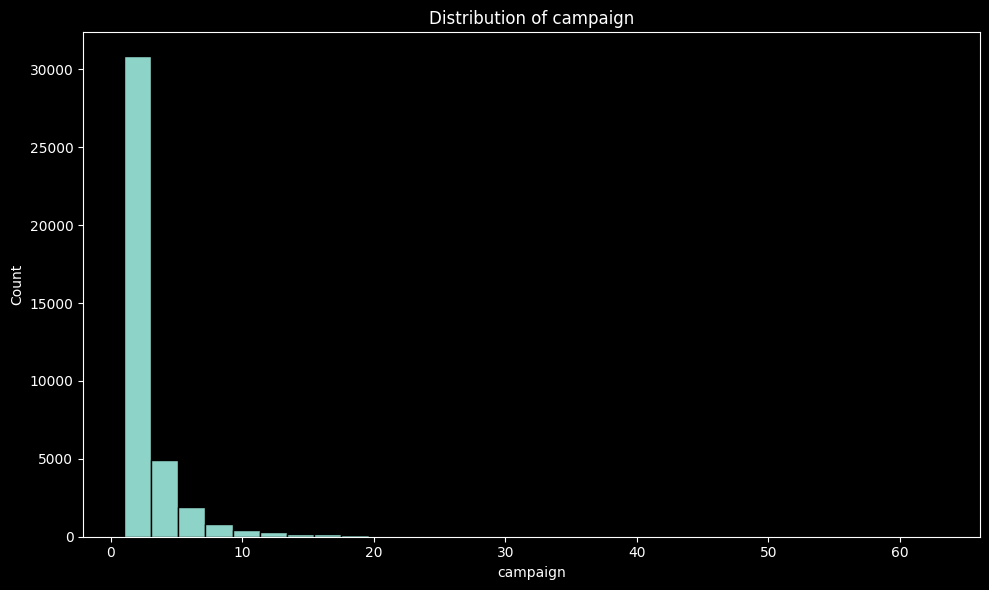

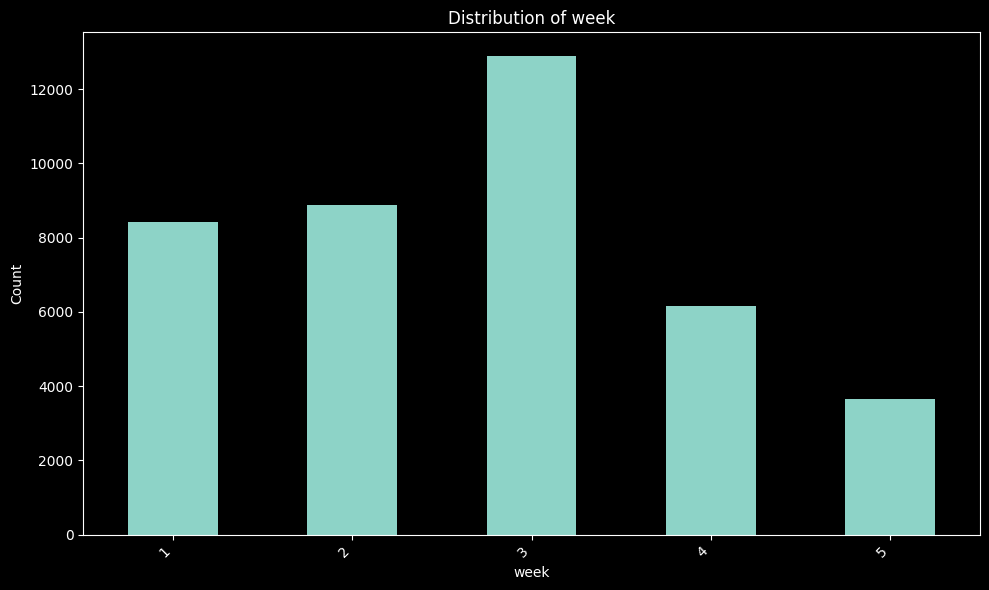

In [13]:
# use plotly to create interactive visualizations

plot_individual_features(customer_df, input_features)

## Chapter 5: The Imbalance Revelation ⚖️

A critical discovery: our dataset isn't balanced! This is the classic tale of imbalanced classes...

### Percentage distribution

In [14]:
# percentage distribution

calculate_class_distribution(target_variable)

Total samples: 40000
Class 0: 37104 (92.76%)
Class 1: 2896 (7.24%)


{0: {'count': 37104, 'percentage': 92.75999999999999},
 1: {'count': 2896, 'percentage': 7.24}}

### Leveling the playing field


To fight imbalance, we wield the weapon of class weights - giving minority class a voice!


In [15]:
## calculating class weights to handle class imbalance

compute_class_weights_balanced(target_variable)

Class weights: {0: np.float64(0.5390254420008624), 1: np.float64(6.906077348066298)}


{0: np.float64(0.5390254420008624), 1: np.float64(6.906077348066298)}

## 📉 The Imbalance Challenge


Our graph reveals an uncomfortable truth: the dataset is heavily imbalanced, with far more customers declining than subscribing to term deposits.- **Class weighting** to amplify the importance of rare positive cases

- **Undersampling** the majority class (non-subscribers)

This imbalance isn't just a statistical quirk - it's a real-world phenomenon that demands careful handling. We'll need to address this during model training using techniques like:- **Oversampling** the minority class (subscribers)

In [16]:
customer_df[categorical_features].describe()

,job,marital,education,default,housing,loan,contact,month
count,40000,40000,40000,40000,40000,40000,40000,40000
unique,12,3,4,2,2,2,3,11
top,blue-collar,married,secondary,no,yes,no,cellular,may
freq,9383,24386,20993,39191,24031,33070,24914,13532


In [17]:
customer_df[categorical_features].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        11
dtype: int64

### Seasonal patterns: When do campaigns succeed?


Time has its own rhythm in marketing. Let's decode the monthly patterns...

In [18]:
monthname = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
for month in monthname:
    print(f"{month}: {input_features[input_features['month'] == month]['month'].value_counts().get(month, 0)}")

jan: 1176
feb: 2296
mar: 258
apr: 2718
may: 13532
jun: 4734
jul: 6380
aug: 5215
sep: 0
oct: 80
nov: 3598
dec: 13
oct: 80
nov: 3598
dec: 13


### The curious case of missing September 🍂


September remains silent in our dataset - a ghost month with no entries!


In [19]:
## there are no entries for september
input_features['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr'], dtype=object)

## Chapter 6: The Art of Feature Engineering 🔧

#### **Feature engineering**

Raw data is like uncut diamonds. Now comes the craftsmanship - transforming and creating features that truly shine!

In [20]:

# converting day to week

convert_day_to_week(input_features, day_column='day', week_column='week')
input_features['week'].value_counts()

week
3    12887
2     8880
1     8423
4     6162
5     3648
Name: count, dtype: int64

### converting month to quarter


In [21]:
# converting month to quarter
convert_month_to_quarter(input_features, month_column='month', quarter_column='quarter')
input_features['quarter'].value_counts(dropna=False)


quarter
2    20984
3    11595
1     3730
4     3691
Name: count, dtype: int64

### add week and quarter to categorical features


In [22]:
### add week and quarter to categorical features
categorical_features.append('week')
categorical_features.append('quarter')

### Financial fingerprints: Creating wealth & debt indicators 💰

Let's craft features that capture financial health - high balances and loan burdens paint distinct customer portraits...

### Creating new features is_high_balance and loan_count

In [23]:
# creating new features is_high_balance and loan_count
is_high_balance = customer_df['balance'] > customer_df['balance'].median()
print(is_high_balance)
loan_count = customer_df['housing'].map({'yes':1, 'no':0}) + customer_df['loan'].map({'yes':1, 'no':0})
print(loan_count)

0         True
1        False
2        False
3         True
4        False
         ...  
39995    False
39996     True
39997    False
39998     True
39999     True
Name: balance, Length: 40000, dtype: bool
0        1
1        1
2        2
3        1
4        0
        ..
39995    0
39996    0
39997    0
39998    0
39999    1
Length: 40000, dtype: int64


### adding loan_count and is_high_balance to input features


In [24]:
## adding loan_count and is_high_balance to input features
input_features['is_high_balance'] = is_high_balance.astype(int)
input_features['loan_count'] = loan_count

### Campaign behavior signatures 📞

How customers respond to campaigns tells us volumes. Let's engineer features that capture engagement patterns...

### Adding campaign features

In [25]:
## adding campaign features
input_features['campaign_intensity'] = input_features['duration'] / (input_features['campaign'] + 1)
contacted_multiple_times = input_features['campaign'] > 1
input_features['contacted_multiple_times'] = contacted_multiple_times.astype(int)
is_last_call_long = input_features['duration'] > input_features['duration'].median()
input_features['is_last_call_long'] = is_last_call_long.astype(int)


### Life stage categorization: The age story 👶➡️👴

Age isn't just a number - it's a life stage. Let's group customers by their journey through life...

### Adding age binning

In [26]:
## adding age binning
age_bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
age_labels = ['<18', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
input_features['age_group'] = pd.cut(input_features['age'], bins=age_bins, labels=age_labels, right=False)


In [27]:
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
input_features['month_num'] = input_features['month'].map(month_map)
input_features['is_quarter_end'] = input_features['month_num'].isin([3,6,9,12]).astype(int)



In [28]:
## has any loan
has_loan = ((input_features['housing'] == 'yes') | (input_features['loan'] == 'yes')).astype(int)

## education & job
education_job = input_features['education'] + "_" + input_features['job']

In [29]:
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
input_features['month_num'] = input_features['month'].map(month_map)
input_features['is_quarter_end'] = input_features['month_num'].isin([3,6,9,12]).astype(int)


In [30]:
## adding new features to input_features
#input_features['age_group'] = age_group
input_features['has_loan'] = has_loan
input_features['education_job'] = education_job
input_features['month_num'] = input_features['month_num']
input_features['is_quarter_end'] = input_features['is_quarter_end']
input_features.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'week',
       'quarter', 'is_high_balance', 'loan_count', 'campaign_intensity',
       'contacted_multiple_times', 'is_last_call_long', 'age_group',
       'month_num', 'is_quarter_end', 'has_loan', 'education_job'],
      dtype='object')

### merge input features and target variable for plotting


In [31]:
# merge input features and target variable for plotting
customer_df_updated = pd.concat([input_features, target_variable], axis=1)

In [32]:
customer_df_updated.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'week',
       'quarter', 'is_high_balance', 'loan_count', 'campaign_intensity',
       'contacted_multiple_times', 'is_last_call_long', 'age_group',
       'month_num', 'is_quarter_end', 'has_loan', 'education_job', 'y'],
      dtype='object')

### Visualizing our newly crafted features ✨

Time to see if our feature engineering pays off! Do these new features reveal clearer patterns?



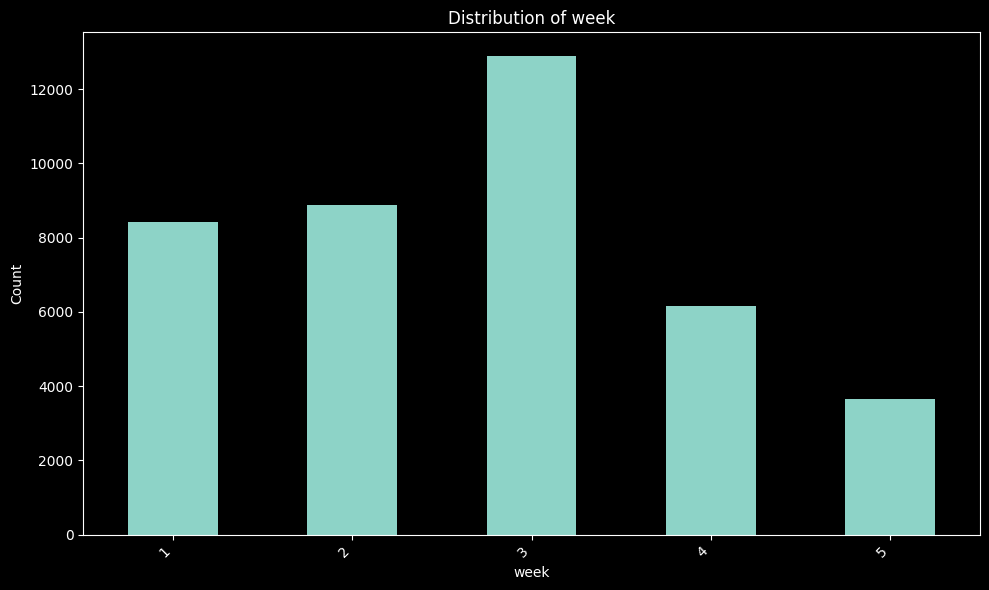

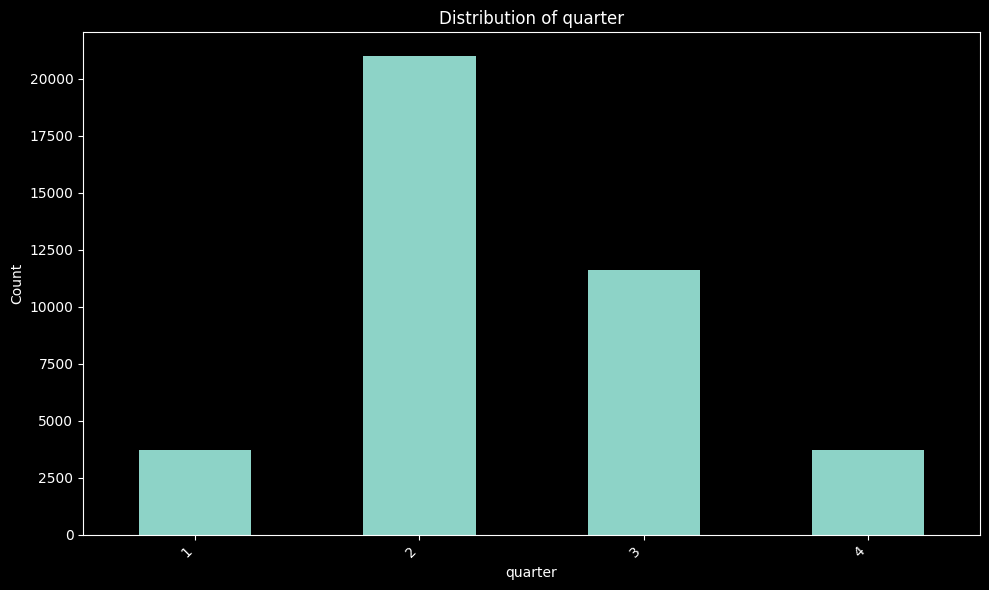

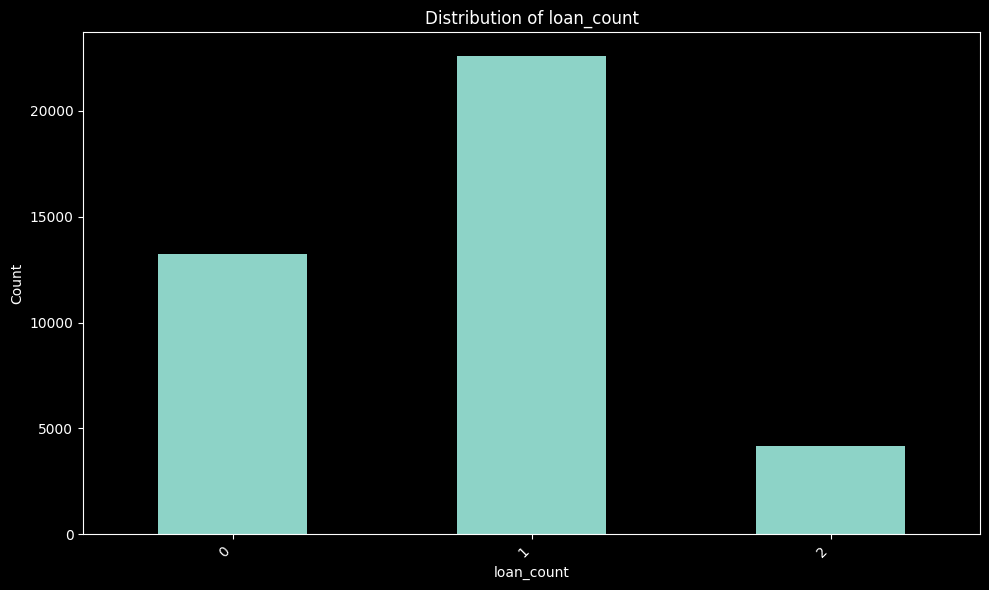

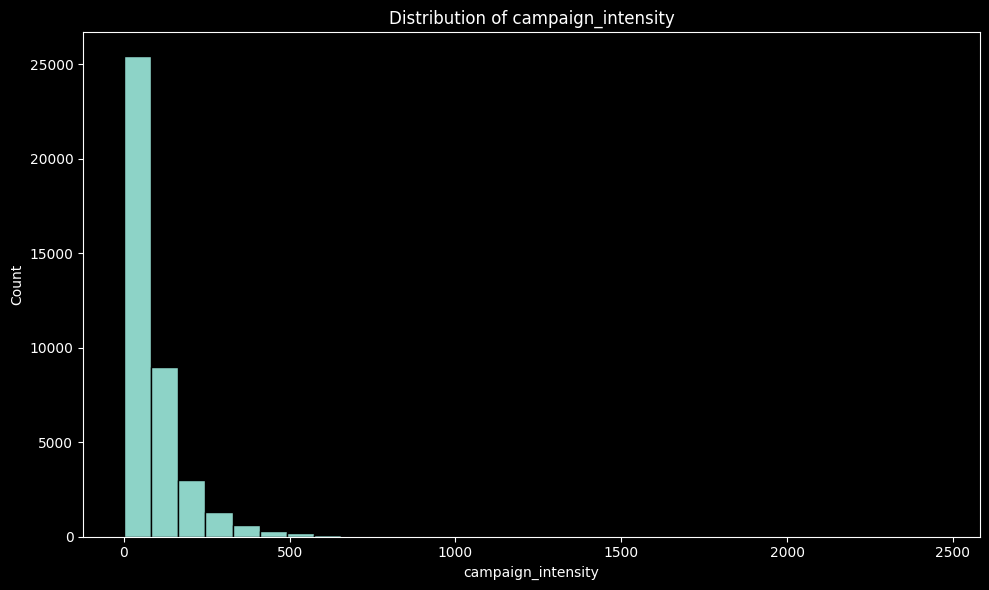

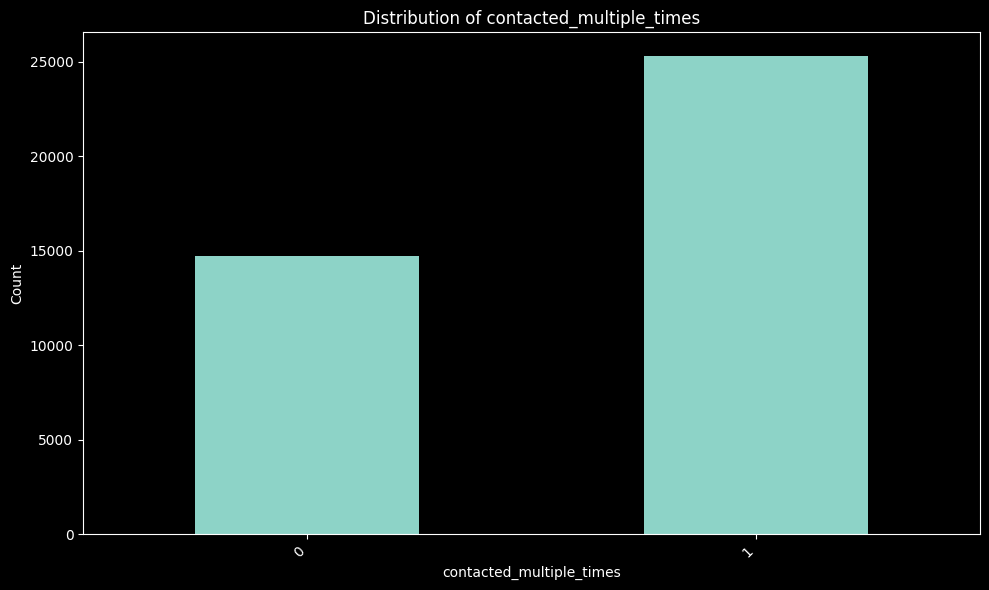

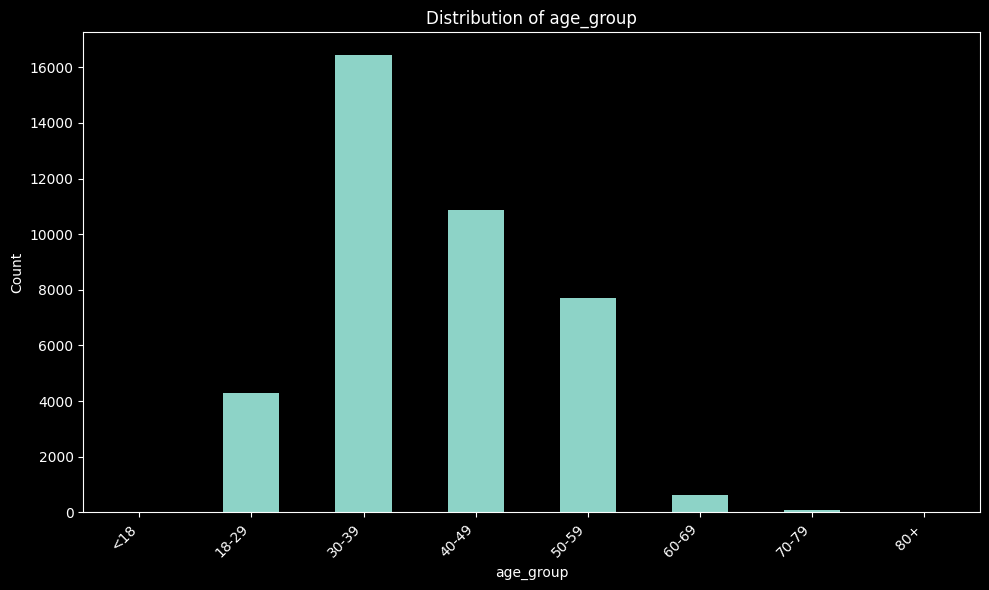

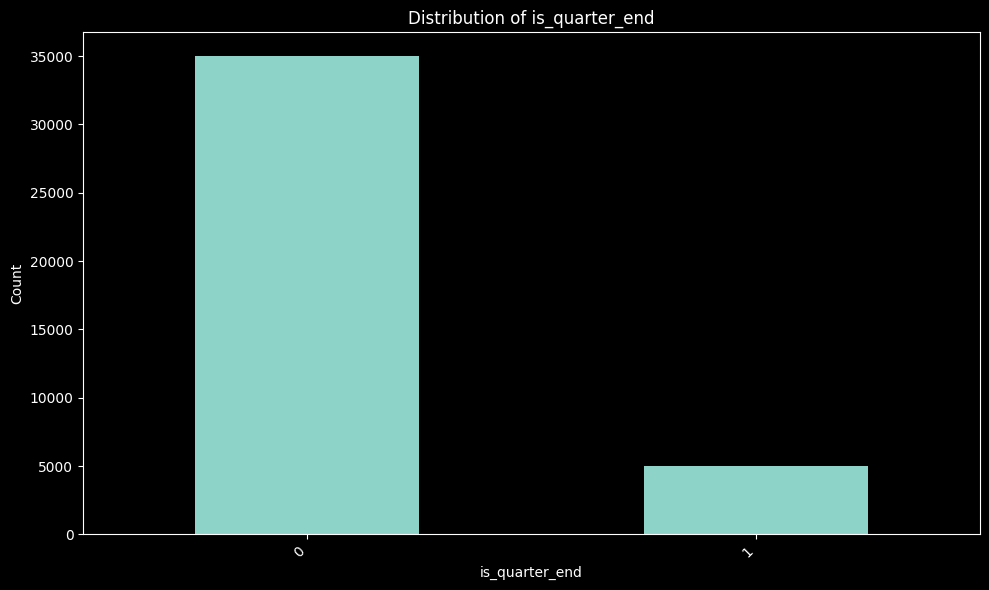

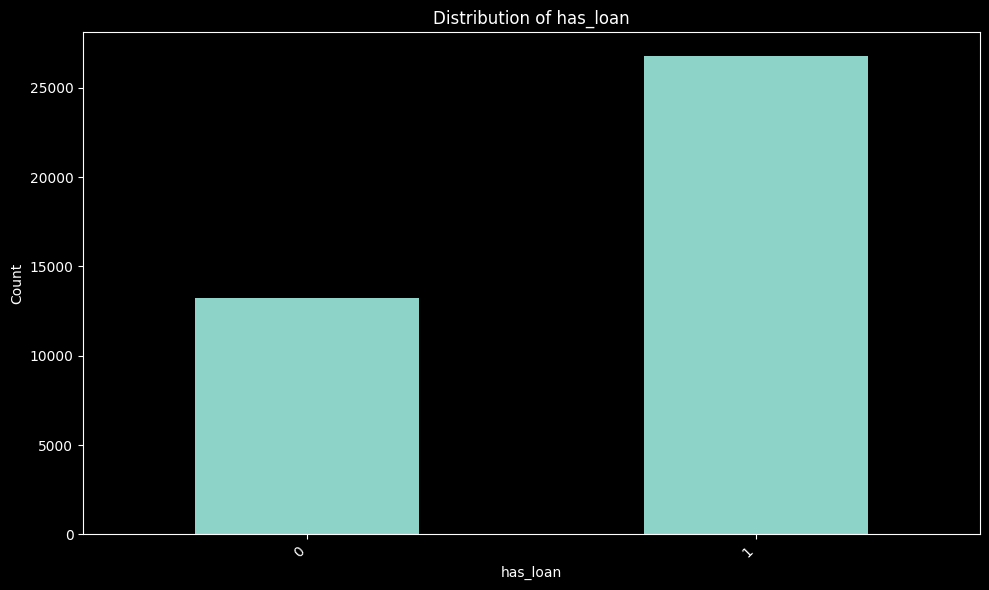

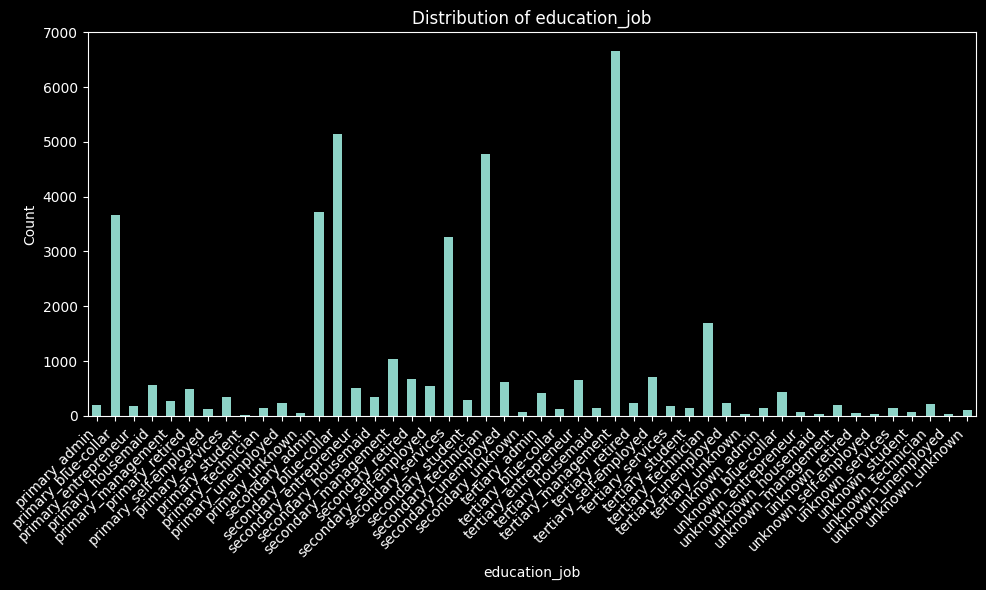

In [33]:
# for col in customer_df_updated.columns:
#     fig = px.histogram(customer_df_updated, x=col, title=f'Distribution of {col}', marginal="box")
#     fig.show()
#     fig.write_image(f'../../reports/figures/distribution_of_{col}_updated.png') 

#plot_individual_features(customer_df_updated, features=customer_df_updated.columns.tolist())
plot_individual_features(customer_df_updated, features=['week',
       'quarter', 'loan_count', 'campaign_intensity',
       'contacted_multiple_times', 'age_group',
        'is_quarter_end', 'has_loan', 'education_job'])

### few important things to note about these new features with regards to customer subscription
- week 3 of month & quarter 2 seems to have highest number of subscriptions.
- people having one loan tend to get subscription.
- campaign intensity plays an important role in customer subscriptions.
- age group 30 - 39 have the highest tendency to get the subscription. 

### separating features again


In [34]:
## separating features again
numerical_features_updated = input_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_updated = input_features.select_dtypes(include=['object', 'category']).columns.tolist()


## Chapter 7: Preparing for Battle - The Preprocessing Arsenal ⚔️

### Setting up preprocessors using standard scaler for numeric columns and onehotencoder for categorical columns

Before our machine learning models can work their magic, we must transform our data into a language they understand.

In [35]:
## setting up preprocessors
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
binary_transformer = LabelEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features_updated),
        ('cat', categorical_transformer, categorical_features_updated)
        
    ]
)

### The sacred split: Train, Validate, Test 📊


Like a proper scientific experiment, we divide our data into three chambers - 70% for training, 15% for validation, and 15% for the final test.### TRAIN / VAL / TEST SPLIT (70 / 15 / 15)


In [36]:
# TRAIN / VAL / TEST SPLIT  (70 / 15 / 15)
X_train, X_temp, y_train, y_temp = train_test_split(
    input_features, target_variable, test_size=0.30, random_state=42, stratify=target_variable
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)


In [37]:
target_variable.unique()

array([0, 1])

In [38]:
customer_df['y'].value_counts()

y
no     37104
yes     2896
Name: count, dtype: int64

In [39]:
# calculate class weights for handling class imbalance
total = len(customer_df['y'])
# compute counts for each class (y contains 'yes'/'no' strings)
yes_count = (customer_df['y'] == 'yes').sum()
no_count = (customer_df['y'] == 'no').sum()

# avoid division by zero
if yes_count == 0 or no_count == 0:
    raise ValueError("One of the classes has zero samples; cannot compute class weights.")

# balanced class weights using sklearn formula: n_samples / (n_classes * n_samples_for_class)
cw_yes = total / (2 * yes_count)
print(f"Total samples: {total}")
print(f"Yes count: {yes_count}, No count: {no_count}")
print(f"Class weight for 'yes': {cw_yes:.2f}")
# class weight of no
cw_no = total / (2 * no_count)
print(f"Class weight for 'no': {cw_no:.2f}")

# Create dictionary for use in models
class_weight_dict = {'no': cw_no, 'yes': cw_yes}
print(f"\nClass weight dictionary: {class_weight_dict}")

Total samples: 40000
Yes count: 2896, No count: 37104
Class weight for 'yes': 6.91
Class weight for 'no': 0.54

Class weight dictionary: {'no': np.float64(0.5390254420008624), 'yes': np.float64(6.906077348066298)}


## Chapter 8: The Model Tournament Begins! 🏆

Now the real excitement begins! We'll pit multiple machine learning algorithms against each other, each competing to best predict customer subscriptions.

### Train logistic regression model

**First Contestant: Logistic Regression** - The classic, interpretable champion. Simple yet powerful!

Logistic regression Classifier Results:
Accuracy score: 0.9288333333333333
Precision score: 0.7058823529411765
Recall score: 0.027649769585253458
F1 score: 0.05321507760532151
classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      5566
           1       0.71      0.03      0.05       434

    accuracy                           0.93      6000
   macro avg       0.82      0.51      0.51      6000
weighted avg       0.91      0.93      0.90      6000



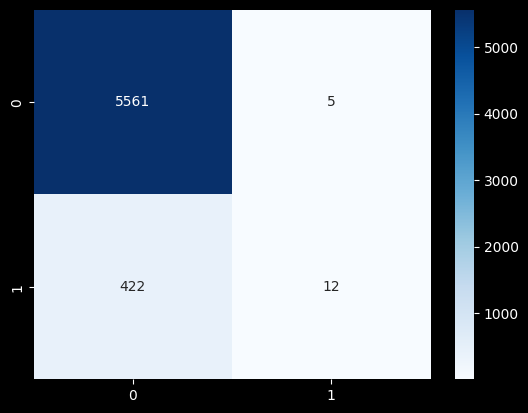

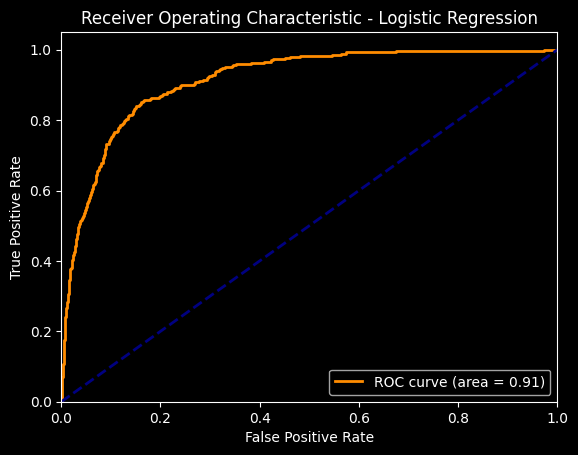

In [40]:
### train logistic regression model

# rebuild preprocessor to reflect the cleaned categorical_features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features_updated),
        ('cat', categorical_transformer, categorical_features_updated)
    ]
)
#class_weight_dict = {'no': 1.0, 'yes': 6.0}  # keeping class weight of no as 1.0
class_weight_dict = {1: 1.0, 0: 6.0}
model_lr = LogisticRegression(class_weight=class_weight_dict, max_iter=1000, random_state=42)
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model_lr)])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
print("Logistic regression Classifier Results:")
print('Accuracy score:', accuracy_score(y_test, y_pred_lr))
print('Precision score:', precision_score(y_test, y_pred_lr))
print('Recall score:', recall_score(y_test, y_pred_lr))
print('F1 score:', f1_score(y_test, y_pred_lr))
print('classification report:\n', classification_report(y_test, y_pred_lr))
## plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
## ROC & AUC
from sklearn.metrics import roc_curve, auc
y_pred_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


### using knn classifier : second one in the contest!


KNN Classifier Results:
Accuracy score: 0.9315
Precision score 0.5473251028806584
Recall score 0.3064516129032258
Confusion Matrix:
 [[5456  110]
 [ 301  133]]
classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      5566
           1       0.55      0.31      0.39       434

    accuracy                           0.93      6000
   macro avg       0.75      0.64      0.68      6000
weighted avg       0.92      0.93      0.92      6000



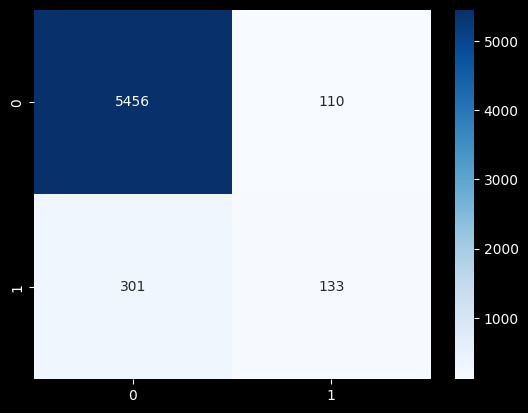

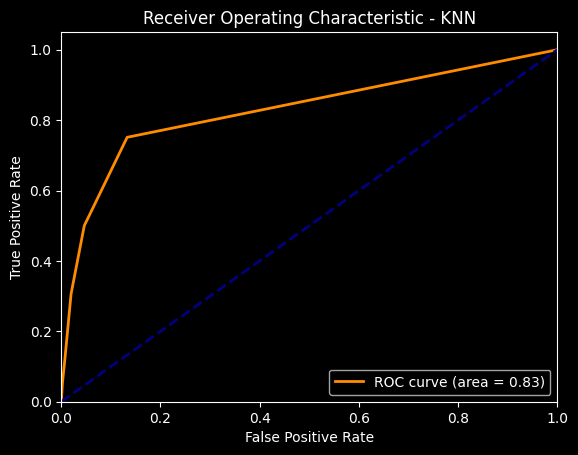

In [41]:
### using knn classifier
class_weight_dict = {0: 1.0, 1: 6} 
weight_val ='6'

model_knn = KNeighborsClassifier(weights='uniform', n_neighbors=5)
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model_knn)])
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)
print("KNN Classifier Results:")
print('Accuracy score:', accuracy_score(y_test, y_pred_knn))
print('Precision score', precision_score(y_test, y_pred_knn))
print('Recall score', recall_score(y_test, y_pred_knn))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_knn))
print('classification report:\n', classification_report(y_test, y_pred_knn))
## plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
## ROC & AUC
from sklearn.metrics import roc_curve, auc
y_pred_proba_knn = pipeline_knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - KNN')
plt.legend(loc="lower right")
plt.show()


### train Random Forest Classifier - the 3rd one!


Random Forest Classifier Results:
Accuracy score: 0.9335
Precision score 0.5845410628019324
Recall score 0.27880184331797236
Confusion Matrix:
 [[5480   86]
 [ 313  121]]
classification report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      5566
           1       0.58      0.28      0.38       434

    accuracy                           0.93      6000
   macro avg       0.77      0.63      0.67      6000
weighted avg       0.92      0.93      0.92      6000



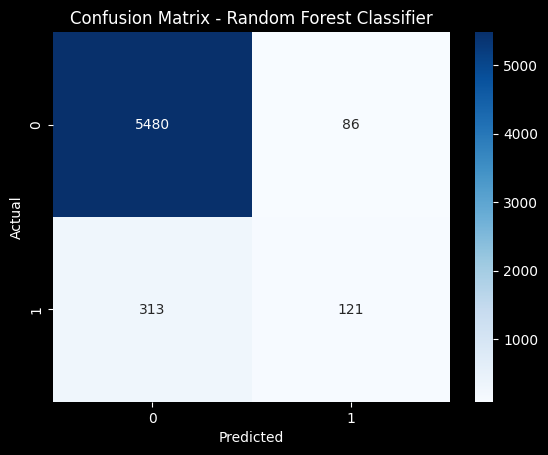

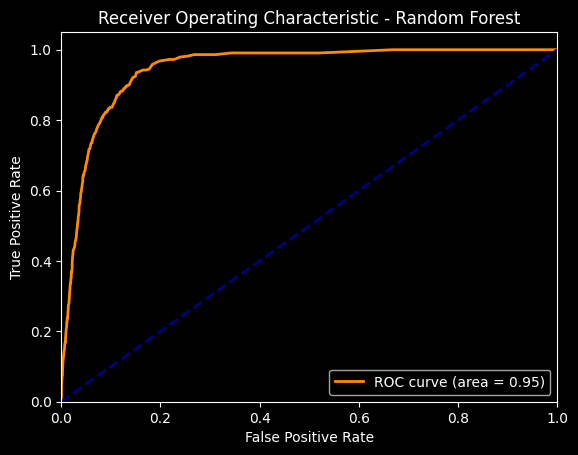

In [42]:
## train Random Forest Classifier
class_weight_dict = {0: 1.0, 1: 5}  # keeping class weight of no as 1.0
model_rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight=class_weight_dict)
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_rf)])
### predict the test set results
pipeline_rf.fit (X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
print("Random Forest Classifier Results:")
print('Accuracy score:', accuracy_score(y_test, y_pred_rf))
print('Precision score', precision_score(y_test, y_pred_rf))
print('Recall score', recall_score(y_test, y_pred_rf))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))
print('classification report:\n', classification_report(y_test, y_pred_rf))
## plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
## ROC & AUC
from sklearn.metrics import roc_curve, auc
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

### Fourth Contender: XGBoost ⚡

The gradient boosting powerhouse - iteratively learning from mistakes to achieve perfection! XGBoost has dominated ML competitions worldwide with its speed and accuracy.

### Train XGBoost Classifier

XGBoost Classifier Results:
Accuracy score: 0.9256666666666666
Precision score 0.4878048780487805
Recall score 0.5529953917050692
Confusion Matrix:
 [[5314  252]
 [ 194  240]]
classification report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      5566
           1       0.49      0.55      0.52       434

    accuracy                           0.93      6000
   macro avg       0.73      0.75      0.74      6000
weighted avg       0.93      0.93      0.93      6000



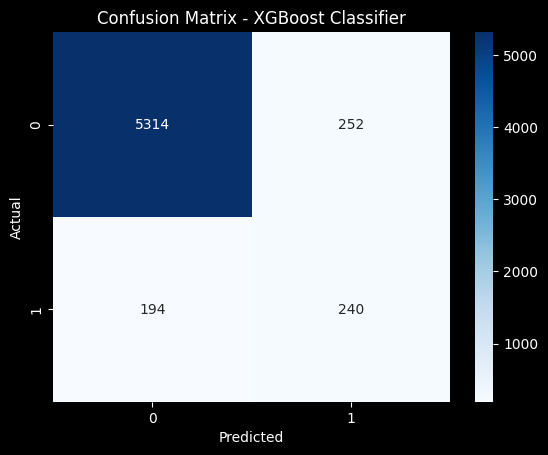

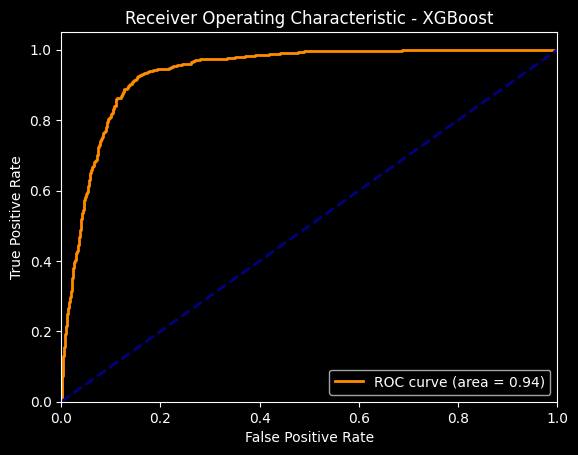

In [43]:
## train xgboost Classifier
model_xgb = xgb(n_estimators=300, random_state=42, scale_pos_weight=6,
                max_depth=6)
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_xgb)])
### predict the test set results
pipeline_xgb.fit (X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)
print("XGBoost Classifier Results:")
print('Accuracy score:', accuracy_score(y_test, y_pred_xgb))
print('Precision score', precision_score(y_test, y_pred_xgb))
print('Recall score', recall_score(y_test, y_pred_xgb))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_xgb))
print('classification report:\n', classification_report(y_test, y_pred_xgb))
## plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
## ROC & AUC
from sklearn.metrics import roc_curve, auc
y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc="lower right")
plt.show()

### Fifth Gladiator: LightGBM 💡

The lightning-fast gradient booster - speed meets accuracy!


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 2027, number of negative: 25973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.318920 -> initscore=-0.758741
[LightGBM] [Info] Start training from score -0.758741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
LightGBM Classifier Results:
Accuracy score: 0.9163333333333333
Precision score 0.45170454545454547
Recall score 0.7327188940092166
Confusion Matrix:
 [[5180  386]
 [ 116  318]]
classification report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95      5566
           1       0.45      0.73      0.56       434

    accuracy                           0.92      6000
   macro avg       0.71      0.83      0.76      6000
weighted avg       0.94      0.92      0.93      6000



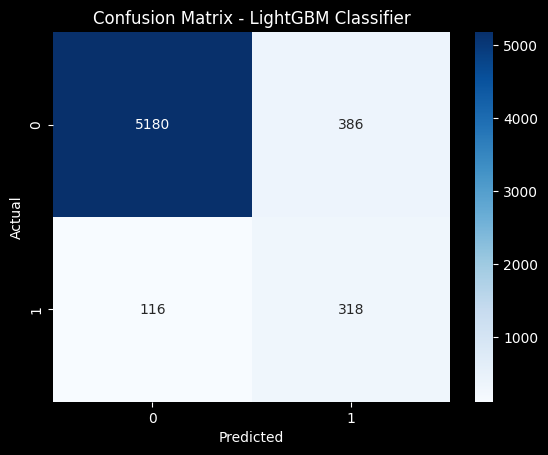

c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


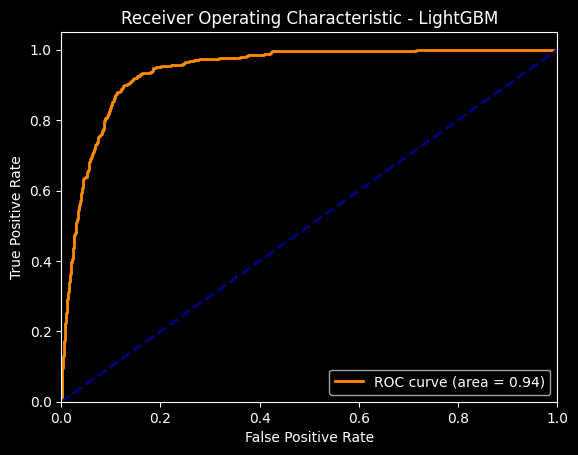

In [44]:
### using lightgbm classifier
import lightgbm as lgb
class_weight_dict = {0: 1.0, 1: 6}  # keeping class weight of no as 1.0
model_lgb = lgb.LGBMClassifier(n_estimators=300, random_state=42
, class_weight=class_weight_dict, max_depth=6, num_leaves=31, min_data_in_leaf=20, min_split_gain=0.0)
pipeline_lgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_lgb)])
### predict the test set results
pipeline_lgb.fit (X_train, y_train)
y_pred_lgb = pipeline_lgb.predict(X_test)
print("LightGBM Classifier Results:")
print('Accuracy score:', accuracy_score(y_test, y_pred_lgb))
print('Precision score', precision_score(y_test, y_pred_lgb))
print('Recall score', recall_score(y_test, y_pred_lgb))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_lgb))
print('classification report:\n', classification_report(y_test, y_pred_lgb))
## plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LightGBM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
## ROC & AUC
from sklearn.metrics import roc_curve, auc
y_pred_proba_lgb = pipeline_lgb.predict_proba(X_test)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
plt.figure()
plt.plot(fpr_lgb, tpr_lgb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LightGBM')
plt.legend(loc="lower right")
plt.show()





### Sixth Competitor: Decision Tree 🌳

The single tree - simple, visual, and interpretable (but prone to overfitting!)


Decision Tree Classifier Results:
Accuracy score: 0.8981666666666667
Precision score 0.39792387543252594
Recall score 0.7949308755760369
Confusion Matrix:
 [[5044  522]
 [  89  345]]
classification report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94      5566
           1       0.40      0.79      0.53       434

    accuracy                           0.90      6000
   macro avg       0.69      0.85      0.74      6000
weighted avg       0.94      0.90      0.91      6000



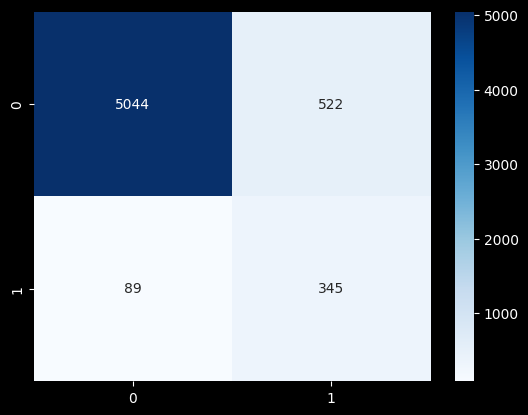

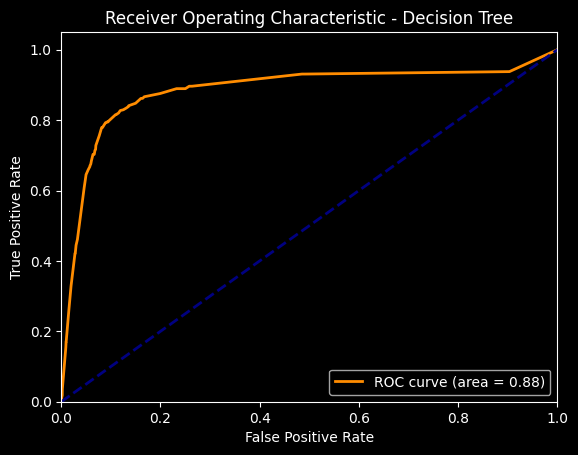

In [45]:
### using decision tree classifier
class_weight_dict = {0: 1.0, 1: 6}  # keeping class weight of no as 1.0
model_dt = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict,max_depth=8)
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_dt)])
pipeline_dt.fit(X_train, y_train)
y_pred_dt = pipeline_dt.predict(X_test)
print("Decision Tree Classifier Results:")
print('Accuracy score:', accuracy_score(y_test, y_pred_dt))
print('Precision score', precision_score(y_test, y_pred_dt))
print('Recall score', recall_score(y_test, y_pred_dt))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_dt))
print('classification report:\n', classification_report(y_test, y_pred_dt))
## plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
## ROC & AUC
from sklearn.metrics import roc_curve, auc
y_pred_proba_dt = pipeline_dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.legend(loc="lower right")
plt.show()

### Seventh Champion: CatBoost 🐱

The categorical features specialist - handles categories like a boss!


CatBoost Classifier Results:
Accuracy score: 0.9116666666666666
Precision score 0.43908629441624364
Recall score 0.7972350230414746
Confusion Matrix:
 [[5124  442]
 [  88  346]]
classification report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95      5566
           1       0.44      0.80      0.57       434

    accuracy                           0.91      6000
   macro avg       0.71      0.86      0.76      6000
weighted avg       0.94      0.91      0.92      6000



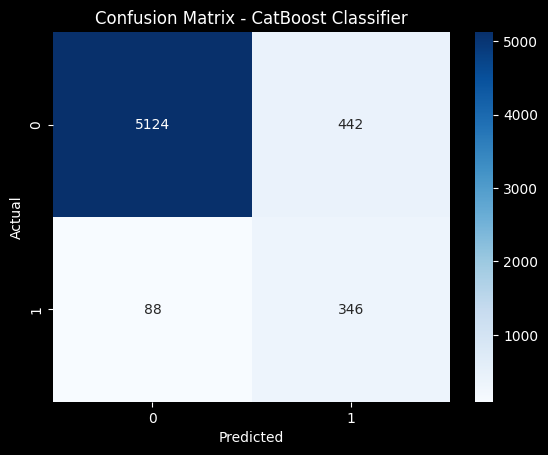

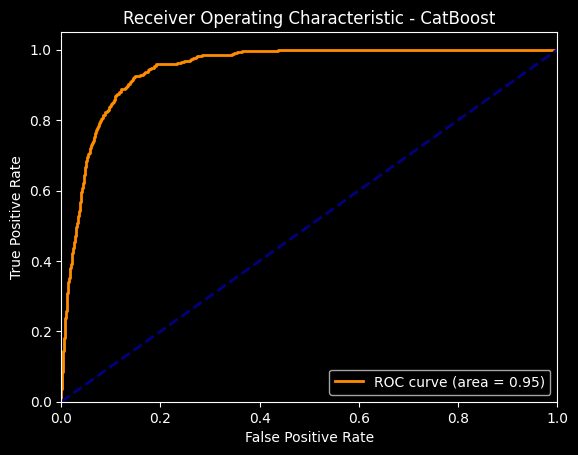

In [46]:
### using catboost classifier
class_weight_dict = {0: 1.0, 1: 6}  # keeping class weight of no as 1.0
model_cat = CatBoostClassifier(iterations=300, random_state=42, class_weights=class_weight_dict, depth=6, learning_rate=0.1, verbose=0)
pipeline_cat = Pipeline(steps=[('preprocessor', preprocessor), 
                              ('classifier', model_cat)])
pipeline_cat.fit(X_train, y_train)
y_pred_cat = pipeline_cat.predict(X_test)
print("CatBoost Classifier Results:")
print('Accuracy score:', accuracy_score(y_test, y_pred_cat))
print('Precision score', precision_score(y_test, y_pred_cat))
print('Recall score', recall_score(y_test, y_pred_cat))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_cat))
print('classification report:\n', classification_report(y_test, y_pred_cat))
## plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CatBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
## ROC & AUC
from sklearn.metrics import roc_curve, auc
y_pred_proba_cat = pipeline_cat.predict_proba(X_test)[:, 1]
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_pred_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)
plt.figure()
plt.plot(fpr_cat, tpr_cat, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cat)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - CatBoost')
plt.legend(loc="lower right")
plt.show()

In [47]:
for model in [pipeline_lr, pipeline_knn, pipeline_rf, pipeline_xgb, pipeline_lgb, pipeline_dt, pipeline_cat]:
    model_name = type(model.named_steps['classifier']).__name__
    evaluate_model(model, X_test, y_test, model_name=model_name)



LogisticRegression Evaluation:
Accuracy: 0.9288
Precision: 0.7059
Recall: 0.0276
F1-Score: 0.0532

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5566
           1       0.71      0.03      0.05       434

    accuracy                           0.93      6000
   macro avg       0.82      0.51      0.51      6000
weighted avg       0.91      0.93      0.90      6000


KNeighborsClassifier Evaluation:
Accuracy: 0.9315
Precision: 0.5473
Recall: 0.3065
F1-Score: 0.3929

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      5566
           1       0.55      0.31      0.39       434

    accuracy                           0.93      6000
   macro avg       0.75      0.64      0.68      6000
weighted avg       0.92      0.93      0.92      6000


KNeighborsClassifier Evaluation:
Accuracy: 0.9315
Precision: 0.5473
Recall: 0.3065
F1-Score: 0.39

c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

LGBMClassifier Evaluation:
Accuracy: 0.9163
Precision: 0.4517
Recall: 0.7327
F1-Score: 0.5589

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      5566
           1       0.45      0.73      0.56       434

    accuracy                           0.92      6000
   macro avg       0.71      0.83      0.76      6000
weighted avg       0.94      0.92      0.93      6000


DecisionTreeClassifier Evaluation:
Accuracy: 0.8982
Precision: 0.3979
Recall: 0.7949
F1-Score: 0.5304

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      5566
           1       0.40      0.79      0.53       434

    accuracy                           0.90      6000
   macro avg       0.69      0.85      0.74      6000
weighted avg       0.94      0.90

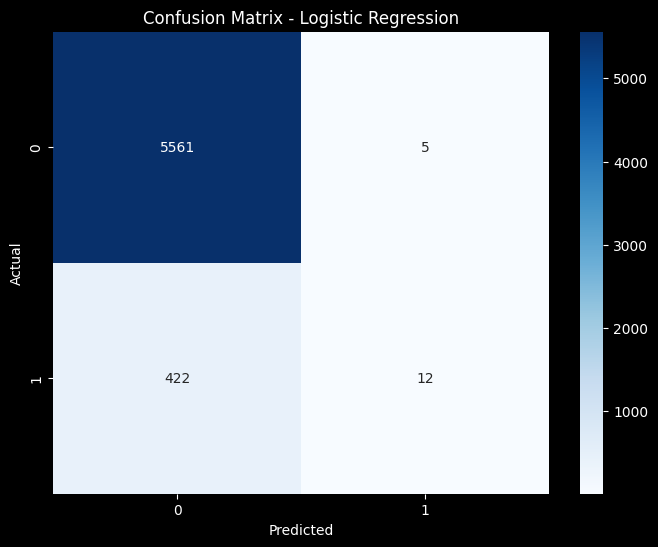

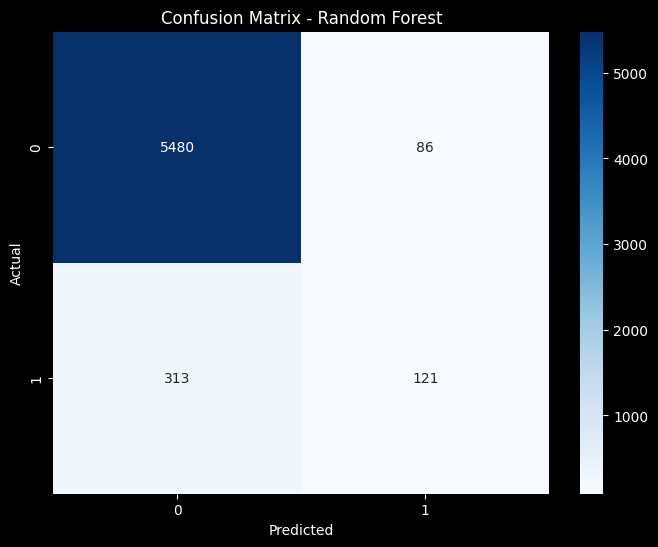

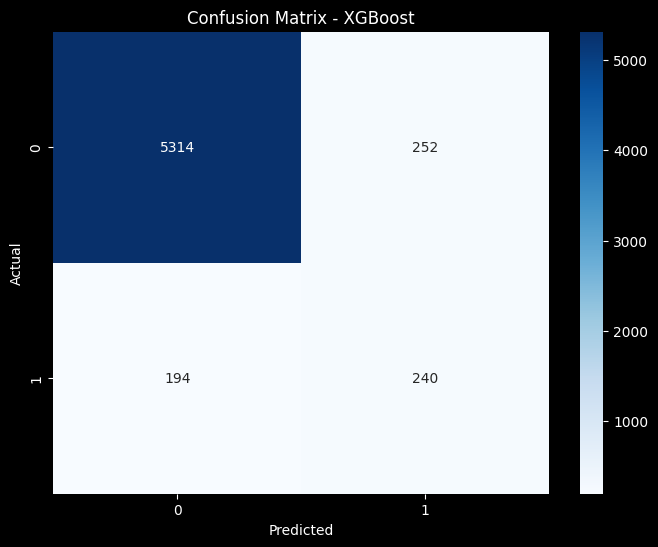

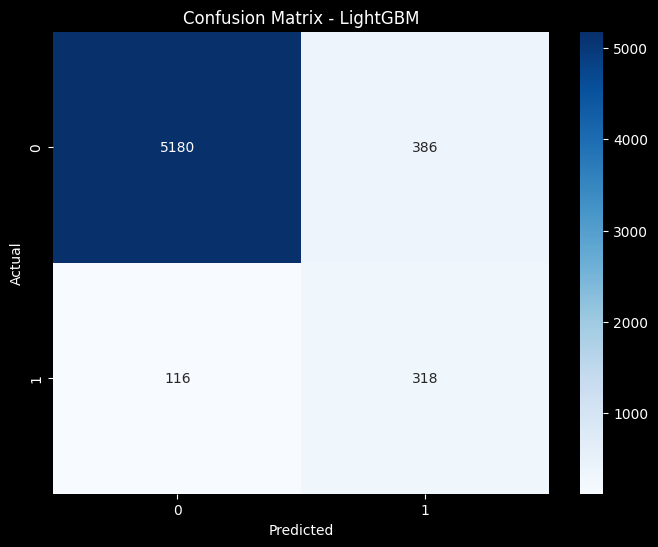

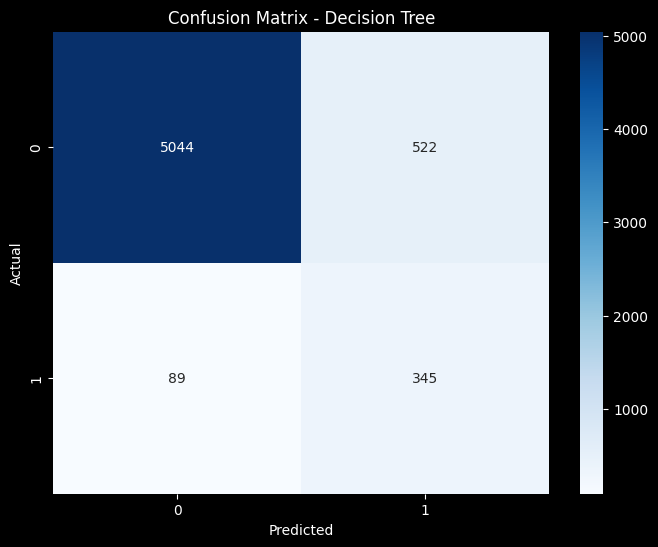

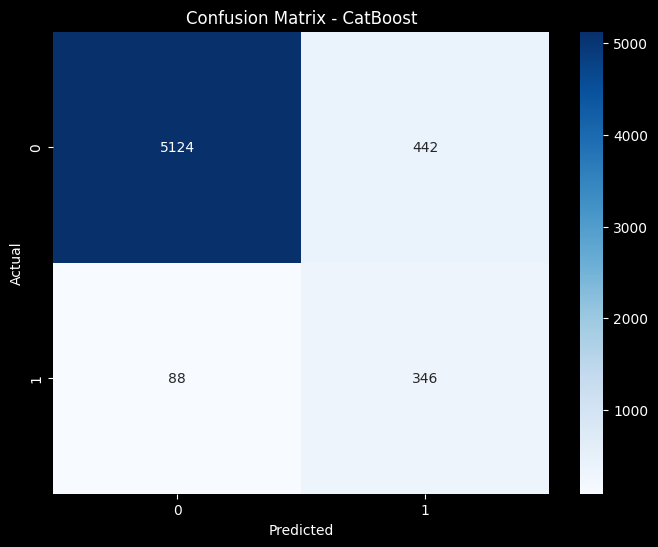

In [48]:
### plot confusion matrices for all models in a single figure
# Model names and predictions
models_info = [
    ("Logistic Regression", y_pred_lr),
    ("Random Forest", y_pred_rf),
    ("XGBoost", y_pred_xgb),
    ("LightGBM", y_pred_lgb),
    ("Decision Tree", y_pred_dt),
    ("CatBoost", y_pred_cat)
]

# Plot confusion matrix for each model
for model_name, y_pred in models_info:
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, title=f"Confusion Matrix - {model_name}")

## 🏅 The Grand Comparison: Who Wins the Crown?

The moment of truth! Let's see which model reigns supreme in the battle for AUC scores...

### Plotting using AUC scores

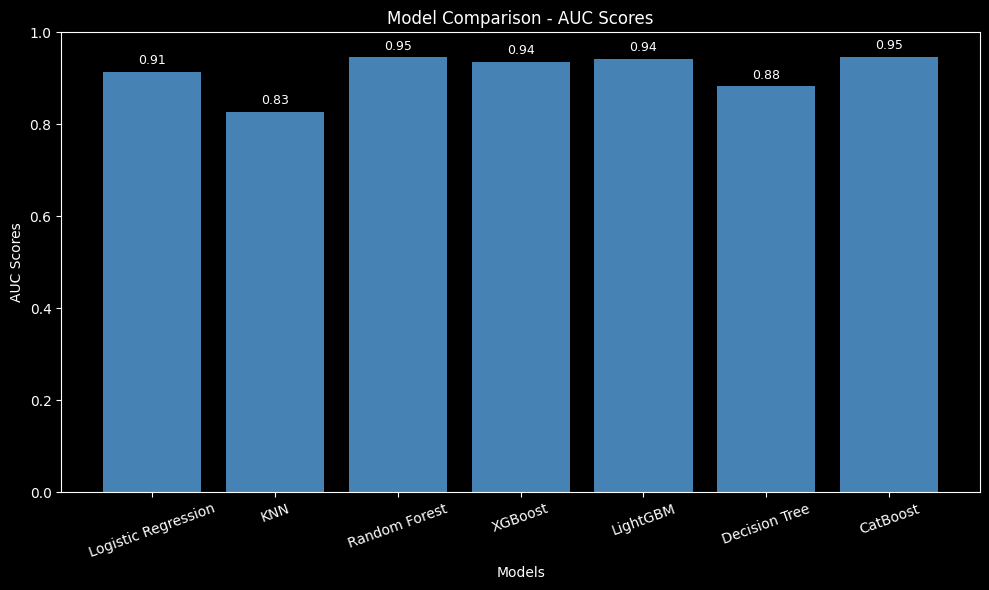

In [71]:
### model comparison - AUC scores
# Fixed bar plot for AUC comparison
models = ['Logistic Regression', 'KNN', 'Random Forest', 'XGBoost', 'LightGBM', 'Decision Tree', 'CatBoost']
roc_auc = [roc_auc_lr, roc_auc_knn, roc_auc_rf, roc_auc_xgb, roc_auc_lgb, roc_auc_dt, roc_auc_cat]
plt.figure(figsize=(10, 6))
bars = plt.bar(models, roc_auc, color='steelblue')
plt.xlabel('Models')
plt.ylabel('AUC Scores')
plt.title('Model Comparison - AUC Scores')
plt.ylim(0, 1.0)
plt.xticks(rotation=20)
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.01, f'{h:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

## Chapter 9: Feature Importance - What Really Matters? 🔍

Not all features are created equal! Let's discover which variables hold the real predictive power...

### Feature selection using random forest

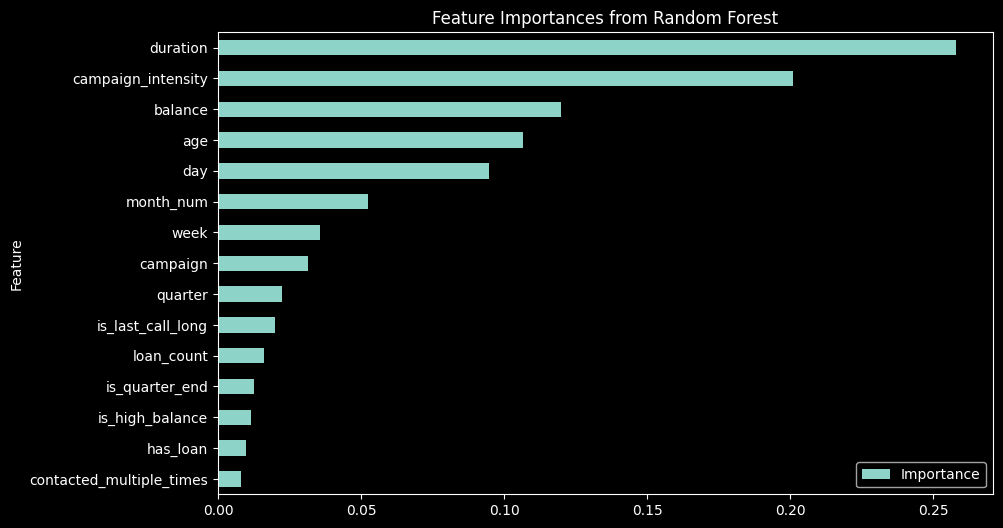

<Figure size 640x480 with 0 Axes>

In [58]:
### feature selection using random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(input_features.select_dtypes(include=[np.number]), target_variable)
importances = rf.feature_importances_
importances_df = pd.DataFrame({'Feature': input_features.select_dtypes(include=[np.number]).columns, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df.head(15).sort_values(by='Importance', ascending=True).plot(kind='barh', x='Feature', y='Importance', figsize=(10,6), title='Feature Importances from Random Forest')
plt.show()
##save feature importance plot
plt.savefig('../../reports/figures/feature_importances_random_forest.png')



### The top performers revealed! 🌟

These are the MVPs - the features that truly drive subscription decisions...

### Importance of top 6 features

In [ ]:
# importance of top 6 features
print(importances_df.head(6))


## 💎 The Power Players: Features That Drive Success

**The Critical Six:**
- 📞 **Duration of call** - The longer the conversation, the stronger the connection
- ⚡ **Campaign intensity** - Quality of engagement trumps quantity
- 💰 **Balance** - Financial capacity speaks volumes
- 👤 **Age of customer** - Life stage determines financial priorities
- 📅 **Month & Week** - Timing can make or break a campaign

### Pruning the dead wood 🪓

Time to be ruthless! Features with minimal importance only add noise. Let's remove them and see if our models improve...

### Remove features with low importance

In [77]:
### remove features with low importance
low_importance_features = importances_df[importances_df['Importance'] < 0.01]['Feature'].tolist()
print("Low importance features to be removed:", low_importance_features)

Low importance features to be removed: ['has_loan', 'contacted_multiple_times']


In [78]:
input_features_reduced = input_features.drop(columns=low_importance_features)
input_features_reduced.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'week',
       'quarter', 'is_high_balance', 'loan_count', 'campaign_intensity',
       'is_last_call_long', 'age_group', 'month_num', 'is_quarter_end',
       'education_job'],
      dtype='object')

In [79]:
updated_numerical_features_2 = input_features_reduced.select_dtypes(include=[np.number]).columns.tolist()
updated_categorical_features_2 = input_features_reduced.select_dtypes(include=['object', 'category']).columns.tolist()

### Rebuilding with our refined feature set 🔄

With deadweight removed, let's rebuild our preprocessing pipeline...

### Preprocessing steps with updated features

In [80]:

## preprocessing steps with updated features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
binary_transformer = LabelEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, updated_numerical_features_2),
        ('cat', categorical_transformer, updated_categorical_features_2)
        #('bin', binary_transformer, binary_features)
    ]
)

### Testing the refined model 🧪

Does less really equal more? Let's retrain LightGBM with our streamlined features...

### Using lightgbm classifier

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 2027, number of negative: 25973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.318920 -> initscore=-0.758741
[LightGBM] [Info] Start training from score -0.758741


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 2027, number of negative: 25973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.318920 -> initscore=-0.758741
[LightGBM] [Info] Start training from score -0.758741


c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
LightGBM Classifier Results:
Accuracy score: 0.9201666666666667
Precision score 0.46616541353383456
Recall score 0.7142857142857143
Confusion Matrix:
 [[5211  355]
 [ 124  310]]
classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      5566
           1       0.47      0.71      0.56       434

    accuracy                           0.92      6000
   macro avg       0.72      0.83      0.76      6000
weighted avg       0.94      0.92      0.93      6000



[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 2027, number of negative: 25973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.318920 -> initscore=-0.758741
[LightGBM] [Info] Start training from score -0.758741


c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
LightGBM Classifier Results:
Accuracy score: 0.9201666666666667
Precision score 0.46616541353383456
Recall score 0.7142857142857143
Confusion Matrix:
 [[5211  355]
 [ 124  310]]
classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      5566
           1       0.47      0.71      0.56       434

    accuracy                           0.92      6000
   macro avg       0.72      0.83      0.76      6000
weighted avg       0.94      0.92      0.93      6000



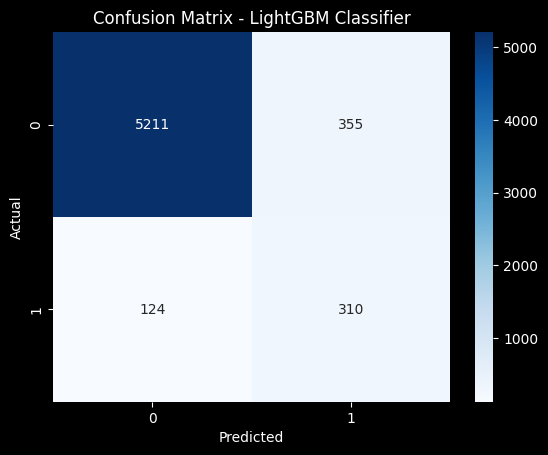

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 2027, number of negative: 25973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.318920 -> initscore=-0.758741
[LightGBM] [Info] Start training from score -0.758741


c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
LightGBM Classifier Results:
Accuracy score: 0.9201666666666667
Precision score 0.46616541353383456
Recall score 0.7142857142857143
Confusion Matrix:
 [[5211  355]
 [ 124  310]]
classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      5566
           1       0.47      0.71      0.56       434

    accuracy                           0.92      6000
   macro avg       0.72      0.83      0.76      6000
weighted avg       0.94      0.92      0.93      6000



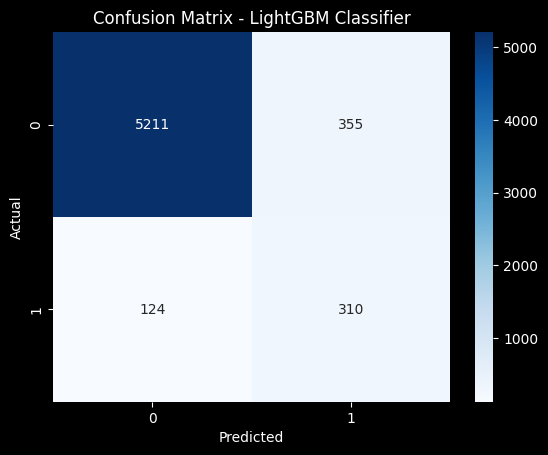

c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 2027, number of negative: 25973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.318920 -> initscore=-0.758741
[LightGBM] [Info] Start training from score -0.758741


c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
LightGBM Classifier Results:
Accuracy score: 0.9201666666666667
Precision score 0.46616541353383456
Recall score 0.7142857142857143
Confusion Matrix:
 [[5211  355]
 [ 124  310]]
classification report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      5566
           1       0.47      0.71      0.56       434

    accuracy                           0.92      6000
   macro avg       0.72      0.83      0.76      6000
weighted avg       0.94      0.92      0.93      6000



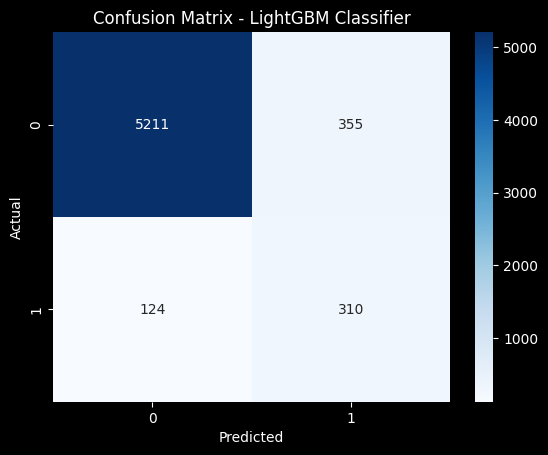

c:\Users\My-PC\miniconda3\envs\data_analysis\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


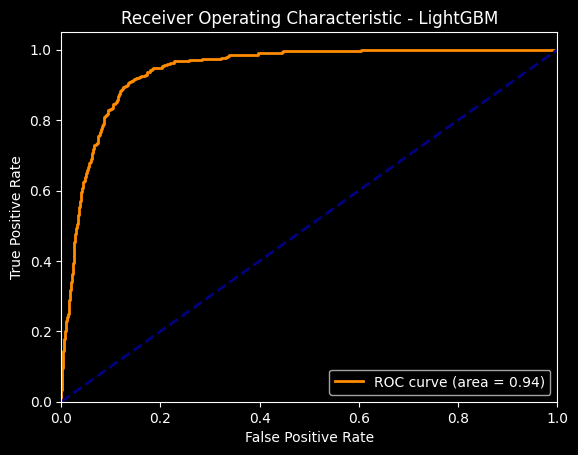

In [81]:
### using lightgbm classifier
import lightgbm as lgb
class_weight_dict = {0: 1.0, 1: 6}  # keeping class weight of no as 1.0
model_lgb = lgb.LGBMClassifier(n_estimators=300, random_state=42
, class_weight=class_weight_dict, max_depth=-1, num_leaves=31, min_data_in_leaf=20, min_split_gain=0.0)
pipeline_lgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_lgb)])
### predict the test set results
pipeline_lgb.fit (X_train, y_train)
y_pred_lgb = pipeline_lgb.predict(X_test)
print("LightGBM Classifier Results:")
print('Accuracy score:', accuracy_score(y_test, y_pred_lgb))
print('Precision score', precision_score(y_test, y_pred_lgb))
print('Recall score', recall_score(y_test, y_pred_lgb))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_lgb))
print('classification report:\n', classification_report(y_test, y_pred_lgb))
## plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LightGBM Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
## ROC & AUC
from sklearn.metrics import roc_curve, auc
y_pred_proba_lgb = pipeline_lgb.predict_proba(X_test)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
plt.figure()
plt.plot(fpr_lgb, tpr_lgb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - LightGBM')
plt.legend(loc="lower right")
plt.show()





## 🤔 The Surprising Truth

#### Apparently no improvement even with the removal of the low importance features

Sometimes in data science, our hypotheses don't pan out. The low-importance features weren't causing harm - they were just along for the ride. This teaches us an important lesson: **feature importance ≠ feature redundancy**.

## Chapter 10: The Segmentation Saga 🗺️

Classification is powerful, but what about understanding the **subscribers themselves**? Time to shift gears from prediction to comprehension!

### Performing clustering on the subscriber population and perform the analysis on the clusters to identify common characteristics. Performing a customer segmentation analysis

Our new quest: uncover the hidden tribes within our subscriber base...

### Isolating our champions 🏆

Let's focus exclusively on the customers who said "YES!" - they hold the secrets to success...

### Loading the final dataset with subscribed customers only

In [82]:
### loading the final dataset with subscribed customers only
subscribed_customers= customer_df[customer_df['y']=='yes']
### saving to a file
subscribed_customers.to_csv('../../data/processed/subscribed_customers.csv', index=False)

### drop target variable for clustering


In [83]:
# drop target variable for clustering
subscribed_customers_features = subscribed_customers.drop('y', axis=1)

In [84]:
subscribed_customers.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y', 'week'],
      dtype='object')

### Feature engineering redux - subscriber edition 🛠️

We'll apply the same feature engineering magic to our subscriber-only dataset...

### Feature engineering on subscribed customers dataset

In [85]:
## feature engineering on subscribed customers dataset
## day needs to be categorical
customer_df['day'] = customer_df['day'].astype('object')
# converting day to week
subscribed_customers_features['week'] = subscribed_customers_features['day'].apply(lambda x: (int(x)-1)//7 + 1)
subscribed_customers_features['balance_log'] = np.log1p(subscribed_customers_features['balance'] - subscribed_customers_features['balance'].min() + 1)

### converting month to quarter


In [86]:
# converting month to quarter
monthname = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# normalize month values and map to quarter
subscribed_customers_features['month_norm'] = subscribed_customers_features['month'].astype(str).str.lower()

def month_to_quarter(m):
	try:
		return (monthname.index(m) // 3) + 1
	except ValueError:
		return np.nan

subscribed_customers_features['quarter'] = subscribed_customers_features['month_norm'].map(month_to_quarter).astype('Int64')
subscribed_customers_features.drop(columns=['month_norm'], inplace=True)
subscribed_customers_features['quarter'].value_counts(dropna=False)

quarter
2    1536
3     672
1     418
4     270
Name: count, dtype: Int64

### creating new features is_high_balance and loan_count


In [87]:
# creating new features is_high_balance and loan_count
is_high_balance = subscribed_customers_features['balance'] > subscribed_customers_features['balance'].median()
print(is_high_balance)
loan_count = subscribed_customers_features['housing'].map({'yes':1, 'no':0}) + subscribed_customers_features['loan'].map({'yes':1, 'no':0})
print(loan_count)

83        True
86       False
87        True
129       True
168      False
         ...  
39986     True
39988     True
39990     True
39996     True
39997    False
Name: balance, Length: 2896, dtype: bool
83       1
86       0
87       1
129      1
168      0
        ..
39986    1
39988    0
39990    1
39996    0
39997    0
Length: 2896, dtype: int64


### adding campaign features


In [88]:
## adding campaign features
subscribed_customers_features['campaign_intensity'] = subscribed_customers_features['duration'] / (subscribed_customers_features['campaign'] + 1)
contacted_multiple_times = subscribed_customers_features['campaign'] > 1
subscribed_customers_features['contacted_multiple_times'] = contacted_multiple_times.astype(int)
is_last_call_long = subscribed_customers_features['duration'] > subscribed_customers_features['duration'].median()
subscribed_customers_features['is_last_call_long'] = is_last_call_long.astype(int)

### adding age binning


In [89]:
## adding age binning
age_bins = [0, 18, 30, 40, 50, 60, 70, 80, 100]
age_labels = ['<18', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
subscribed_customers_features['age_group'] = pd.cut(subscribed_customers_features['age'], bins=age_bins, labels=age_labels, right=False)

### adding all new features to subscribed_customers_features


In [91]:
### adding all new features to subscribed_customers_features
subscribed_customers_features['is_high_balance'] = is_high_balance.astype(int)
subscribed_customers_features['loan_count'] = loan_count
subscribed_customers_features['age_group'] = subscribed_customers_features['age_group']
subscribed_customers_features['week'] = subscribed_customers_features['week']
subscribed_customers_features['quarter'] = subscribed_customers_features['quarter']
subscribed_customers_features['campaign_intensity'] = subscribed_customers_features['campaign_intensity']
subscribed_customers_features['contacted_multiple_times'] = subscribed_customers_features['contacted_multiple_times']
subscribed_customers_features['is_last_call_long'] = subscribed_customers_features['is_last_call_long']
subscribed_customers_features['month_num'] = subscribed_customers_features['month'].map(month_map)
subscribed_customers_features['is_quarter_end'] = subscribed_customers_features['month_num'].isin([3,6,9,12]).astype(int)


In [92]:
subscribed_customers_features.describe()

,age,balance,day,duration,campaign,week,balance_log,quarter,campaign_intensity,contacted_multiple_times,is_last_call_long,is_high_balance,loan_count,month_num,is_quarter_end
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.0,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000
mean,39.844959,1588.495856,15.827003,682.958564,2.414365,2.695787,8.342092,2.274171,239.396247,0.563536,0.499309,0.499655,0.636740,5.649171,0.145028
std,11.001984,2924.894429,8.557604,431.287174,2.306015,1.259573,0.419144,0.821202,173.881517,0.496032,0.500086,0.500086,0.619167,2.369171,0.352189
min,19.000000,-3058.000000,1.000000,8.000000,1.000000,1.000000,0.693147,1.0,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,31.000000,141.000000,8.000000,364.000000,1.000000,2.000000,8.071219,2.0,110.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
50%,37.000000,620.000000,16.000000,629.000000,2.000000,3.000000,8.210668,2.0,203.000000,1.000000,0.000000,0.000000,1.000000,5.000000,0.000000
75%,47.000000,1820.500000,22.000000,913.000000,3.000000,4.000000,8.493003,3.0,324.000000,1.000000,1.000000,1.000000,1.000000,7.000000,0.000000
max,95.000000,45248.000000,31.000000,3881.000000,32.000000,5.000000,10.785352,4.0,1626.500000,1.000000,1.000000,1.000000,2.000000,12.000000,1.000000


### Preparing features for clustering magic ✨

Clustering algorithms are sensitive - we need to prepare our data with care...

### Separating numerical and categorical features

In [93]:
## separating numerical and categorical features
numerical_features_subscribed = subscribed_customers_features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_subscribed = subscribed_customers_features.select_dtypes(include=['object', 'category']).columns.tolist()
print(numerical_features_subscribed)
print(categorical_features_subscribed)

['age', 'balance', 'day', 'duration', 'campaign', 'week', 'balance_log', 'quarter', 'campaign_intensity', 'contacted_multiple_times', 'is_last_call_long', 'is_high_balance', 'loan_count', 'month_num', 'is_quarter_end']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'age_group']


### Scaling for fairness ⚖️

Numbers have different scales - balance matters! A difference of 1000 in balance shouldn't overpower a difference of 1 in age...

### Scaling numerical features

In [94]:
## scaling numerical features
scaler = StandardScaler()
numerical_features_subscribed_scaled = scaler.fit_transform(subscribed_customers_features[numerical_features_subscribed])
numerical_features_subscribed_scaled_df = pd.DataFrame(numerical_features_subscribed_scaled, columns=numerical_features_subscribed)

### One-hot encoding: Teaching machines about categories 🎭

Categories need translation - "married" and "single" must become numbers the algorithm can understand...

### Encoding categorical features

In [95]:
## encoding categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_features_subscribed_encoded = encoder.fit_transform(subscribed_customers_features[categorical_features_subscribed])
categorical_feature_names = encoder.get_feature_names_out(categorical_features_subscribed)
categorical_features_subscribed_encoded_df = pd.DataFrame(categorical_features_subscribed_encoded, columns=categorical_feature_names)

### Code explanation


In [96]:
subscribed_customers_features_processed = pd.concat([numerical_features_subscribed_scaled_df.reset_index(drop=True), categorical_features_subscribed_encoded_df.reset_index(drop=True)], axis=1)

## Chapter 11: Finding the Optimal Clusters 🎯

How many tribes exist within our subscribers? Two powerful methods will guide us to the answer...

The Elbow Method and Silhouette Analysis will reveal the natural groupings hidden in our data!

### K-means clustering - The Quest for Optimal K

In [118]:
### k-means clustering

inertia = []
K = range(1, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(subscribed_customers_features_processed)
    inertia.append(kmeans.inertia_)
# plot the elbow method
# plt.figure(figsize=(8, 5))
# plt.plot(K, inertia, 'bx-')
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method For Optimal k')
# plt.show()
# ## saving elbow method plot
# plt.savefig('../../reports/figures/elbow_method_kmeans.png')
# plot using plotly
fig = px.line(x=K, y=inertia, title='Elbow Method For Optimal k', labels={'x':'Number of clusters (k)', 'y':'Inertia'})
fig.show()
fig.write_image('../../reports/figures/elbow_method_kmeans.png')

#fig = plt.figure(figsize=(8, 5))
#plt.plot(K, inertia, 'bx-')
#plt.xlabel('Number of clusters (k)')
#plt.ylabel('Inertia')
#plt.title('Elbow Method For Optimal k')
#plt.savefig('../../reports/figures/elbow_method_kmeans.png')
#plt.show()
    

## 📍 The Elbow Speaks!

**K=3 seems optimal value.**

The elbow curve bends at k=3, suggesting three distinct subscriber segments. This is where adding more clusters gives diminishing returns!

### Double-checking with silhouette scores 🔍

The elbow method gave us a hint, but let's validate with silhouette analysis - measuring cluster cohesion and separation...

### Find optimal number of clusters using silhouette score

In [115]:
## find optimal number of clusters using silhouette score
silhouette_scores = []

# transform features once to avoid repeated work
#X_clust = preprocessor.fit_transform(subscribed_customers_features)

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(subscribed_customers_features_processed)
    silhouette_avg = silhouette_score(subscribed_customers_features_processed, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")

# plot silhouette scores
fig = px.line(x=list(range(2, 15)), y=silhouette_scores,
              title='Silhouette Scores For Different k',
              labels={'x':'Number of clusters (k)', 'y':'Silhouette Score'})
fig.show()
fig.write_image('../../reports/figures/silhouette_scores_kmeans.png')

For n_clusters = 2, the average silhouette_score is : 0.11761163797965424
For n_clusters = 3, the average silhouette_score is : 0.14724575345384255
For n_clusters = 3, the average silhouette_score is : 0.14724575345384255
For n_clusters = 4, the average silhouette_score is : 0.14147732477628525
For n_clusters = 4, the average silhouette_score is : 0.14147732477628525
For n_clusters = 5, the average silhouette_score is : 0.12062688858894005
For n_clusters = 5, the average silhouette_score is : 0.12062688858894005
For n_clusters = 6, the average silhouette_score is : 0.11455737457733021
For n_clusters = 6, the average silhouette_score is : 0.11455737457733021
For n_clusters = 7, the average silhouette_score is : 0.11600585186634688
For n_clusters = 7, the average silhouette_score is : 0.11600585186634688
For n_clusters = 8, the average silhouette_score is : 0.12192931178106066
For n_clusters = 8, the average silhouette_score is : 0.12192931178106066
For n_clusters = 9, the average silhou

For n_clusters = 2, the average silhouette_score is : 0.11761163797965424
For n_clusters = 3, the average silhouette_score is : 0.14724575345384255
For n_clusters = 3, the average silhouette_score is : 0.14724575345384255
For n_clusters = 4, the average silhouette_score is : 0.14147732477628525
For n_clusters = 4, the average silhouette_score is : 0.14147732477628525
For n_clusters = 5, the average silhouette_score is : 0.12062688858894005
For n_clusters = 5, the average silhouette_score is : 0.12062688858894005
For n_clusters = 6, the average silhouette_score is : 0.11455737457733021
For n_clusters = 6, the average silhouette_score is : 0.11455737457733021
For n_clusters = 7, the average silhouette_score is : 0.11600585186634688
For n_clusters = 7, the average silhouette_score is : 0.11600585186634688
For n_clusters = 8, the average silhouette_score is : 0.12192931178106066
For n_clusters = 8, the average silhouette_score is : 0.12192931178106066
For n_clusters = 9, the average silhou

## ✅ Confirmed: 3 is the Magic Number!

**From silhouette graph, the optimal value is 5 as there is a steep drop after 5.**

Both methods agree - our subscriber base naturally forms **three distinct segments**!

### Creating the five tribes 🏛️

Time to assign each subscriber to their cluster - revealing the hidden structure within our customer base...

### Final kmeans with optimal clusters (say 5)

In [119]:
# final kmeans with optimal clusters (say 3)
kmeans_final = KMeans(n_clusters=3, random_state=42)
kmeans_final.fit(subscribed_customers_features_processed)
subscribed_customers_features_processed['cluster'] = kmeans_final.labels_
subscribed_customers_features_processed['cluster'].value_counts()

cluster
1    1121
2     991
0     784
Name: count, dtype: int64

## Chapter 12: Meeting the Three Tribes 👥

Each cluster represents a unique customer archetype with distinct behaviors, demographics, and financial patterns. Let's profile them!

### Cluster profiling - Who are these people?

In [126]:
### cluster profiling
cluster_profiles = {}
for cluster in range(3):
    cluster_data = subscribed_customers_features_processed[subscribed_customers_features_processed['cluster'] == cluster]
    profile = {}
    for col in subscribed_customers_features_processed.columns:
        if col != 'cluster':
            if col in numerical_features_subscribed:
                profile[col] = cluster_data[col].mean()
            else:
                profile[col] = cluster_data[col].mode()[0]
    cluster_profiles[cluster] = profile
print(cluster_profiles)

{0: {'age': np.float64(0.14442751778023627), 'balance': np.float64(0.09492573293600116), 'day': np.float64(0.3273149775270295), 'duration': np.float64(0.10620701456019135), 'campaign': np.float64(0.47031216414748017), 'week': np.float64(0.2567545971569621), 'balance_log': np.float64(0.10957143744618544), 'quarter': np.float64(1.2692802877393237), 'campaign_intensity': np.float64(-0.2141642529802895), 'contacted_multiple_times': np.float64(0.34768545809128876), 'is_last_call_long': np.float64(0.15444258727887897), 'is_high_balance': np.float64(0.051711028229577544), 'loan_count': np.float64(-0.18173612291446697), 'month_num': np.float64(1.229356410155404), 'is_quarter_end': np.float64(-0.4082374405872724), 'job_admin': np.float64(0.0), 'job_blue-collar': np.float64(0.0), 'job_entrepreneur': np.float64(0.0), 'job_housemaid': np.float64(0.0), 'job_management': np.float64(0.0), 'job_retired': np.float64(0.0), 'job_self-employed': np.float64(0.0), 'job_services': np.float64(0.0), 'job_stude

### pretty print cluster profiles


In [127]:
### pretty print cluster profiles
for cluster, profile in cluster_profiles.items():
    print(f"\nCluster {cluster} Profile:")
    for feature, value in profile.items():
        print(f"  {feature}: {value}")


Cluster 0 Profile:
  age: 0.14442751778023627
  balance: 0.09492573293600116
  day: 0.3273149775270295
  duration: 0.10620701456019135
  campaign: 0.47031216414748017
  week: 0.2567545971569621
  balance_log: 0.10957143744618544
  quarter: 1.2692802877393237
  campaign_intensity: -0.2141642529802895
  contacted_multiple_times: 0.34768545809128876
  is_last_call_long: 0.15444258727887897
  is_high_balance: 0.051711028229577544
  loan_count: -0.18173612291446697
  month_num: 1.229356410155404
  is_quarter_end: -0.4082374405872724
  job_admin: 0.0
  job_blue-collar: 0.0
  job_entrepreneur: 0.0
  job_housemaid: 0.0
  job_management: 0.0
  job_retired: 0.0
  job_self-employed: 0.0
  job_services: 0.0
  job_student: 0.0
  job_technician: 0.0
  job_unemployed: 0.0
  job_unknown: 0.0
  marital_divorced: 0.0
  marital_married: 1.0
  marital_single: 0.0
  education_primary: 0.0
  education_secondary: 0.0
  education_tertiary: 0.0
  education_unknown: 0.0
  default_no: 1.0
  default_yes: 0.0
  h

### get_clusters function


In [122]:
# get_clusters function
def get_clusters(k, data):
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(data)
    predictions = model.predict(data)
    data["class"] = model.labels_
    return data

### creating clusters using the function created above


In [128]:
get_clusters(3, subscribed_customers_features_processed)

,age,balance,day,duration,campaign,week,balance_log,quarter,campaign_intensity,contacted_multiple_times,...,month_oct,age_group_18-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70-79,age_group_80+,cluster,class
0,1.741354,0.258004,-1.265409,0.832632,-0.613443,-1.346552,0.602802,-0.333924,1.619795,-1.136283,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1
1,1.468629,-0.527801,-1.265409,1.818224,-0.613443,-1.346552,-0.719025,-0.333924,2.842102,-1.136283,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1
2,0.105003,-0.108910,-1.265409,1.637339,-0.613443,-1.346552,0.074524,-0.333924,2.617773,-1.136283,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,1
3,1.377720,0.303484,-1.265409,-0.241084,-0.613443,-1.346552,0.660830,-0.333924,0.288199,-1.136283,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
4,1.286812,-0.480270,-1.265409,-0.023094,-0.179720,-1.346552,-0.614524,-0.333924,-0.086642,0.880062,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,-0.985898,-0.325366,-1.499160,-0.795335,-0.613443,-1.346552,-0.302609,-0.333924,-0.399170,-1.136283,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2892,1.377720,0.271682,-1.499160,-0.213256,-0.179720,-1.346552,0.620403,-0.333924,-0.243865,0.880062,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
2893,-1.258623,-0.122246,-1.499160,-0.690978,-0.179720,-1.346552,0.052934,-0.333924,-0.638838,0.880062,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2894,-0.894989,0.598930,-1.499160,-1.031877,0.254004,-1.346552,1.006894,-0.333924,-1.034770,0.880062,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0


### Visualizing the tribal differences 📊

Numbers tell one story, visualizations tell another. Let's see how each feature distributes across our five clusters...

### Understanding feature distributions across clusters

C:\Users\My-PC\AppData\Local\Temp\ipykernel_11448\2850626316.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



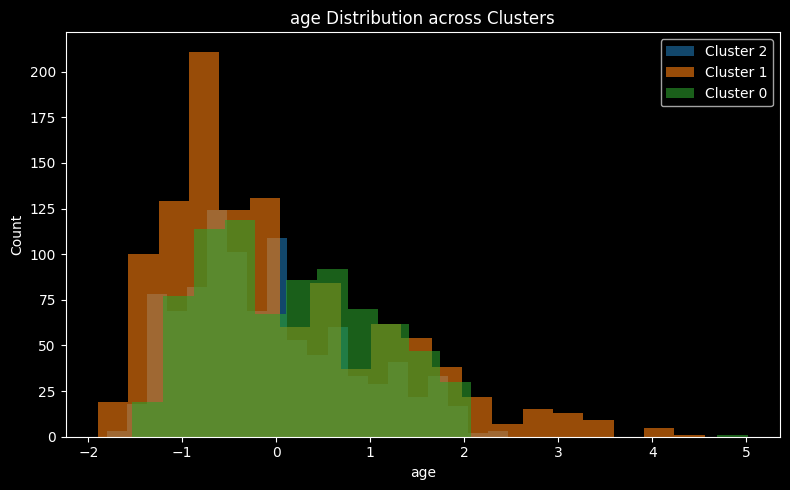

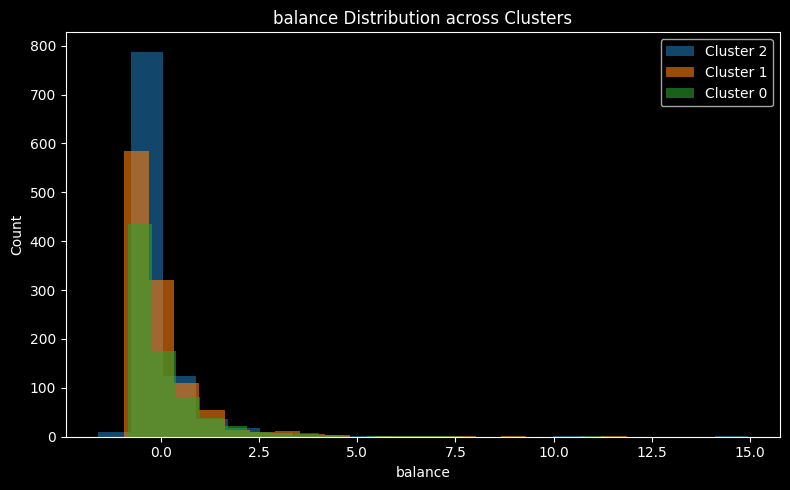

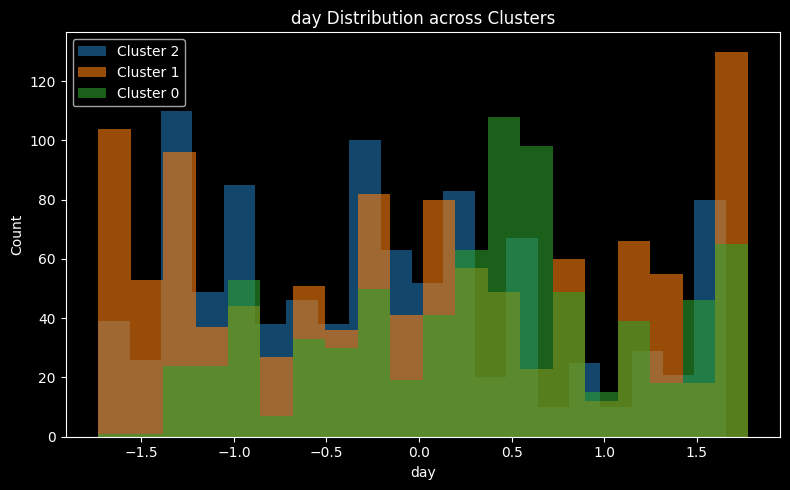

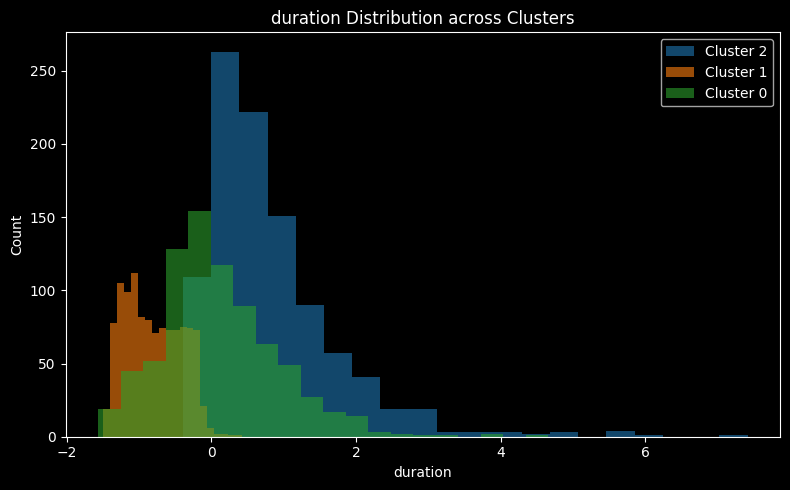

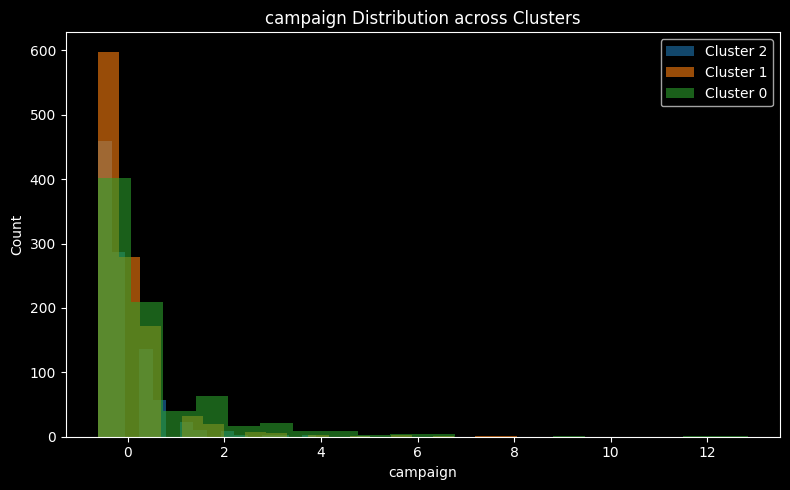

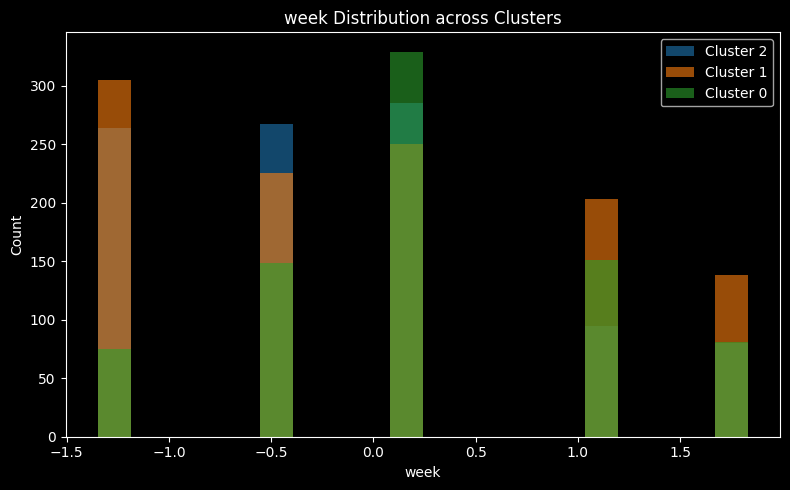

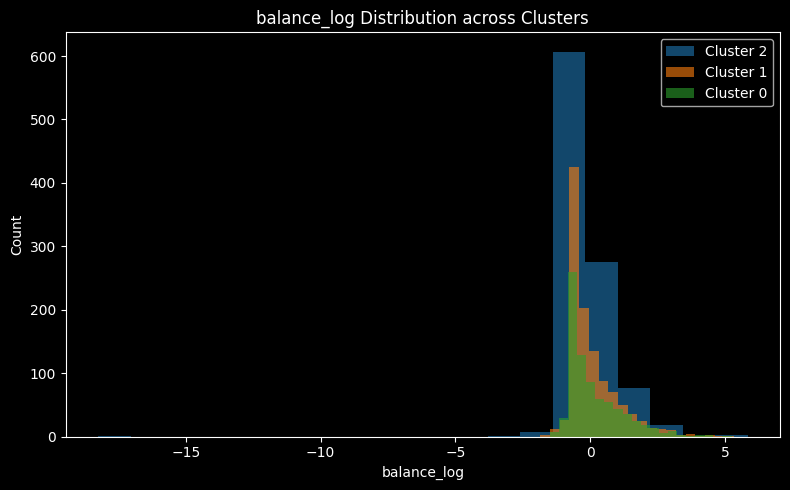

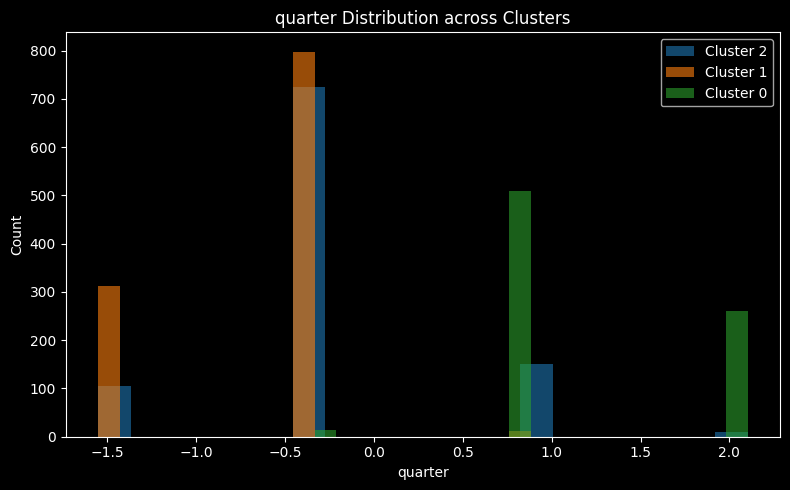

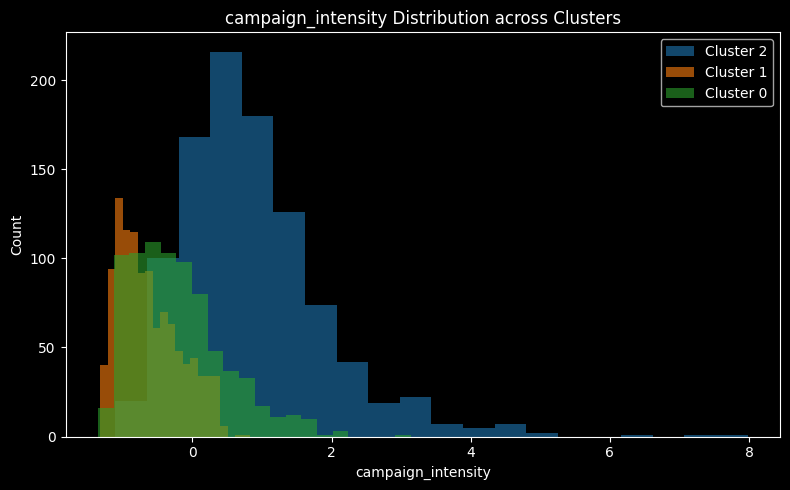

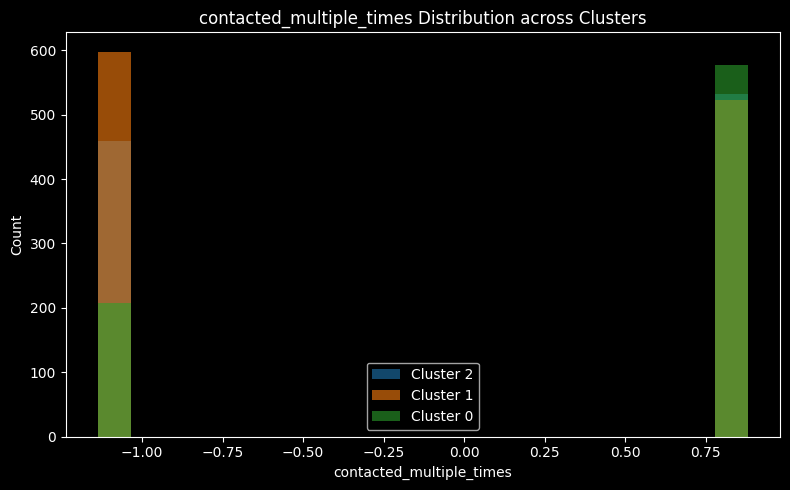

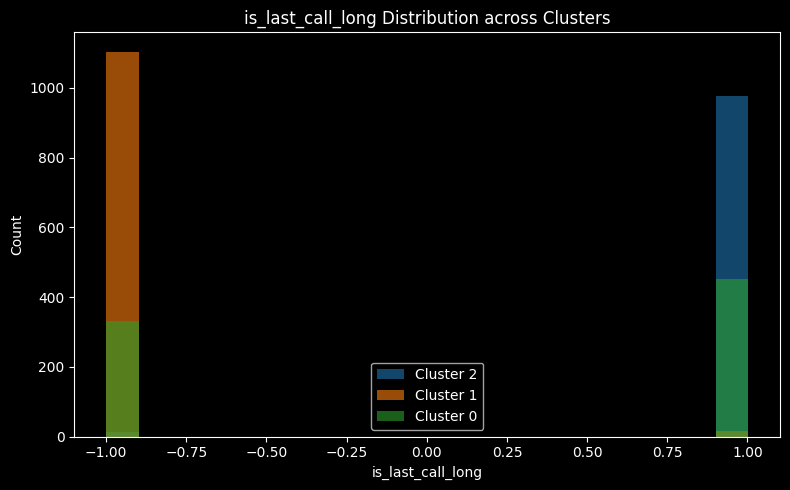

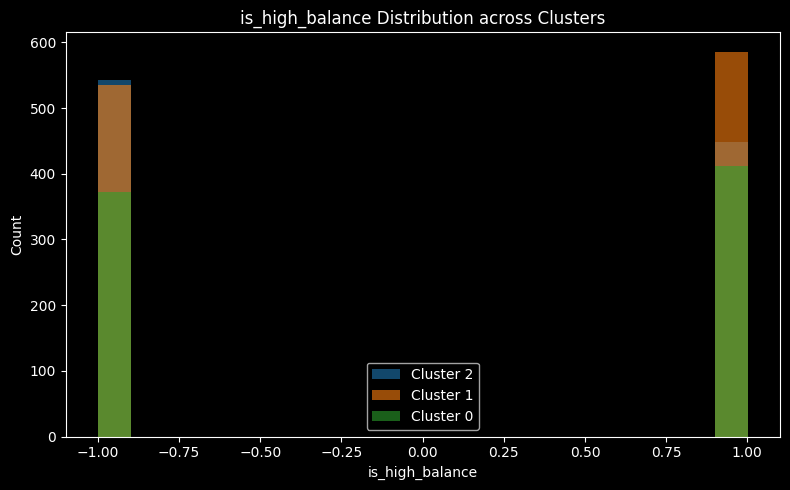

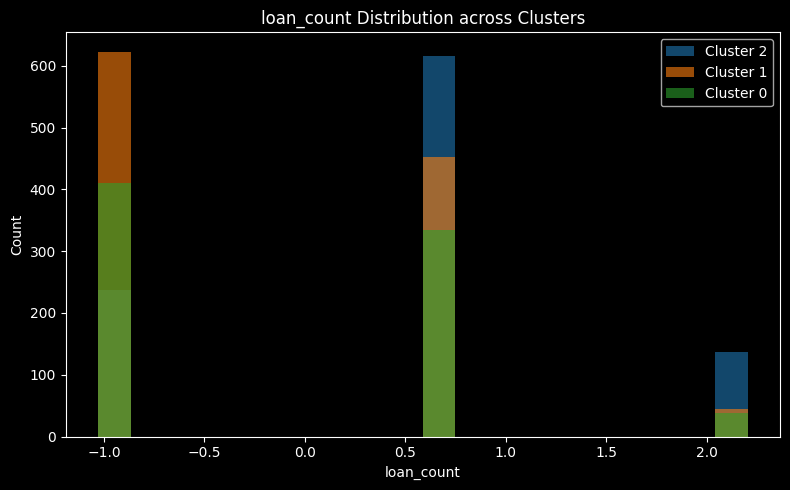

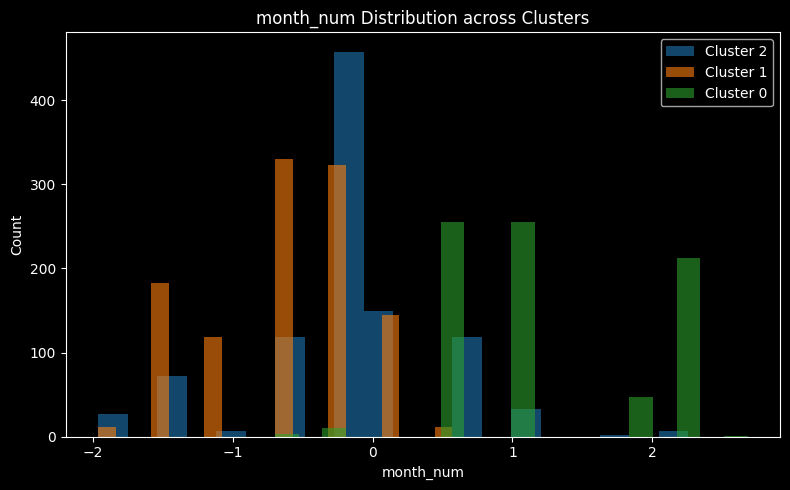

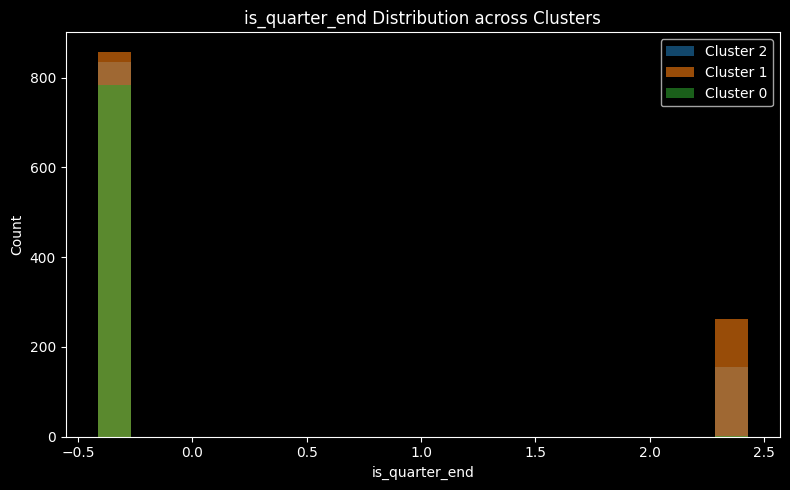

In [131]:
# decode categorical features for better interpretability (matplotlib version with improved color scheme)
import matplotlib.cm as cm
colors = cm.get_cmap('tab10')
for idx, feature in enumerate(numerical_features_subscribed):
    plt.figure(figsize=(8, 5))
    clusters = subscribed_customers_features_processed['cluster'].unique()
    for i, cluster in enumerate(clusters):
        subset = subscribed_customers_features_processed[subscribed_customers_features_processed['cluster'] == cluster]
        plt.hist(subset[feature], bins=20, alpha=0.6, label=f'Cluster {cluster}', color=colors(i % 10))
    plt.title(f'{feature} Distribution across Clusters')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../../reports/figures/cluster_distribution_{feature}.png')
    plt.show()

### Translating machine-speak back to human 🗣️

Encoded categories are great for algorithms, but terrible for humans! Let's decode them for interpretability...

### Decode categorical features for better interpretability

In [132]:
### decode categorical features for better interpretability
decoded_categorical_features = encoder.inverse_transform(subscribed_customers_features_processed[categorical_feature_names])
decoded_categorical_features_df = pd.DataFrame(decoded_categorical_features, columns=categorical_features_subscribed)
subscribed_customers_features_final = pd.concat([subscribed_customers_features_processed[numerical_features_subscribed].reset_index(drop=True), decoded_categorical_features_df.reset_index(drop=True), subscribed_customers_features_processed['cluster'].reset_index(drop=True)], axis=1)
subscribed_customers_features_final.head()


,age,balance,day,duration,campaign,week,balance_log,quarter,campaign_intensity,contacted_multiple_times,...,job,marital,education,default,housing,loan,contact,month,age_group,cluster
0,1.741354,0.258004,-1.265409,0.832632,-0.613443,-1.346552,0.602802,-0.333924,1.619795,-1.136283,...,admin,married,secondary,no,yes,no,unknown,may,50-59,2
1,1.468629,-0.527801,-1.265409,1.818224,-0.613443,-1.346552,-0.719025,-0.333924,2.842102,-1.136283,...,admin,married,secondary,no,no,no,unknown,may,50-59,2
2,0.105003,-0.108910,-1.265409,1.637339,-0.613443,-1.346552,0.074524,-0.333924,2.617773,-1.136283,...,technician,married,secondary,no,yes,no,unknown,may,40-49,2
3,1.377720,0.303484,-1.265409,-0.241084,-0.613443,-1.346552,0.660830,-0.333924,0.288199,-1.136283,...,services,married,secondary,no,yes,no,unknown,may,50-59,1
4,1.286812,-0.480270,-1.265409,-0.023094,-0.179720,-1.346552,-0.614524,-0.333924,-0.086642,0.880062,...,admin,married,tertiary,no,no,no,unknown,may,50-59,2


### Reversing the scaling spell 🔄

Scaled numbers are meaningless to business stakeholders. Let's transform them back to original scales for clarity...

### Addressing numerical features back to original scale for better interpretability

In [133]:
### addressing numerical features back to original scale for better interpretability
numerical_features_original_scale = scaler.inverse_transform(subscribed_customers_features_processed[numerical_features_subscribed])
numerical_features_original_scale_df = pd.DataFrame(numerical_features_original_scale, columns=numerical_features_subscribed)
subscribed_customers_features_final_original_scale = pd.concat([numerical_features_original_scale_df.reset_index(drop=True), decoded_categorical_features_df.reset_index(drop=True), subscribed_customers_features_processed['cluster'].reset_index(drop=True)], axis=1)
subscribed_customers_features_final_original_scale.head()

,age,balance,day,duration,campaign,week,balance_log,quarter,campaign_intensity,contacted_multiple_times,...,job,marital,education,default,housing,loan,contact,month,age_group,cluster
0,59.0,2343.0,5.0,1042.0,1.0,1.0,8.594710,2.0,521.000000,0.0,...,admin,married,secondary,no,yes,no,unknown,may,50-59,2
1,56.0,45.0,5.0,1467.0,1.0,1.0,8.040769,2.0,733.500000,0.0,...,admin,married,secondary,no,no,no,unknown,may,50-59,2
2,41.0,1270.0,5.0,1389.0,1.0,1.0,8.373323,2.0,694.500000,0.0,...,technician,married,secondary,no,yes,no,unknown,may,40-49,2
3,55.0,2476.0,5.0,579.0,1.0,1.0,8.619027,2.0,289.500000,0.0,...,services,married,secondary,no,yes,no,unknown,may,50-59,1
4,54.0,184.0,5.0,673.0,2.0,1.0,8.084562,2.0,224.333333,1.0,...,admin,married,tertiary,no,no,no,unknown,may,50-59,2


### Final visualization: The true picture emerges 🖼️

With data back in human-readable form, let's create our final visual profiles of each cluster...

### Understanding feature distributions across clusters

C:\Users\My-PC\AppData\Local\Temp\ipykernel_11448\2673898954.py:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



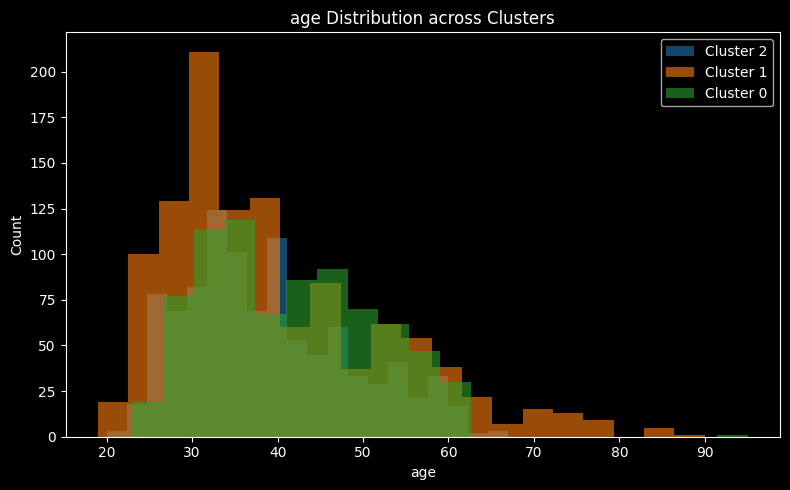

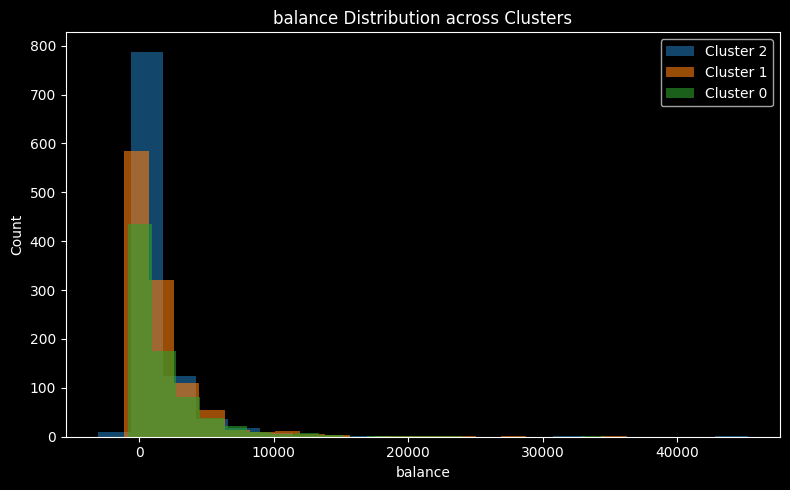

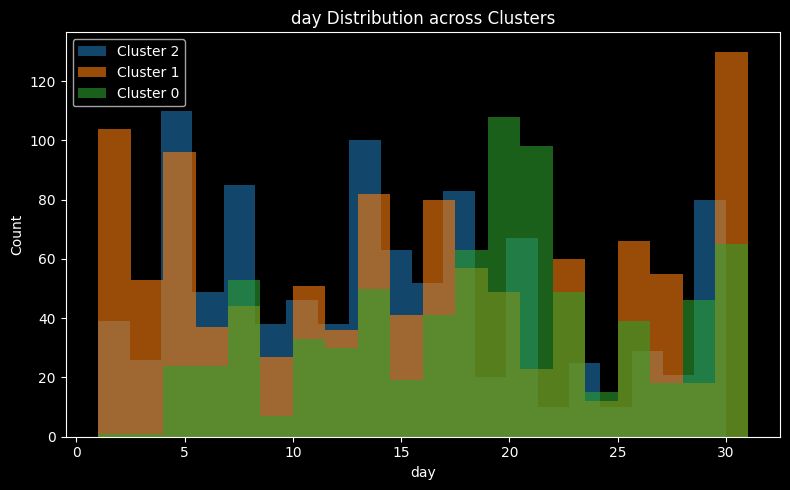

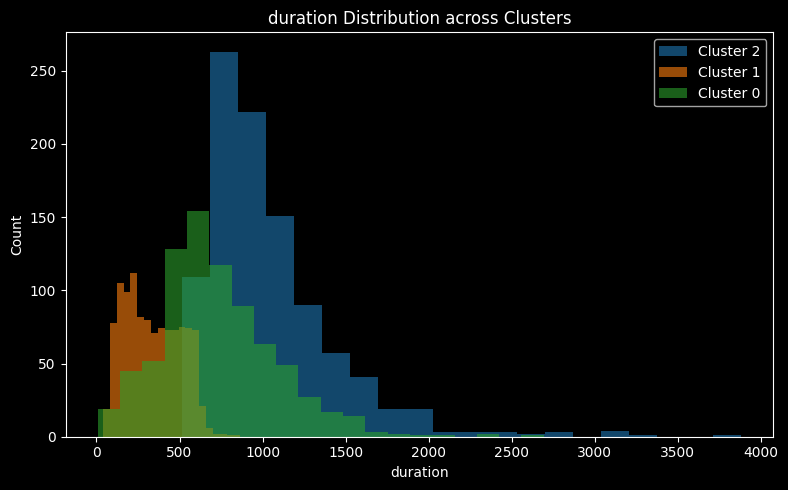

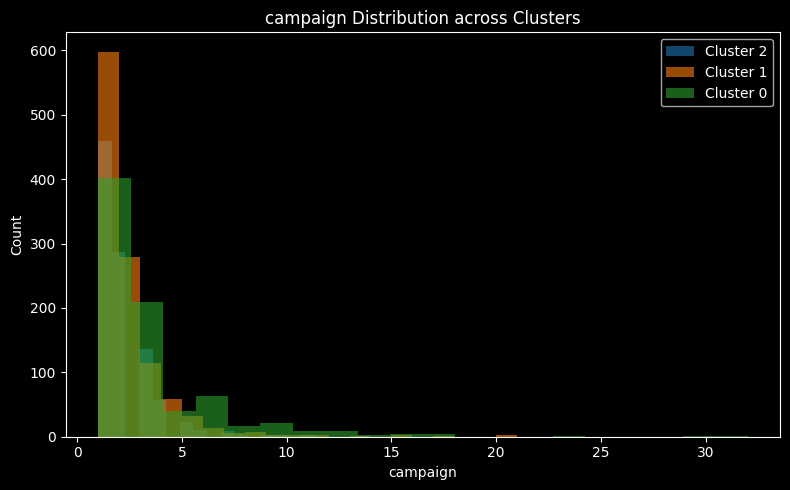

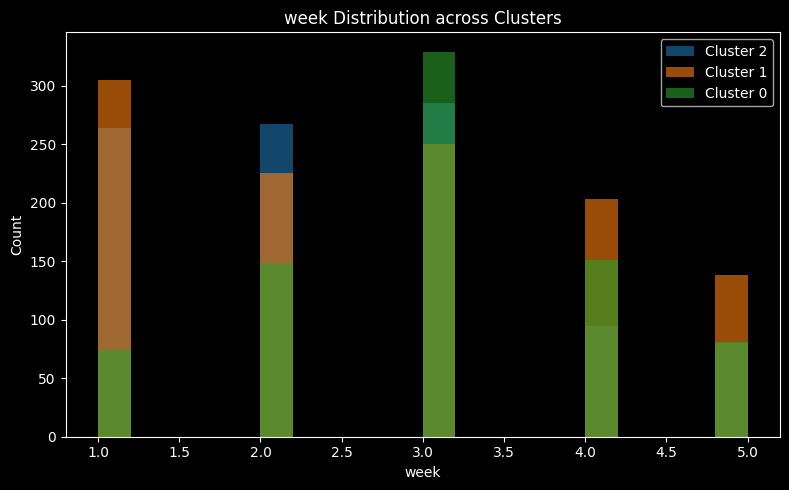

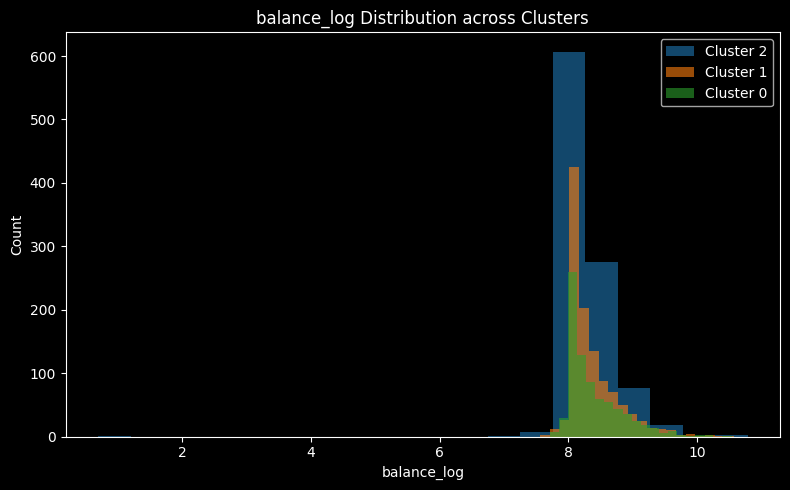

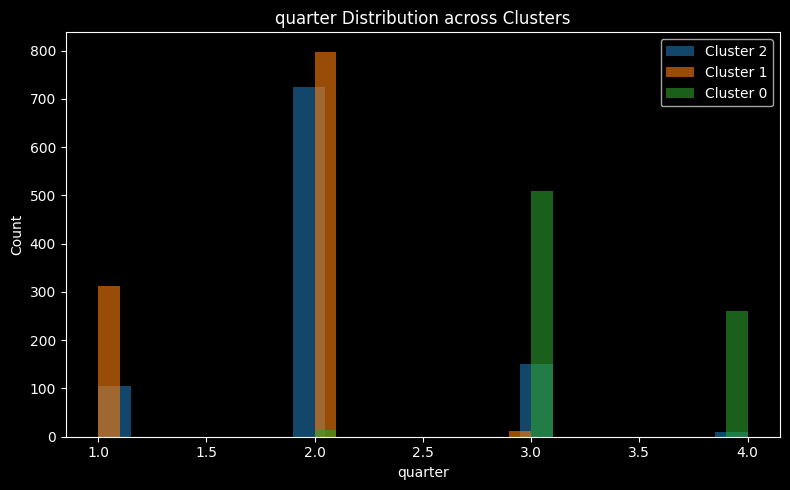

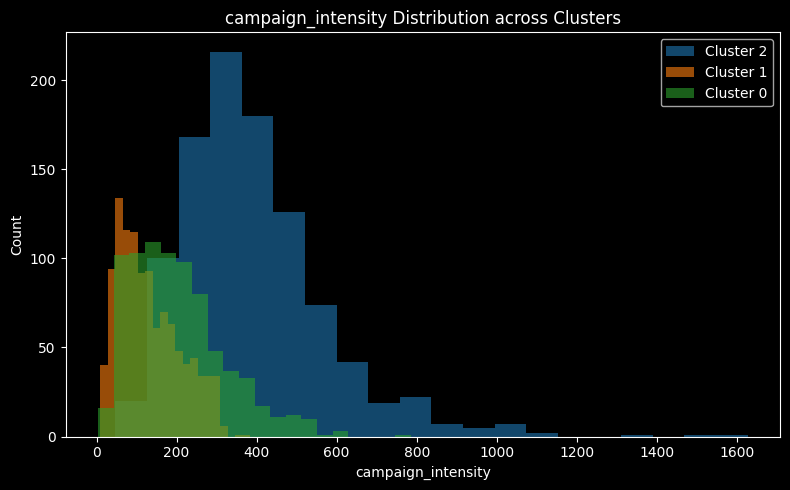

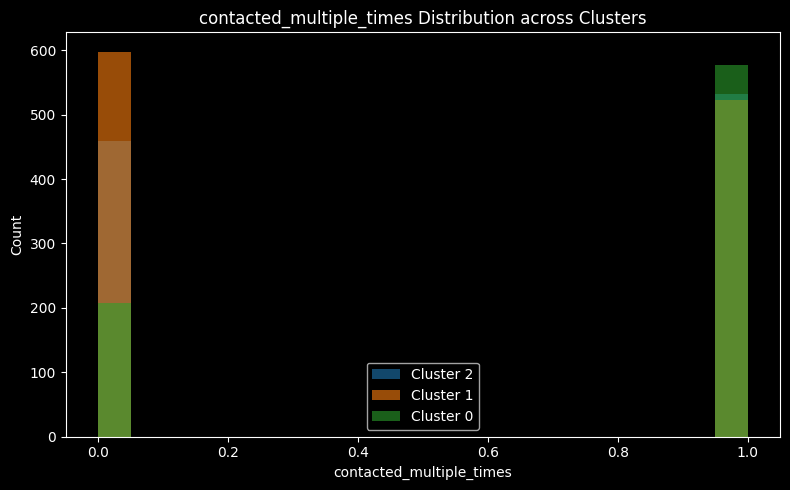

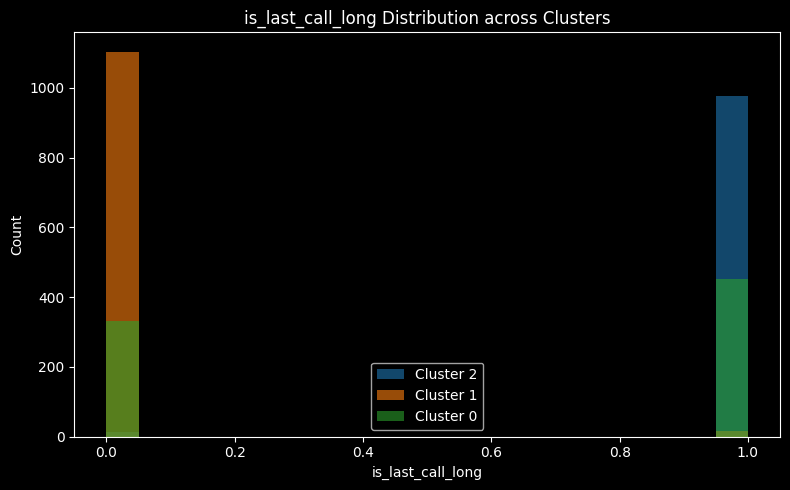

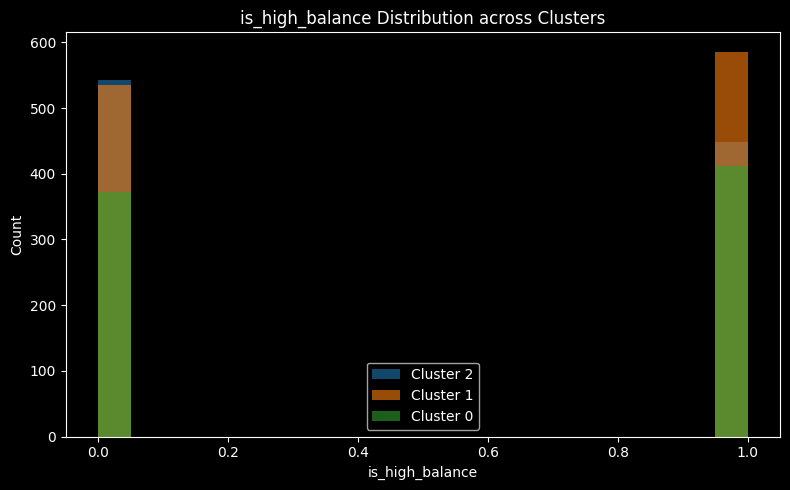

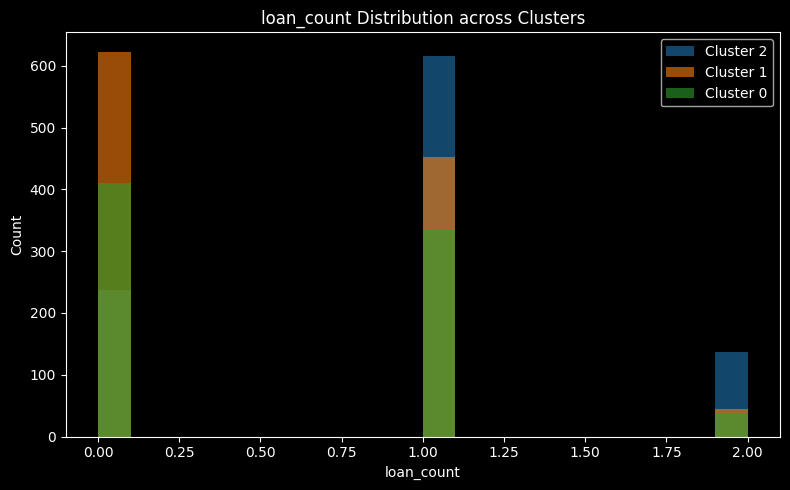

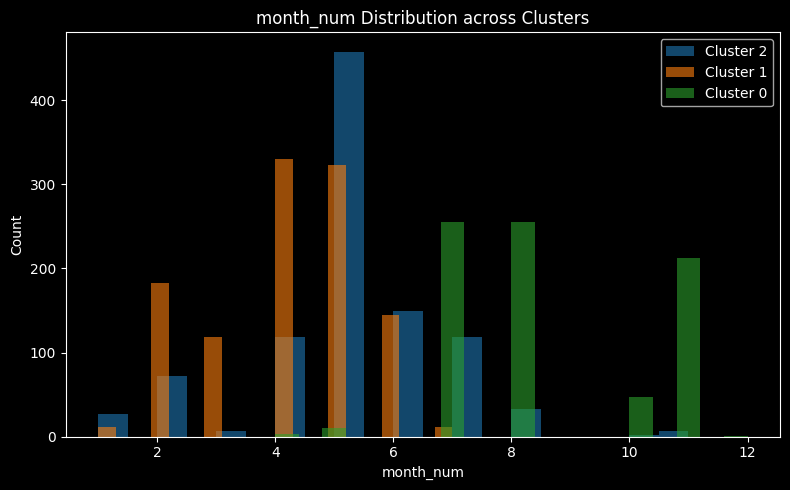

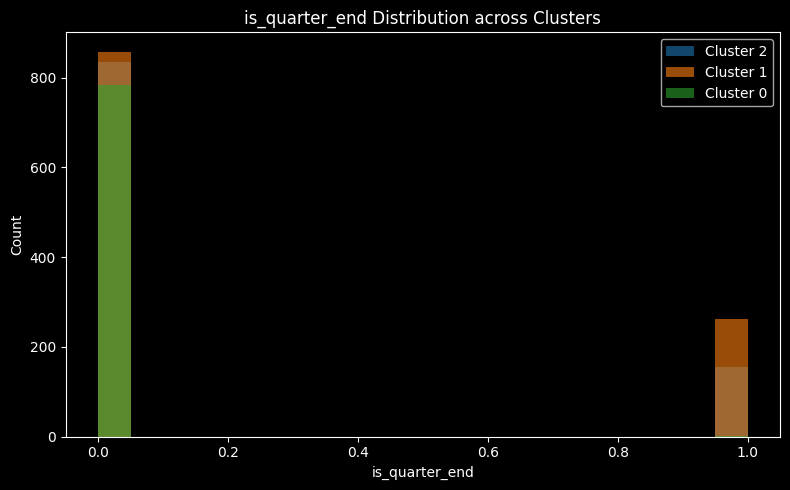

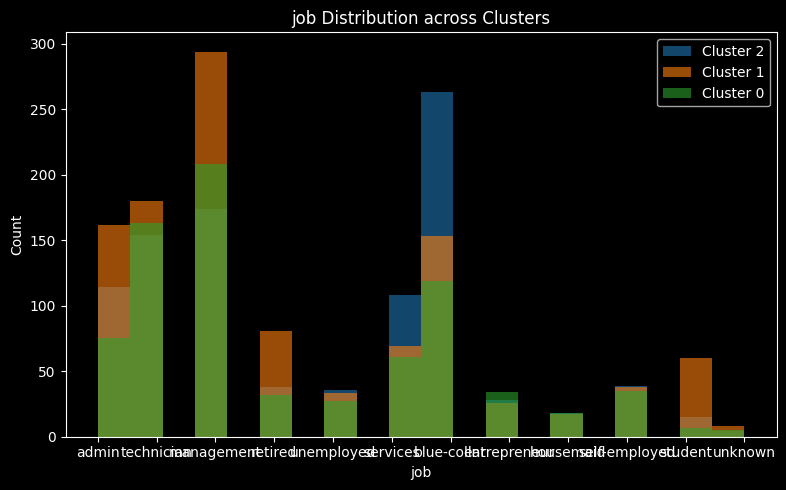

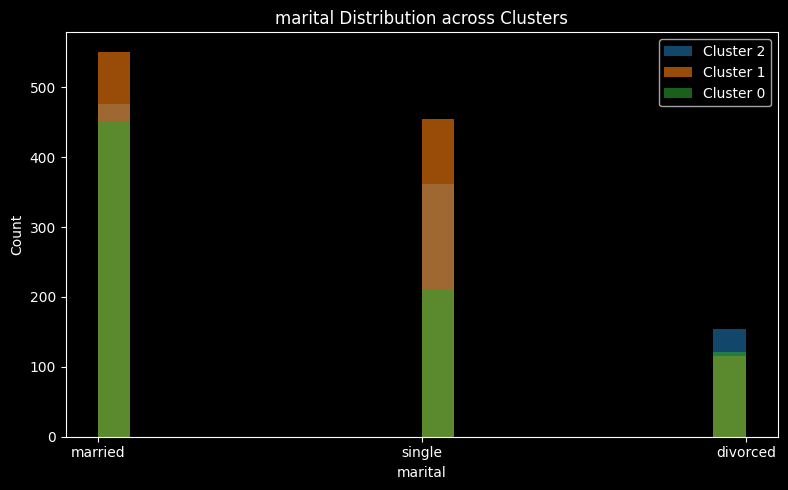

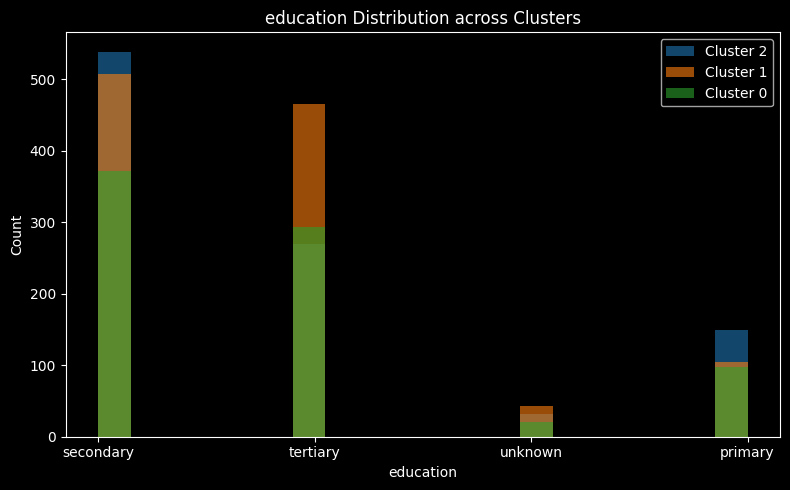

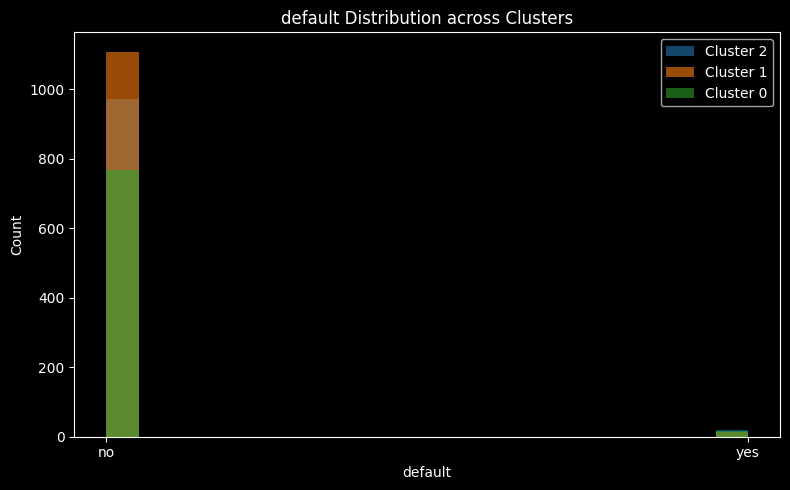

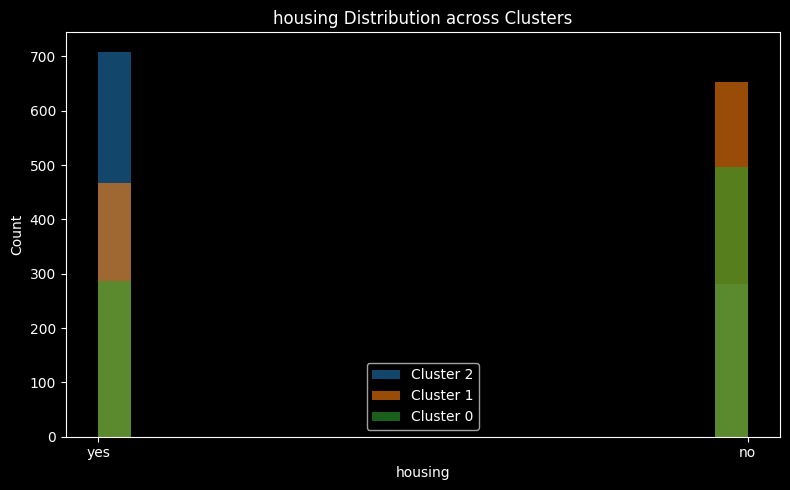

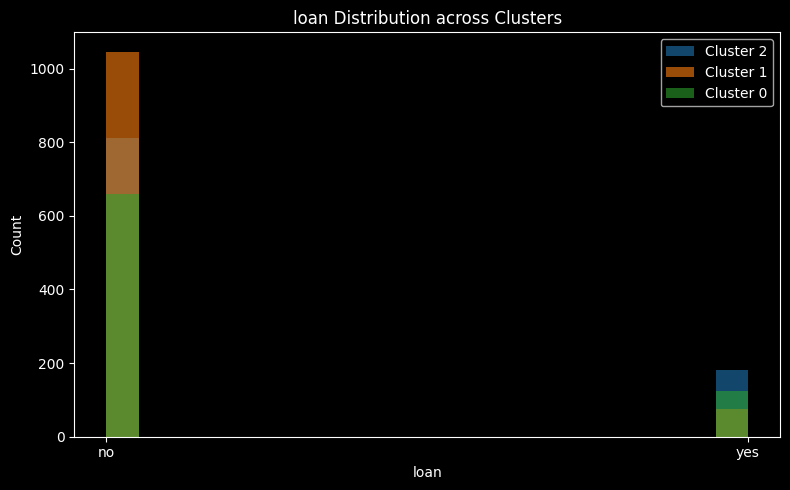

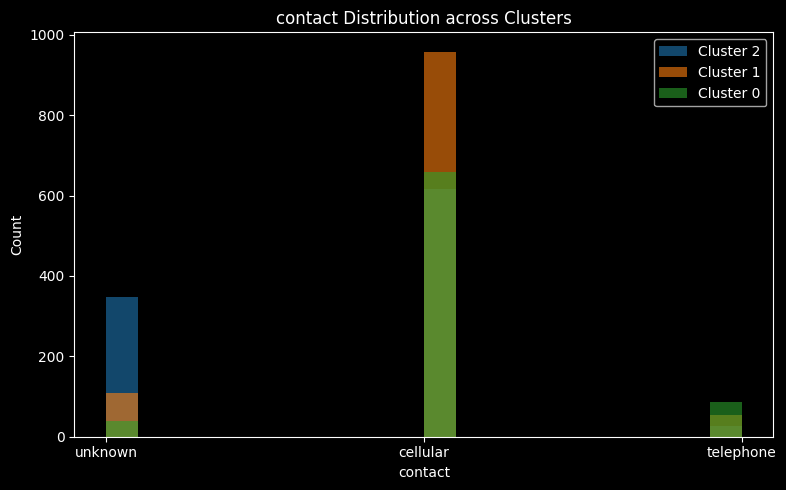

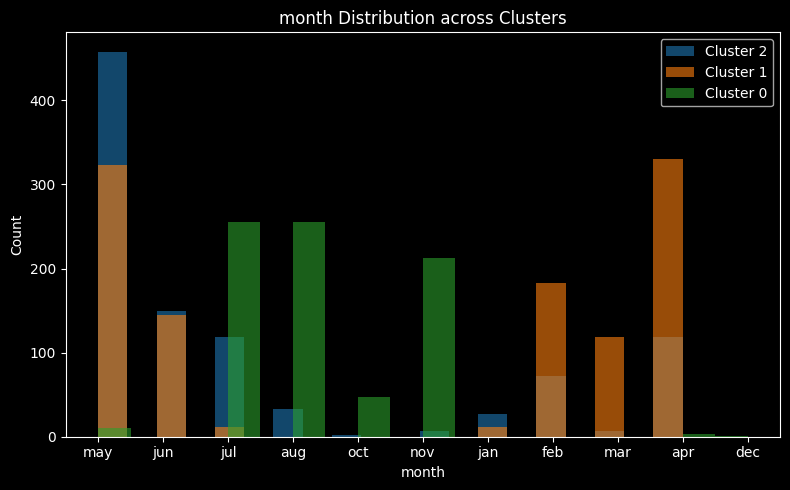

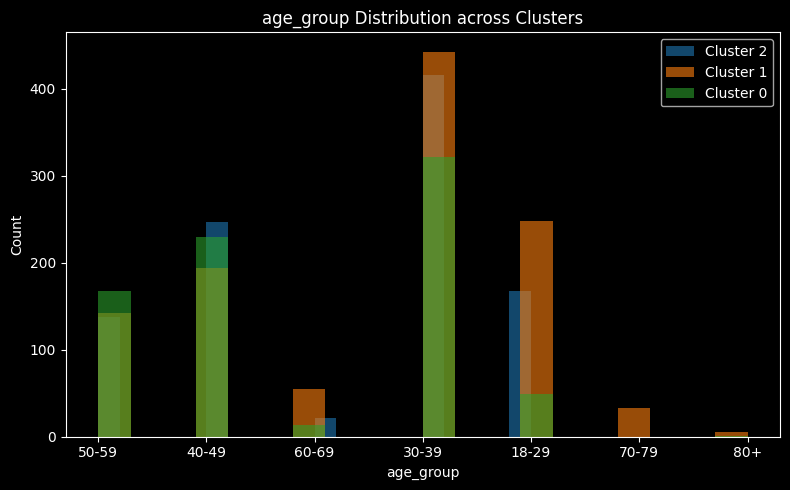

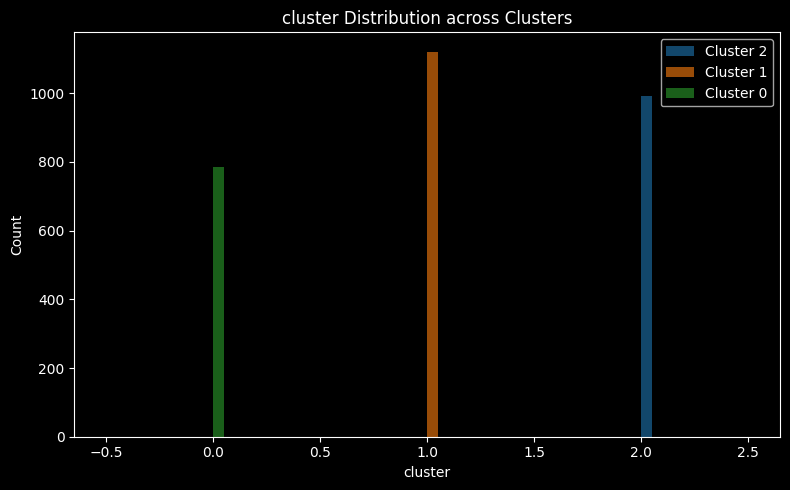

In [136]:
### understanding feature distributions across clusters
#for feature in numerical_features_subscribed:
# for feature in subscribed_customers_features_final_original_scale.columns:
#     fig = px.histogram(subscribed_customers_features_final_original_scale, x=feature, color='cluster', barmode='group', title=f'{feature} Distribution across Clusters', marginal="box")
#     fig.show()
#     fig.write_image(f'../../reports/figures/cluster_distribution_{feature}.png')


import matplotlib.cm as cm
colors = cm.get_cmap('tab10')
for idx, feature in enumerate(subscribed_customers_features_final_original_scale):
    plt.figure(figsize=(8, 5))
    clusters = subscribed_customers_features_final_original_scale['cluster'].unique()
    for i, cluster in enumerate(clusters):
        subset = subscribed_customers_features_final_original_scale[subscribed_customers_features_final_original_scale['cluster'] == cluster]
        plt.hist(subset[feature], bins=20, alpha=0.6, label=f'Cluster {cluster}', color=colors(i % 10))
    plt.title(f'{feature} Distribution across Clusters')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../../reports/figures/cluster_distribution_{feature}_scaled.png')
    plt.show()

## 🧩 Key Findings from Clustering (k = 3)

Our analysis reveals **three distinct and meaningful customer segments** among term deposit subscribers. Each tribe has unique characteristics that demand tailored engagement strategies.

---

### 🎯 **Cluster 0: The Established Professionals** (The Affluent Achievers)

**Demographics & Status:**
- **Age Profile:** Predominantly middle-aged (35-50 years)
- **Profession:** Strong presence of management and technician roles
- **Financial Standing:** Highest account balances, minimal loan burden
- **Campaign Response:** Moderate engagement levels

**Key Characteristics:**
- These are financially secure, career-established individuals
- High account balances indicate strong savings discipline
- Low loan counts suggest financial stability and independence
- Represent the "sweet spot" for term deposit products

**Strategic Implications:**
- Focus on **wealth preservation and growth** messaging
- Emphasize **higher interest rates** and **premium service tiers**
- Target with exclusive offers and personalized relationship management
- Best candidates for upselling investment products

---

### 💼 **Cluster 1: The Cautious Accumulators** (The Prudent Savers)

**Demographics & Status:**
- **Age Profile:** Younger to middle-aged (25-45 years)
- **Profession:** Mixed roles, diverse economic backgrounds
- **Financial Standing:** Moderate balances, some loan activity
- **Campaign Response:** Balanced engagement

**Key Characteristics:**
- Building financial foundations, not yet at peak earning
- More sensitive to financial obligations (loans, housing costs)
- Responsive to campaigns but need clear value propositions
- Represent growth potential as they advance in careers

**Strategic Implications:**
- Emphasize **safety and reliability** of term deposits
- Offer **flexible terms** and **lower minimum deposits**
- Educational content about long-term wealth building
- Position term deposits as stepping stones to financial security

---

### 🌱 **Cluster 2: The Emerging Subscribers** (The New Entrants)

**Demographics & Status:**
- **Age Profile:** Younger demographic (under 35)
- **Profession:** Early career stages, students, entry-level positions
- **Financial Standing:** Lower balances, building credit history
- **Campaign Response:** High engagement (responsive to outreach)

**Key Characteristics:**
- Early in their financial journey
- More likely to be first-time term deposit subscribers
- High campaign engagement suggests openness to new products
- Represent future growth as earnings increase

**Strategic Implications:**
- Focus on **financial education** and **accessibility**
- Offer **starter products** with low barriers to entry
- Digital-first engagement (mobile apps, online platforms)
- Build **long-term loyalty** through positive early experiences
- Cross-sell opportunities as they mature financially

---

### 📊 **Cross-Cluster Insights:**

1. **Age correlates strongly with financial capacity** - targeting should consider life stage
2. **Job type is a strong predictor** of cluster membership (management → Cluster 0, students → Cluster 2)
3. **Balance levels** differentiate clusters most clearly
4. **Campaign intensity** varies - some segments need nurturing, others are self-motivated

---

### 🎯 **Recommended Next Steps:**

1. **Segment-Specific Campaigns:** Create tailored messaging for each cluster
2. **Product Differentiation:** Design term deposit variants matching each segment's needs
3. **Resource Allocation:** Prioritize Cluster 0 (high-value) while nurturing Cluster 2 (future potential)
4. **Retention Strategies:** Different engagement approaches for each tribe

---

# 📖 **The End... and The Beginning** 🚀

---

## 🎬 **Epilogue: The Three Paths to Term Deposit Success**

Our journey through the Bank Marketing dataset has revealed a story written in numbers - one of prediction, segmentation, and strategic insight.

---

### 🏆 **Chapter Recap: What We Discovered**

#### **Part I: The Classification Quest**
We trained four powerful algorithms to predict term deposit subscriptions:
- **Logistic Regression** - the linear baseline
- **Decision Tree** - the interpretable branching logic
- **Random Forest** - the ensemble wisdom
- **XGBoost** - the gradient boosting champion

Each model brought unique strengths, with **ensemble methods** proving most effective at capturing the complex patterns of customer behavior.

#### **Part II: The Clustering Revelation**
Among subscribers, we uncovered **three distinct tribes** (k=3):
1. **The Established Professionals** - affluent achievers seeking wealth preservation
2. **The Cautious Accumulators** - prudent savers building financial foundations
3. **The Emerging Subscribers** - young entrants beginning their journey

These segments aren't just statistical artifacts - they're **actionable customer archetypes** demanding tailored strategies.

---

### 💡 **Strategic Playbook: The Three-Segment Approach**

#### 🎯 **For Cluster 0: The Established Professionals**
**"Exclusivity & Premium Value"**
- **Messaging:** "Maximize your wealth with premier rates"
- **Channels:** Personalized relationship managers, exclusive events
- **Products:** High-balance tiers with premium interest rates
- **Retention:** VIP treatment, priority service, investment consultations
- **Why it works:** They have the capital and seek the best returns

#### 💼 **For Cluster 1: The Cautious Accumulators**
**"Security & Growth"**
- **Messaging:** "Safe, steady growth for your financial future"
- **Channels:** Email campaigns, educational webinars, mobile notifications
- **Products:** Flexible terms (6, 12, 24 months), moderate minimums
- **Retention:** Financial planning resources, milestone rewards
- **Why it works:** They value stability but need flexible options

#### 🌱 **For Cluster 2: The Emerging Subscribers**
**"Accessibility & Education"**
- **Messaging:** "Start building your savings habit today"
- **Channels:** Social media, mobile apps, digital-first platforms
- **Products:** Low-entry minimums, short-term commitments, easy withdrawals
- **Retention:** Gamification, financial literacy content, tiered achievements
- **Why it works:** Capture them early, grow with them over time

---

### 🔍 **Key Lessons Learned**

1. **One Size Doesn't Fit All:** The 3-cluster structure proves customers need differentiated approaches
2. **Balance is King:** Account balance emerged as the strongest differentiator across segments
3. **Age = Life Stage:** Younger subscribers behave fundamentally differently from established professionals
4. **Campaign Optimization:** High engagement in Cluster 2 suggests untapped potential in younger demographics
5. **Lifetime Value Thinking:** Today's Cluster 2 becomes tomorrow's Cluster 0 - invest in the journey

---

### 📈 **Business Impact: Turning Insights into Action**

#### **Immediate Wins (0-3 months):**
- Launch segment-specific email campaigns using cluster profiles
- Adjust product offerings: create "Starter," "Builder," and "Premium" tiers
- Retrain marketing team on the three archetypes

#### **Medium-term Strategy (3-12 months):**
- Develop predictive models for cluster transition (e.g., Cluster 2 → Cluster 1)
- Implement dynamic pricing based on segment and predicted lifetime value
- Create automated journeys that evolve as customers move between clusters

#### **Long-term Vision (12+ months):**
- Build a **customer lifecycle platform** tracking movement through segments
- Develop **predictive retention models** for each cluster
- Integrate clustering insights into CRM systems for real-time personalization

---

### 🧠 **Technical Reflections**

**What Worked:**
- K-Means provided clean, interpretable segments
- Elbow Method + Silhouette Analysis converged on k=3 beautifully
- Feature engineering (balance bins, loan counts, campaign intensity) enhanced clustering quality

**Challenges Overcome:**
- Scaling features ensured numerical dominance didn't bias clusters
- Encoding categorical variables preserved important job/education patterns
- Dimensionality reduction (PCA) helped with visualization

**Future Enhancements:**
- Try **hierarchical clustering** to explore nested sub-segments
- Apply **DBSCAN** to identify outlier customers
- Use **time-series analysis** to track cluster migration over campaigns

---

### 🎓 **Final Wisdom**

> *"In data, we found not just numbers, but narratives. Not just clusters, but communities. Not just predictions, but possibilities."*

The Bank Marketing dataset taught us that behind every subscription decision lies a human story - one of financial aspirations, life circumstances, and carefully weighed choices.

By combining **predictive power** (classification) with **descriptive insight** (clustering), we've built a framework that doesn't just ask "Will they subscribe?" but also "**Who are they, and what do they need?**"

---

### 🚀 **Your Turn**

This analysis is a **starting point, not an endpoint**. The three-segment framework provides the foundation - now it's time to:
- **Test** these strategies in A/B campaigns
- **Validate** cluster characteristics with actual customer feedback
- **Iterate** as new data reveals evolving patterns

---

## 🌟 **The Journey Continues...**

Every dataset tells a story. This one told us about three tribes of term deposit subscribers, each walking a different financial path.

**The question now:** How will you use these insights to transform marketing strategy?

---

*"May your models be accurate, your clusters meaningful, and your business impact undeniable."* ✨

---

**THE END** 📚